# Standard Neural Network

### Import the libraries and package

In [1]:
pip install scikit-optimize


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.feature_selection import f_regression

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, InputLayer, Dropout, ELU, LeakyReLU, PReLU, ReLU
from tensorflow.keras.optimizers import Adam, Adagrad, SGD, RMSprop
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal, HeUniform, HeNormal, RandomUniform, RandomNormal, Zeros, Ones, Constant
from tensorflow.keras.regularizers import L1, L2, l1_l2
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, RootMeanSquaredError
from tensorflow.keras import backend as K

### Load Dataset

In [3]:
#Load the HomeC dataset into Google colab notebook
row_read = 503910
home = pd.read_csv('HomeC.csv', delimiter=",", nrows=row_read)
X = home.iloc[:, 2:]
y = home.iloc[:, 1]

C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 1) Data Preprocessing

### Data description

In [4]:
X.head()

gen [kW]  House overall [kW]  Dishwasher [kW]  Furnace 1 [kW]  \
0  0.003483            0.932833         0.000033        0.020700   
1  0.003467            0.934333         0.000000        0.020717   
2  0.003467            0.931817         0.000017        0.020700   
3  0.003483            1.022050         0.000017        0.106900   
4  0.003467            1.139400         0.000133        0.236933   

   Furnace 2 [kW]  Home office [kW]  Fridge [kW]  Wine cellar [kW]  \
0        0.061917          0.442633     0.124150          0.006983   
1        0.063817          0.444067     0.124000          0.006983   
2        0.062317          0.446067     0.123533          0.006983   
3        0.068517          0.446583     0.123133          0.006983   
4        0.063983          0.446533     0.122850          0.006850   

   Garage door [kW]  Kitchen 12 [kW]  ...  visibility  summary  \
0          0.013083         0.000417  ...        10.0    Clear   
1          0.013117         0.000417  ...        10.0    Clear   
2          0.013083         0.000433  ...        10.0    Clear   
3          0.013000         0.000433  ...        10.0    Clear   
4          0.012783         0.000450  ...        10.0    Clear   

   apparentTemperature  pressure  windSpeed  cloudCover  windBearing  \
0                29.26   1016.91       9.18  cloudCover          282   
1                29.26   1016.91       9.18  cloudCover          282   
2                29.26   1016.91       9.18  cloudCover          282   
3                29.26   1016.91       9.18  cloudCover          282   
4                29.26   1016.91       9.18  cloudCover          282   

   precipIntensity dewPoint  precipProbability  
0              0.0     24.4                0.0  
1              0.0     24.4                0.0  
2              0.0     24.4                0.0  
3              0.0     24.4                0.0  
4              0.0     24.4                0.0  

[5 rows x 30 columns]

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503910 entries, 0 to 503909
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gen [kW]             503910 non-null  float64
 1   House overall [kW]   503910 non-null  float64
 2   Dishwasher [kW]      503910 non-null  float64
 3   Furnace 1 [kW]       503910 non-null  float64
 4   Furnace 2 [kW]       503910 non-null  float64
 5   Home office [kW]     503910 non-null  float64
 6   Fridge [kW]          503910 non-null  float64
 7   Wine cellar [kW]     503910 non-null  float64
 8   Garage door [kW]     503910 non-null  float64
 9   Kitchen 12 [kW]      503910 non-null  float64
 10  Kitchen 14 [kW]      503910 non-null  float64
 11  Kitchen 38 [kW]      503910 non-null  float64
 12  Barn [kW]            503910 non-null  float64
 13  Well [kW]            503910 non-null  float64
 14  Microwave [kW]       503910 non-null  float64
 15  Living room [kW] 

In [6]:
X.describe()

gen [kW]  House overall [kW]  Dishwasher [kW]  Furnace 1 [kW]  \
count  503910.000000       503910.000000    503910.000000   503910.000000   
mean        0.076229            0.858962         0.031368        0.099210   
std         0.128428            1.058207         0.190951        0.169059   
min         0.000000            0.000000         0.000000        0.000017   
25%         0.003367            0.367667         0.000000        0.020233   
50%         0.004283            0.562333         0.000017        0.020617   
75%         0.083917            0.970250         0.000233        0.068733   
max         0.613883           14.714567         1.401767        1.934083   

       Furnace 2 [kW]  Home office [kW]    Fridge [kW]  Wine cellar [kW]  \
count   503910.000000     503910.000000  503910.000000     503910.000000   
mean         0.136779          0.081287       0.063556          0.042137   
std          0.178631          0.104466       0.076199          0.057967   
min          0.000067          0.000083       0.000067          0.000017   
25%          0.064400          0.040383       0.005083          0.007133   
50%          0.066633          0.042217       0.005433          0.008083   
75%          0.080633          0.068283       0.125417          0.053192   
max          0.794933          0.971750       0.851267          1.273933   

       Garage door [kW]  Kitchen 12 [kW]  ...    temperature       humidity  \
count     503910.000000    503910.000000  ...  503910.000000  503910.000000   
mean           0.014139         0.002755  ...      50.741935       0.664085   
std            0.014292         0.021860  ...      19.113807       0.194389   
min            0.000017         0.000000  ...     -12.640000       0.130000   
25%            0.012733         0.000500  ...      35.770000       0.510000   
50%            0.012933         0.000667  ...      50.320000       0.680000   
75%            0.013100         0.000750  ...      66.260000       0.840000   
max            1.088983         1.166583  ...      93.720000       0.980000   

          visibility  apparentTemperature       pressure      windSpeed  \
count  503910.000000        503910.000000  503910.000000  503910.000000   
mean        9.253444            48.263382    1016.301625       6.649936   
std         1.611186            22.027916       7.895185       3.982716   
min         0.270000           -32.080000     986.400000       0.000000   
25%         9.420000            31.090000    1011.290000       3.660000   
50%        10.000000            50.320000    1016.530000       5.930000   
75%        10.000000            66.260000    1021.480000       8.940000   
max        10.000000           101.120000    1042.460000      22.910000   

         windBearing  precipIntensity       dewPoint  precipProbability  
count  503910.000000    503910.000000  503910.000000      503910.000000  
mean      202.356843         0.002598      38.694013           0.056453  
std       106.520474         0.011257      19.087939           0.165836  
min         0.000000         0.000000     -27.240000           0.000000  
25%       148.000000         0.000000      24.600000           0.000000  
50%       208.000000         0.000000      39.030000           0.000000  
75%       295.000000         0.000000      54.790000           0.000000  
max       359.000000         0.191000      75.490000           0.840000  

[8 rows x 27 columns]

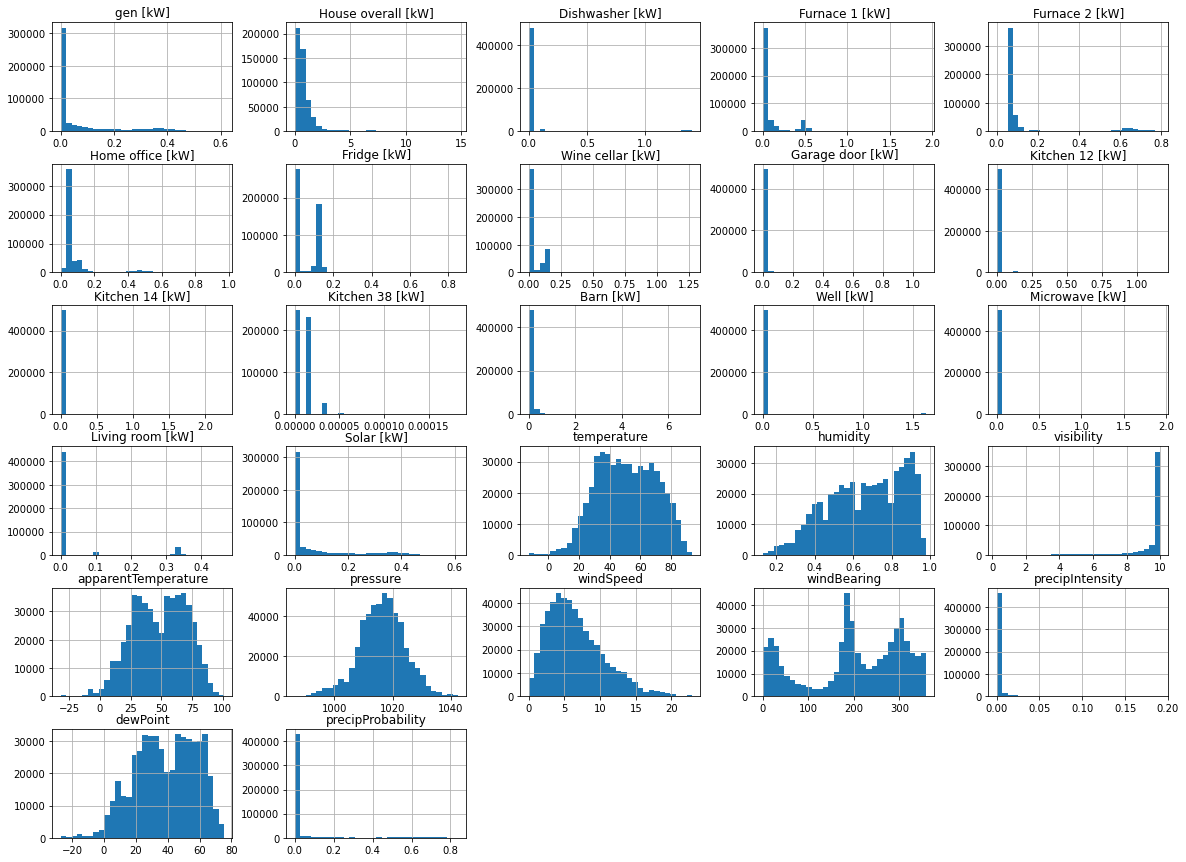

In [7]:
X.hist(bins=30, figsize=(20,15))
plt.show()

### Convert categorical to numerical feature

In [8]:
X['cloudCover'].unique()

array(['cloudCover', '0.75', '0', '1', '0.31', '0.44', '0.13', '0.19',
       '0.25', '0.16', '0.21', '0.15', '0.14', '0.27', '0.28', '0.17',
       '0.05', '0.1', '0.26', '0.29', '0.11', '0.09', '0.12', '0.06',
       '0.02', '0.08', '0.04', '0.35', '0.22', '0.23', '0.54', '0.39',
       '0.03', '0.07', '0.76', '0.62', '0.18', '0.79', '0.48', '0.24',
       '0.57', 0.24, 1.0, 0.31, 0.28, 0.15, 0.41, 0.1, 0.12, 0.08, 0.09,
       0.19, 0.04, 0.05, 0.29, 0.27, 0.35, 0.18, 0.06, 0.03, 0.11, 0.14,
       0.25, 0.78, 0.0, 0.16, 0.21, 0.23, 0.17, 0.75, 0.26, 0.2, 0.76,
       0.13, 0.77, 0.46, 0.07, 0.55, 0.02, 0.01, 0.51, 0.47, 0.5, 0.4,
       0.3, 0.22, 0.43, 0.33, 0.6, 0.68, 0.66, 0.45, 0.34, 0.52, 0.67,
       0.48, 0.49, 0.39, 0.37, 0.62, 0.36, 0.79, 0.61, 0.38, 0.42, 0.53,
       0.63, 0.44, 0.54, 0.32, 0.56, 0.58, 0.72, 0.57, 0.73, 0.71, 0.64,
       0.59], dtype=object)

In [9]:
X['cloudCover'].replace('cloudCover', '1', inplace = True)

In [10]:
X['cloudCover'] = X['cloudCover'].astype('float')
X['cloudCover'].unique()

array([1.  , 0.75, 0.  , 0.31, 0.44, 0.13, 0.19, 0.25, 0.16, 0.21, 0.15,
       0.14, 0.27, 0.28, 0.17, 0.05, 0.1 , 0.26, 0.29, 0.11, 0.09, 0.12,
       0.06, 0.02, 0.08, 0.04, 0.35, 0.22, 0.23, 0.54, 0.39, 0.03, 0.07,
       0.76, 0.62, 0.18, 0.79, 0.48, 0.24, 0.57, 0.41, 0.78, 0.2 , 0.77,
       0.46, 0.55, 0.01, 0.51, 0.47, 0.5 , 0.4 , 0.3 , 0.43, 0.33, 0.6 ,
       0.68, 0.66, 0.45, 0.34, 0.52, 0.67, 0.49, 0.37, 0.36, 0.61, 0.38,
       0.42, 0.53, 0.63, 0.32, 0.56, 0.58, 0.72, 0.73, 0.71, 0.64, 0.59])

### Combine same features

In [11]:
def combineFeaturesFunc(X): 
      X['Furnace [kW]'] = X['Furnace 1 [kW]'] + X['Furnace 2 [kW]']

      X['Kitchen [kW]'] = X['Kitchen 12 [kW]'] + X['Kitchen 14 [kW]'] + X['Kitchen 38 [kW]']

In [12]:
combineFeaturesFunc(X)

In [13]:
X.drop(columns=['Furnace 1 [kW]', 'Furnace 2 [kW]', 'Kitchen 12 [kW]', 'Kitchen 14 [kW]', 'Kitchen 38 [kW]'], inplace=True)

In [14]:
Furnace = X['Furnace [kW]']
X.drop(columns=['Furnace [kW]'], inplace=True)
X.insert(loc=3, column='Furnace [kW]', value=Furnace)

In [15]:
Kitchen = X['Kitchen [kW]']
X.drop(columns=['Kitchen [kW]'], inplace=True)
X.insert(loc=8, column='Kitchen [kW]', value=Kitchen)

### Drop same features

In [16]:
X.drop(columns=['House overall [kW]'], inplace=True)

In [17]:
X.drop(columns=['Solar [kW]'], inplace=True)

<AxesSubplot:>

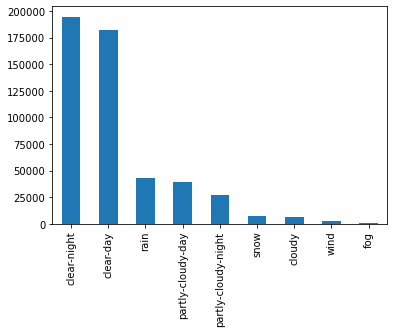

In [18]:
X['icon'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

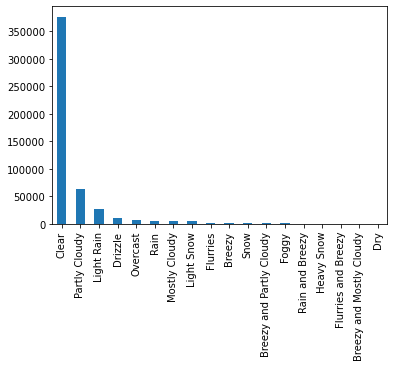

In [19]:
X['summary'].value_counts().plot(kind = 'bar')

In [20]:
def replaceLabel(X):
  X['summary'].replace(to_replace='Dry', value='Clear', inplace=True)

  X['summary'].replace(to_replace='Mostly Cloudy', value='Partly Cloudy', inplace=True)

  X['summary'].replace(to_replace='Overcast', value='Cloudy', inplace=True)

  X['summary'].replace(to_replace='Light Rain', value='Rain', inplace=True)

  X['summary'].replace(to_replace='Drizzle', value='Rain', inplace=True)

  X['summary'].replace(to_replace='Rain and Breezy', value='Rain', inplace=True)

  X['summary'].replace(to_replace='Breezy', value='Windy', inplace=True)

  X['summary'].replace(to_replace='Breezy and Partly Cloudy', value='Windy', inplace=True)

  X['summary'].replace(to_replace='Breezy and Mostly Cloudy', value='Windy', inplace=True)

  X['summary'].replace(to_replace='Light Snow', value='Snowy', inplace=True)

  X['summary'].replace(to_replace='Flurries', value='Snowy', inplace=True)

  X['summary'].replace(to_replace='Snow', value='Snowy', inplace=True)

  X['summary'].replace(to_replace='Heavy Snow', value='Snowy', inplace=True)

  X['summary'].replace(to_replace='Flurries and Breezy', value='Snowy', inplace=True)

In [21]:
replaceLabel(X)

<AxesSubplot:>

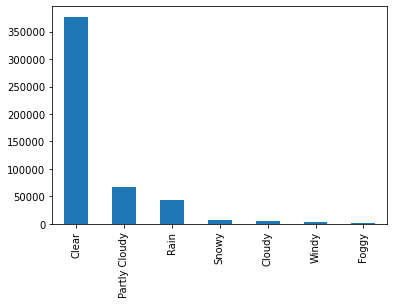

In [22]:
X['summary'].value_counts().plot(kind = 'bar')

In [23]:
X.drop(columns=['icon'], inplace=True)

### Drop features with many zeros

In [24]:
for count in X.columns:
    if ((X[count] == 0).sum())/len(X.index) > 0.80:
      X.drop(columns=[count], inplace=True)

### Linear correlation and scatter plot

In [25]:
def plt_corr(df, figsize ):

    # Create cmap for visualisation
    cmap=sns.color_palette("Spectral")

    # Create the correlation matrix
    corr = df.corr()

    # Add the mask to the heatmap
    plt.figure(figsize=(figsize))
    sns.set(font_scale=2)
    sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, annot=True)

    plt.title('Pearson correlation between numerical features')
    plt.show()

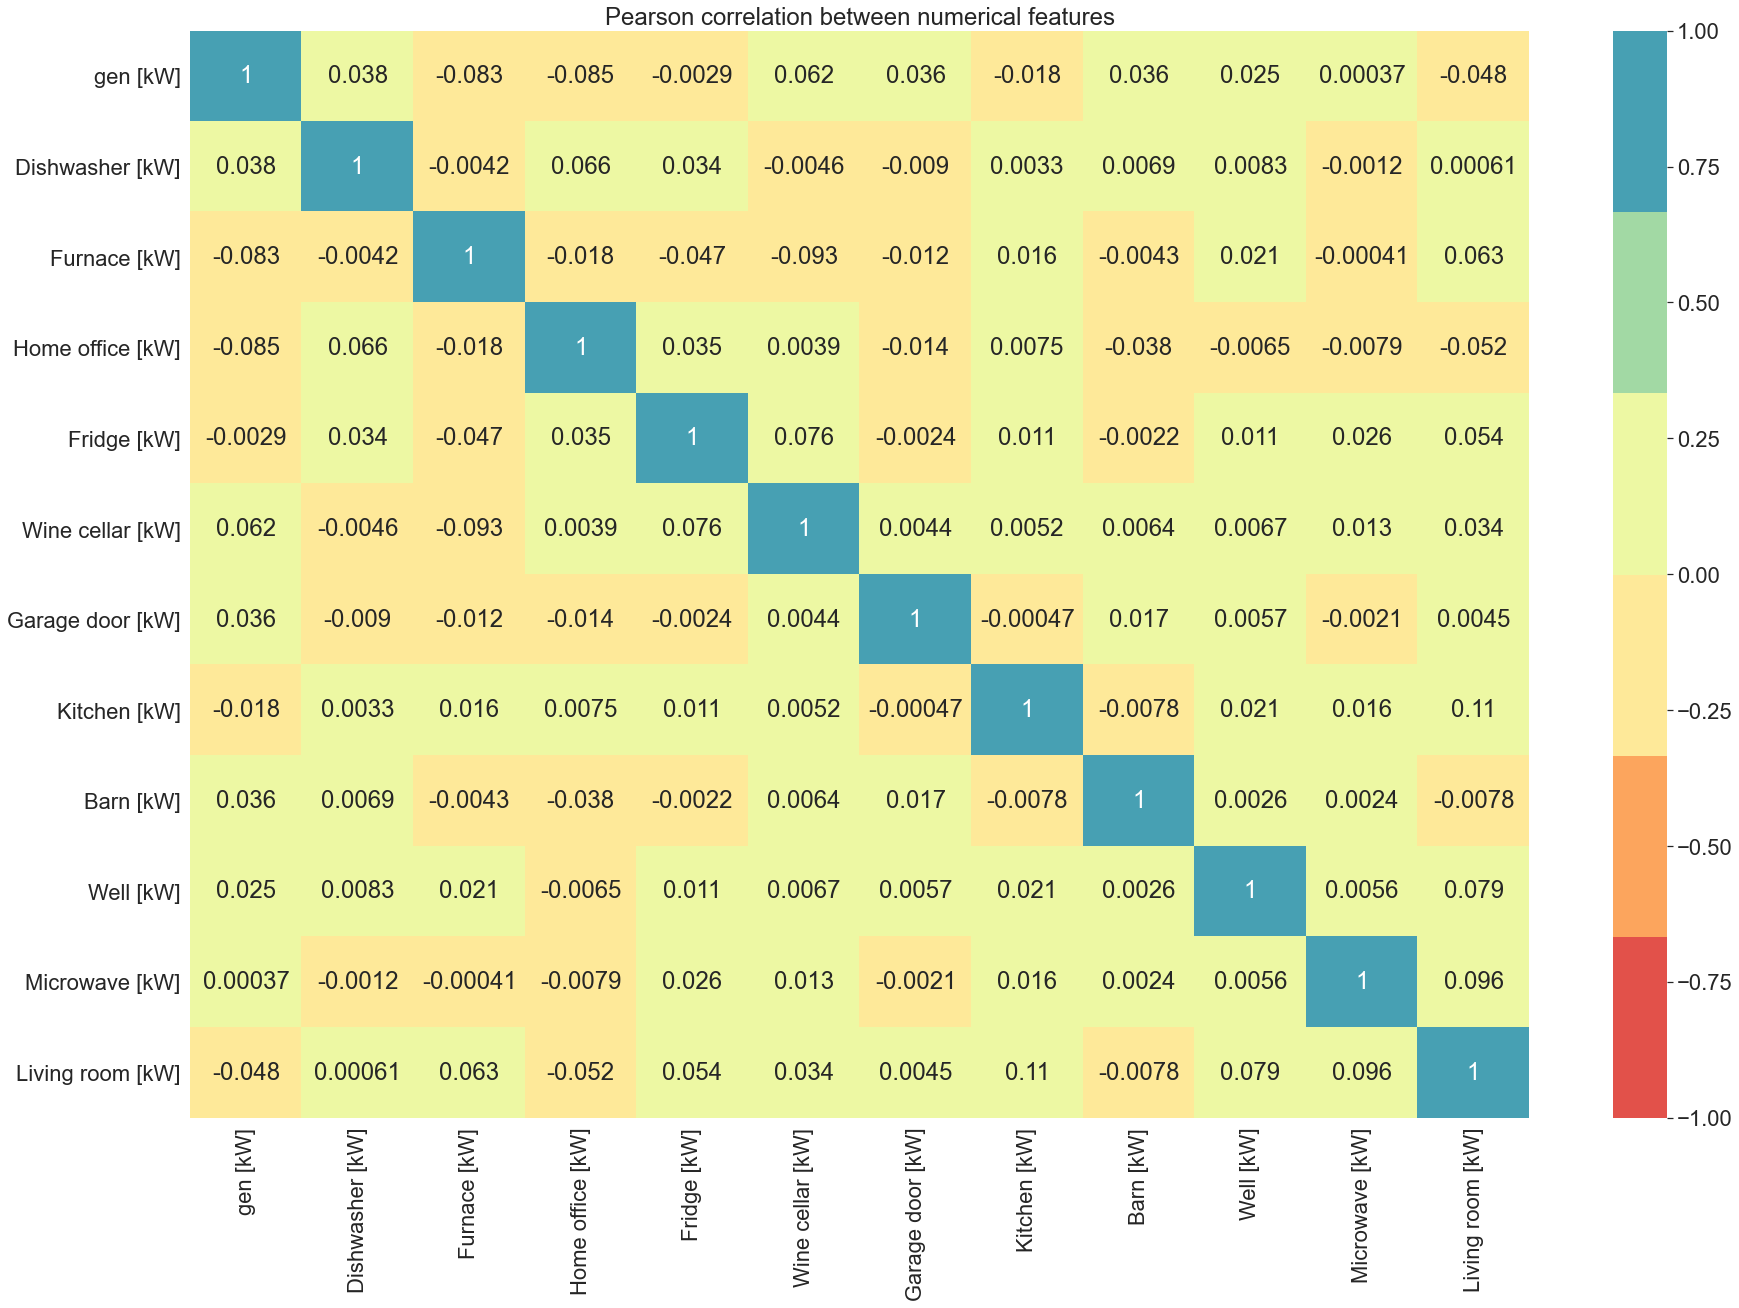

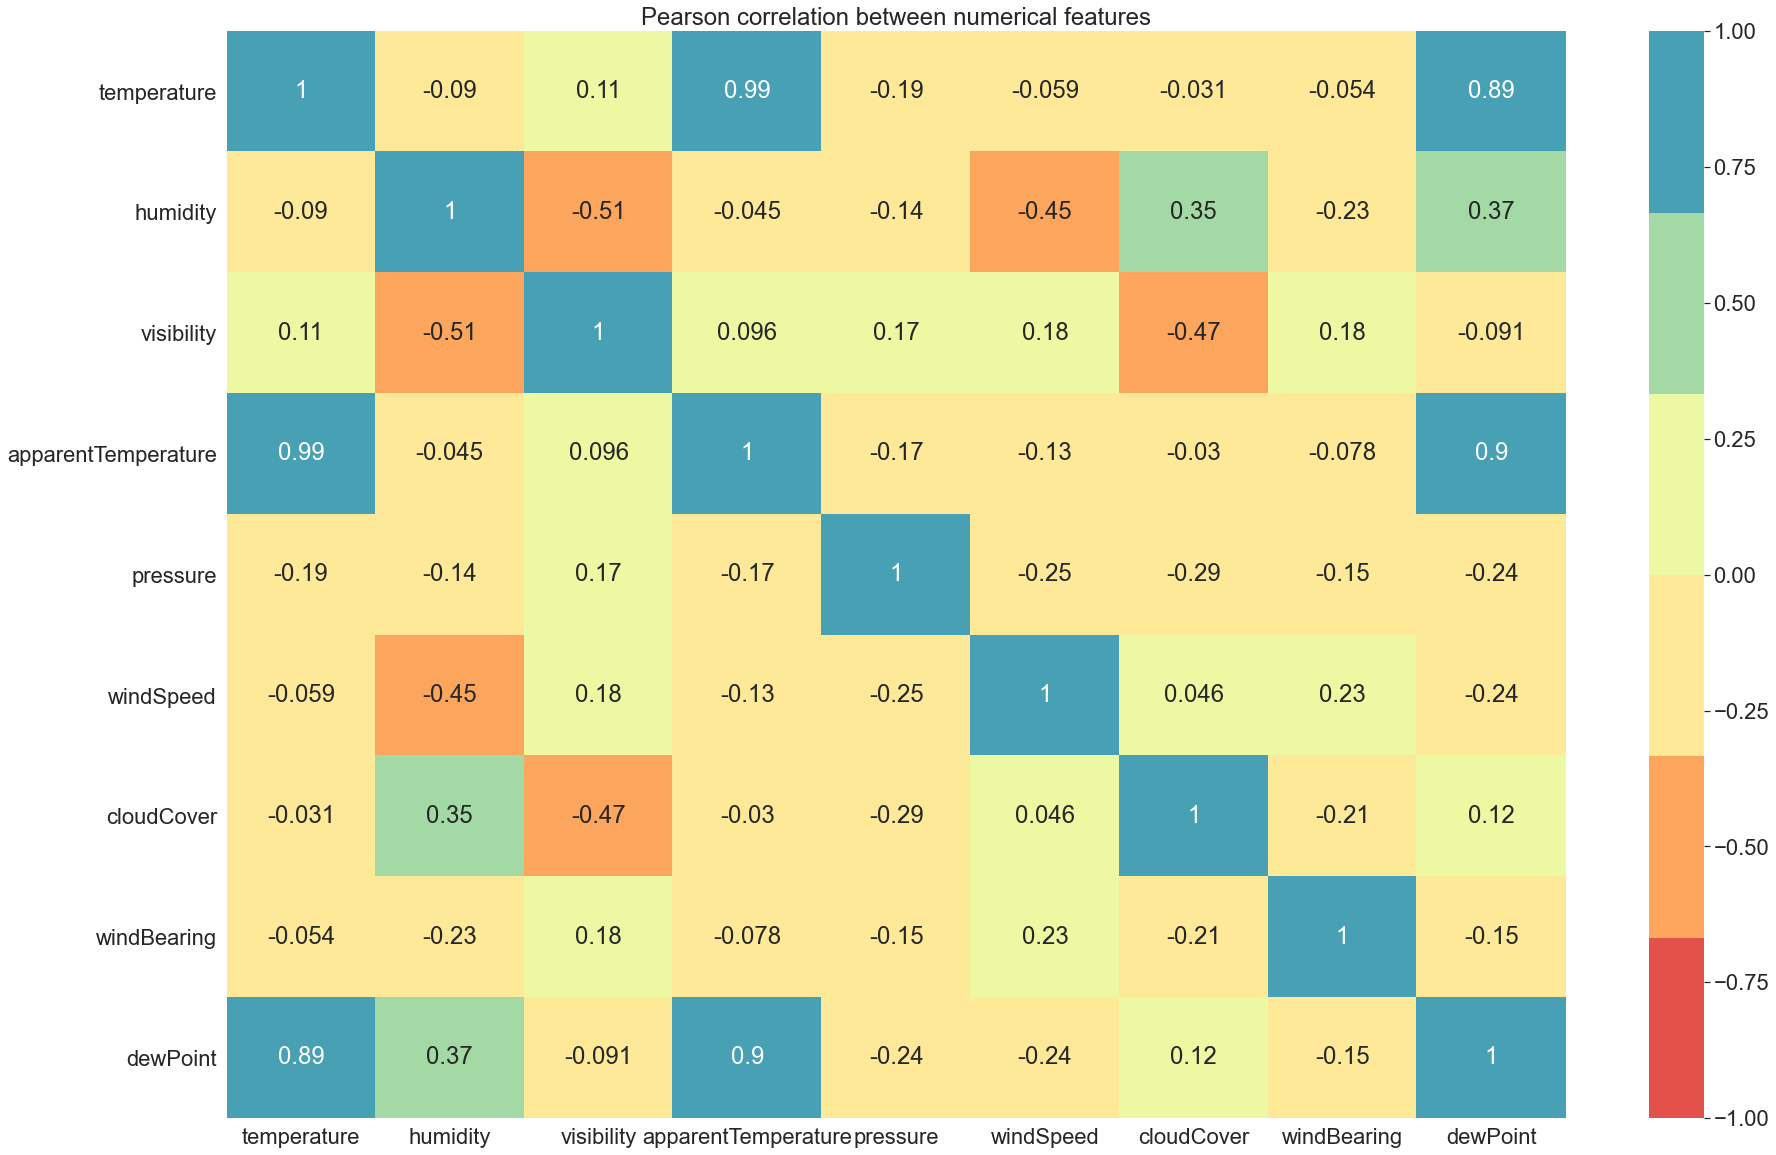

In [26]:
figsize=(30,20)

X1 = X.iloc[:, :12]
X2 = X.iloc[:, 12:]

plt_corr(X1, figsize)
plt_corr(X2, figsize)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='temperature', ylabel='apparentTemperature'>

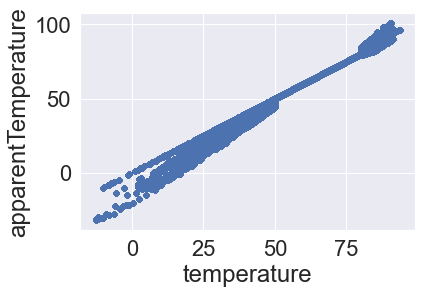

In [27]:
X.plot(x = 'temperature', y = 'apparentTemperature', kind = 'scatter')

In [28]:
X.drop(columns=['apparentTemperature'], inplace=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='temperature', ylabel='dewPoint'>

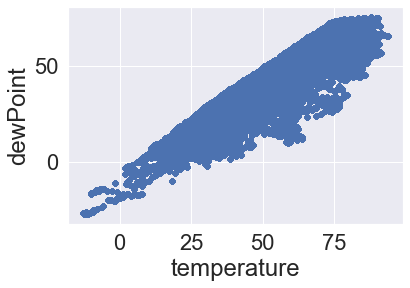

In [29]:
X.plot(x = 'temperature', y = 'dewPoint', kind = 'scatter')

In [30]:
X.drop(columns=['dewPoint'], inplace=True)

### Reduce data skewness and remove outlier

In [32]:
X.skew().sort_values(ascending = False)

Garage door [kW]    38.434802
Barn [kW]           19.252729
Microwave [kW]      15.366955
Kitchen [kW]        13.965533
Well [kW]           10.104986
Dishwasher [kW]      6.578071
Home office [kW]     3.330730
Wine cellar [kW]     2.885346
Living room [kW]     2.681857
Fridge [kW]          2.496257
Furnace [kW]         2.030218
cloudCover           1.834978
gen [kW]             1.744362
windSpeed            0.902613
temperature         -0.085145
pressure            -0.179831
humidity            -0.358174
windBearing         -0.498031
visibility          -2.798435
dtype: float64

In [33]:
def reduceSkew (df):
  for i in df:
    if df[i].dtypes == 'object':
      df[i] = df[i]
    else:
        if df[i].skew() > 1:
           df[i] = np.cbrt(df[i])
        elif df[i].skew() < -1:
           df[i] = np.power(df[i], 3)
        else:
           df[i] = df[i]

In [34]:
reduceSkew(X)

In [35]:
X.skew().sort_values(ascending = False)

Microwave [kW]      12.748701
Garage door [kW]     9.727581
Well [kW]            8.890289
Kitchen [kW]         6.807864
Barn [kW]            5.624212
Dishwasher [kW]      4.994549
Home office [kW]     2.468054
Living room [kW]     2.404577
Furnace [kW]         1.398625
gen [kW]             1.048188
Wine cellar [kW]     1.024196
windSpeed            0.902613
Fridge [kW]          0.354904
cloudCover          -0.031802
temperature         -0.085145
pressure            -0.179831
humidity            -0.358174
windBearing         -0.498031
visibility          -1.932285
dtype: float64

In [36]:
y.skew()

4.723696389921467

In [37]:
y=np.cbrt(y)
y.skew()

1.1405213677537223

In [38]:
X.describe()

gen [kW]  Dishwasher [kW]   Furnace [kW]  Home office [kW]  \
count  503910.000000    503910.000000  503910.000000     503910.000000   
mean        0.299027         0.063655       0.556642          0.398089   
std         0.210432         0.172090       0.181688          0.111307   
min         0.000000         0.000000       0.066946          0.043673   
25%         0.149876         0.000000       0.440200          0.343084   
50%         0.162403         0.025561       0.446391          0.348199   
75%         0.437807         0.061564       0.603147          0.408732   
max         0.849888         1.119159       1.352238          0.990493   

         Fridge [kW]  Wine cellar [kW]  Garage door [kW]   Kitchen [kW]  \
count  503910.000000     503910.000000     503910.000000  503910.000000   
mean        0.323614          0.287861          0.237825       0.105702   
std         0.169625          0.135085          0.026593       0.094623   
min         0.040555          0.025561          0.025561       0.000000   
25%         0.171942          0.192500          0.233515       0.084345   
50%         0.175801          0.200692          0.234731       0.090856   
75%         0.500555          0.376081          0.235735       0.094728   
max         0.947739          1.084049          1.028822       1.313444   

           Barn [kW]      Well [kW]  Microwave [kW]  Living room [kW]  \
count  503910.000000  503910.000000   503910.000000     503910.000000   
mean        0.341731       0.111899        0.161892          0.181966   
std         0.106988       0.105677        0.069951          0.174227   
min         0.000000       0.000000        0.000000          0.000000   
25%         0.310147       0.099441        0.153498          0.114046   
50%         0.315204       0.100000        0.158740          0.117365   
75%         0.320375       0.100553        0.159617          0.120507   
max         1.915469       1.177597        1.245004          0.774851   

         temperature       humidity     visibility       pressure  \
count  503910.000000  503910.000000  503910.000000  503910.000000   
mean       50.741935       0.664085     852.696640    1016.301625   
std        19.113807       0.194389     266.200487       7.895185   
min       -12.640000       0.130000       0.019683     986.400000   
25%        35.770000       0.510000     835.896888    1011.290000   
50%        50.320000       0.680000    1000.000000    1016.530000   
75%        66.260000       0.840000    1000.000000    1021.480000   
max        93.720000       0.980000    1000.000000    1042.460000   

           windSpeed     cloudCover    windBearing  
count  503910.000000  503910.000000  503910.000000  
mean        6.649936       0.487494     202.356843  
std         3.982716       0.275229     106.520474  
min         0.000000       0.000000       0.000000  
25%         3.660000       0.341995     148.000000  
50%         5.930000       0.493242     208.000000  
75%         8.940000       0.661911     295.000000  
max        22.910000       1.000000     359.000000

### Data Visualisation

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='use [kW]'>

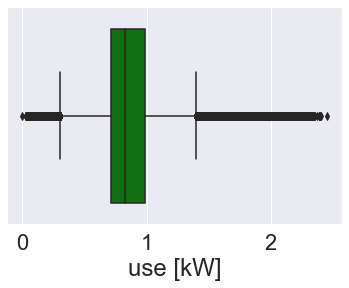

In [102]:
sns.boxplot(y, orient='h', color='green')

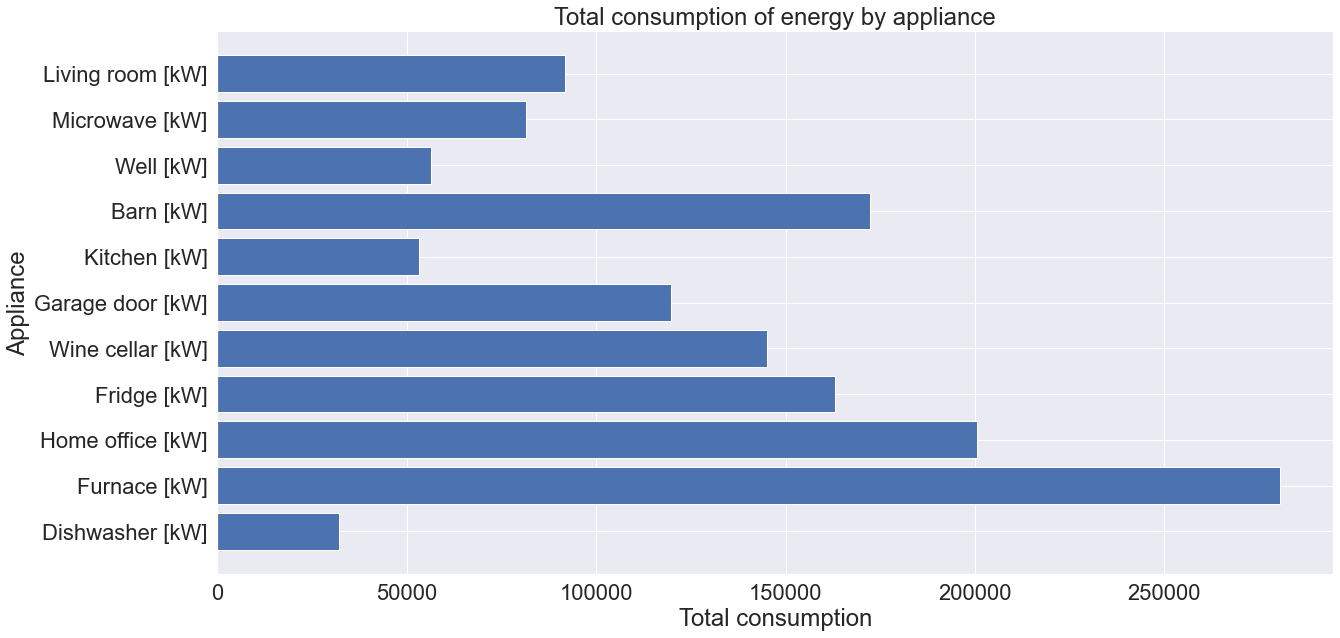

In [103]:
cols=['Dishwasher [kW]', 'Furnace [kW]', 'Home office [kW]', 'Fridge [kW]', 'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen [kW]', 'Barn [kW]', 'Well [kW]', 'Microwave [kW]', 'Living room [kW]']

plt.figure(figsize=(20,10))
plt.barh(cols, X[cols].sum(), align='center')
plt.xlabel('Total consumption')
plt.ylabel("Appliance")
plt.title('Total consumption of energy by appliance')
plt.show()

### Split dataset 

In [42]:
print ('X: shape=', X.shape, 'type=', type(X))
print ('y: shape=', y.shape, 'type=', type(y))

X: shape= (503910, 20) type= <class 'pandas.core.frame.DataFrame'>
y: shape= (503910,) type= <class 'pandas.core.series.Series'>


#### 70%-30%

In [43]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)

#### 75%-25%

In [44]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.25, random_state=42)

#### 80%-20%

In [45]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.2, random_state=42)

#### 85%-15%

In [46]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.15, random_state=42)

### Preprocess train and test set

In [47]:
def preprocess(X_train, y_train, X_test, y_test):
    # Separate categorical data from numerical data 
    X_train_num = X_train.drop('summary', axis = 1)
    X_train_cat = X_train['summary']
    X_test_num = X_test.drop('summary', axis = 1)
    X_test_cat = X_test['summary']

    # Standardize numerical data
    scaler = StandardScaler(copy = False)
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)

    # Encode categorical data
    lb_encoder = LabelBinarizer()
    X_train_cat = lb_encoder.fit_transform(X_train_cat)
    X_test_cat = lb_encoder.transform(X_test_cat)

    # Convert input X and output y to numpy array
    X_train = np.hstack([X_train_num, X_train_cat])
    X_test = np.hstack([X_test_num, X_test_cat])
    y_train = y_train.values
    y_test = y_test.values

    return X_train, y_train, X_test, y_test, scaler

In [48]:
X_train1, y_train1, X_test1, y_test1, scaler1 = preprocess(X_train1, y_train1, X_test1, y_test1)

X_train2, y_train2, X_test2, y_test2, scaler2 = preprocess(X_train2, y_train2, X_test2, y_test2)

X_train3, y_train3, X_test3, y_test3, scaler3 = preprocess(X_train3, y_train3, X_test3, y_test3)

X_train4, y_train4, X_test4, y_test4, scaler4 = preprocess(X_train4, y_train4, X_test4, y_test4)

## 2) Building Model

In [ ]:
def create_model():
    #Intialise the mlp model
    mlp = Sequential()

    #Input Layer
    mlp.add(InputLayer(input_shape=(26, )))

    #1st hidden layer
    mlp.add(Dense(units=26, activation='relu', name='dense1'))

    #2nd hidden layer
    mlp.add(Dense(units=13, activation='relu', name='dense2'))

    #3rd hidden layer
    mlp.add(Dense(units=7, activation='relu', name='dense3'))

    #Output layer
    mlp.add(Dense(units=1, activation='relu', name='output'))

    return mlp

mlp = create_model()
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 26)                702       
                                                                 
 dense2 (Dense)              (None, 13)                351       
                                                                 
 dense3 (Dense)              (None, 7)                 98        
                                                                 
 output (Dense)              (None, 1)                 8         
                                                                 
Total params: 1,159
Trainable params: 1,159
Non-trainable params: 0
_________________________________________________________________


## 3) Training Model

### 70%-30%

In [ ]:
mlp1=create_model()

In [ ]:
opt = SGD(learning_rate=0.001, momentum=0.9)
mlp1.compile(loss='MeanSquaredError', metrics = ['RootMeanSquaredError'], optimizer=opt)

In [ ]:
callback = [EarlyStopping(monitor='val_loss', mode="min", patience=5, verbose=1), 
            ModelCheckpoint('best_model1', monitor='val_loss', mode="min", save_best_only=True, verbose=1)]
history1 = mlp1.fit(X_train1, y_train1, epochs=100, verbose=2, batch_size=32, callbacks=[callback], shuffle=True, 
                    validation_split=0.43)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.01787, saving model to best_model1
INFO:tensorflow:Assets written to: best_model1\assets
6284/6284 - 7s - loss: 0.0296 - root_mean_squared_error: 0.1720 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1337 - 7s/epoch - 1ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.01787 to 0.01403, saving model to best_model1
INFO:tensorflow:Assets written to: best_model1\assets
6284/6284 - 7s - loss: 0.0158 - root_mean_squared_error: 0.1257 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1185 - 7s/epoch - 1ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.01403 to 0.01193, saving model to best_model1
INFO:tensorflow:Assets written to: best_model1\assets
6284/6284 - 7s - loss: 0.0130 - root_mean_squared_error: 0.1140 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1092 - 7s/epoch - 1ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.01193 to 0.01072, saving model to best_model1
INFO:tensorflow:Assets written to: best_m

Epoch 30/100

Epoch 30: val_loss improved from 0.00765 to 0.00762, saving model to best_model1
INFO:tensorflow:Assets written to: best_model1\assets
6284/6284 - 6s - loss: 0.0076 - root_mean_squared_error: 0.0873 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873 - 6s/epoch - 1ms/step
Epoch 31/100

Epoch 31: val_loss did not improve from 0.00762
6284/6284 - 6s - loss: 0.0076 - root_mean_squared_error: 0.0872 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873 - 6s/epoch - 888us/step
Epoch 32/100

Epoch 32: val_loss improved from 0.00762 to 0.00755, saving model to best_model1
INFO:tensorflow:Assets written to: best_model1\assets
6284/6284 - 6s - loss: 0.0076 - root_mean_squared_error: 0.0870 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0869 - 6s/epoch - 1ms/step
Epoch 33/100

Epoch 33: val_loss improved from 0.00755 to 0.00754, saving model to best_model1
INFO:tensorflow:Assets written to: best_model1\assets
6284/6284 - 6s - loss: 0.0075 - root_mean_squared_error: 0.0

Epoch 61/100

Epoch 61: val_loss improved from 0.00704 to 0.00703, saving model to best_model1
INFO:tensorflow:Assets written to: best_model1\assets
6284/6284 - 6s - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0838 - 6s/epoch - 1ms/step
Epoch 62/100

Epoch 62: val_loss improved from 0.00703 to 0.00701, saving model to best_model1
INFO:tensorflow:Assets written to: best_model1\assets
6284/6284 - 6s - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837 - 6s/epoch - 998us/step
Epoch 63/100

Epoch 63: val_loss improved from 0.00701 to 0.00699, saving model to best_model1
INFO:tensorflow:Assets written to: best_model1\assets
6284/6284 - 6s - loss: 0.0069 - root_mean_squared_error: 0.0834 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0836 - 6s/epoch - 1ms/step
Epoch 64/100

Epoch 64: val_loss improved from 0.00699 to 0.00699, saving model to best_model1
INFO:tensorflow:Assets writ

6284/6284 - 6s - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0819 - 6s/epoch - 1ms/step
Epoch 92/100

Epoch 92: val_loss did not improve from 0.00671
6284/6284 - 6s - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0821 - 6s/epoch - 883us/step
Epoch 93/100

Epoch 93: val_loss did not improve from 0.00671
6284/6284 - 6s - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0819 - 6s/epoch - 919us/step
Epoch 94/100

Epoch 94: val_loss improved from 0.00671 to 0.00669, saving model to best_model1
INFO:tensorflow:Assets written to: best_model1\assets
6284/6284 - 7s - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818 - 7s/epoch - 1ms/step
Epoch 95/100

Epoch 95: val_loss did not improve from 0.00669
6284/6284 - 6s - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0067 - val_

### 75%-25%

In [ ]:
mlp2=create_model()

In [ ]:
mlp2.compile(loss='MeanSquaredError', metrics = ['RootMeanSquaredError'], optimizer=opt)

In [ ]:
callback = [EarlyStopping(monitor='val_loss', mode="min", patience=5, verbose=1), 
            ModelCheckpoint('best_model2', monitor='val_loss', mode="min", save_best_only=True, verbose=1)]
history2 = mlp2.fit(X_train2, y_train2, epochs=100, verbose=2, batch_size=32, callbacks=[callback], shuffle=True, 
                    validation_split=0.33)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.01446, saving model to best_model2
INFO:tensorflow:Assets written to: best_model2\assets
7913/7913 - 7s - loss: 0.0260 - root_mean_squared_error: 0.1612 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1202 - 7s/epoch - 945us/step
Epoch 2/100

Epoch 2: val_loss improved from 0.01446 to 0.01219, saving model to best_model2
INFO:tensorflow:Assets written to: best_model2\assets
7913/7913 - 7s - loss: 0.0131 - root_mean_squared_error: 0.1145 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1104 - 7s/epoch - 862us/step
Epoch 3/100

Epoch 3: val_loss improved from 0.01219 to 0.01095, saving model to best_model2
INFO:tensorflow:Assets written to: best_model2\assets
7913/7913 - 7s - loss: 0.0115 - root_mean_squared_error: 0.1073 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1046 - 7s/epoch - 886us/step
Epoch 4/100

Epoch 4: val_loss improved from 0.01095 to 0.01011, saving model to best_model2
INFO:tensorflow:Assets written to: 


Epoch 29: val_loss improved from 0.00750 to 0.00747, saving model to best_model2
INFO:tensorflow:Assets written to: best_model2\assets
7913/7913 - 8s - loss: 0.0074 - root_mean_squared_error: 0.0861 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864 - 8s/epoch - 992us/step
Epoch 30/100

Epoch 30: val_loss improved from 0.00747 to 0.00744, saving model to best_model2
INFO:tensorflow:Assets written to: best_model2\assets
7913/7913 - 8s - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0862 - 8s/epoch - 950us/step
Epoch 31/100

Epoch 31: val_loss improved from 0.00744 to 0.00741, saving model to best_model2
INFO:tensorflow:Assets written to: best_model2\assets
7913/7913 - 7s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861 - 7s/epoch - 929us/step
Epoch 32/100

Epoch 32: val_loss improved from 0.00741 to 0.00739, saving model to best_model2
INFO:tensorflow:Assets written to: b

Epoch 59/100

Epoch 59: val_loss did not improve from 0.00699
7913/7913 - 8s - loss: 0.0069 - root_mean_squared_error: 0.0829 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837 - 8s/epoch - 957us/step
Epoch 60/100

Epoch 60: val_loss improved from 0.00699 to 0.00697, saving model to best_model2
INFO:tensorflow:Assets written to: best_model2\assets
7913/7913 - 9s - loss: 0.0069 - root_mean_squared_error: 0.0828 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0835 - 9s/epoch - 1ms/step
Epoch 61/100

Epoch 61: val_loss improved from 0.00697 to 0.00696, saving model to best_model2
INFO:tensorflow:Assets written to: best_model2\assets
7913/7913 - 9s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0834 - 9s/epoch - 1ms/step
Epoch 62/100

Epoch 62: val_loss did not improve from 0.00696
7913/7913 - 8s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0835 - 8s/epoch - 964us/step
Ep

Epoch 90/100

Epoch 90: val_loss did not improve from 0.00677
7913/7913 - 8s - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0824 - 8s/epoch - 970us/step
Epoch 91/100

Epoch 91: val_loss did not improve from 0.00677
7913/7913 - 8s - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0824 - 8s/epoch - 955us/step
Epoch 92/100

Epoch 92: val_loss improved from 0.00677 to 0.00674, saving model to best_model2
INFO:tensorflow:Assets written to: best_model2\assets
7913/7913 - 9s - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0821 - 9s/epoch - 1ms/step
Epoch 93/100

Epoch 93: val_loss did not improve from 0.00674
7913/7913 - 8s - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0821 - 8s/epoch - 1ms/step
Epoch 94/100

Epoch 94: val_loss improved from 0.00674 to 0.00674, saving model to best_m

### 80%-20%

In [ ]:
mlp3=create_model()

In [ ]:
mlp3.compile(loss='MeanSquaredError', metrics = ['RootMeanSquaredError'], optimizer=opt)

In [ ]:
callback = [EarlyStopping(monitor='val_loss', mode="min", patience=5, verbose=1), 
            ModelCheckpoint('best_model3', monitor='val_loss', mode="min", save_best_only=True, verbose=1)]
history3 = mlp3.fit(X_train3, y_train3, epochs=100, verbose=2, batch_size=32, callbacks=[callback], shuffle=True, 
                    validation_split=0.25)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.01287, saving model to best_model3
INFO:tensorflow:Assets written to: best_model3\assets
9449/9449 - 10s - loss: 0.0219 - root_mean_squared_error: 0.1481 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134 - 10s/epoch - 1ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.01287 to 0.01107, saving model to best_model3
INFO:tensorflow:Assets written to: best_model3\assets
9449/9449 - 10s - loss: 0.0118 - root_mean_squared_error: 0.1087 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052 - 10s/epoch - 1ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.01107 to 0.01022, saving model to best_model3
INFO:tensorflow:Assets written to: best_model3\assets
9449/9449 - 9s - loss: 0.0106 - root_mean_squared_error: 0.1029 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1011 - 9s/epoch - 996us/step
Epoch 4/100

Epoch 4: val_loss improved from 0.01022 to 0.00997, saving model to best_model3
INFO:tensorflow:Assets written to: 

Epoch 29/100

Epoch 29: val_loss improved from 0.00761 to 0.00759, saving model to best_model3
INFO:tensorflow:Assets written to: best_model3\assets
9449/9449 - 9s - loss: 0.0076 - root_mean_squared_error: 0.0872 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871 - 9s/epoch - 962us/step
Epoch 30/100

Epoch 30: val_loss improved from 0.00759 to 0.00754, saving model to best_model3
INFO:tensorflow:Assets written to: best_model3\assets
9449/9449 - 10s - loss: 0.0076 - root_mean_squared_error: 0.0870 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0868 - 10s/epoch - 1ms/step
Epoch 31/100

Epoch 31: val_loss did not improve from 0.00754
9449/9449 - 8s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0868 - 8s/epoch - 890us/step
Epoch 32/100

Epoch 32: val_loss improved from 0.00754 to 0.00751, saving model to best_model3
INFO:tensorflow:Assets written to: best_model3\assets
9449/9449 - 10s - loss: 0.0075 - root_mean_squared_error

INFO:tensorflow:Assets written to: best_model3\assets
9449/9449 - 9s - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837 - 9s/epoch - 970us/step
Epoch 60/100

Epoch 60: val_loss improved from 0.00701 to 0.00700, saving model to best_model3
INFO:tensorflow:Assets written to: best_model3\assets
9449/9449 - 9s - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837 - 9s/epoch - 974us/step
Epoch 61/100

Epoch 61: val_loss improved from 0.00700 to 0.00699, saving model to best_model3
INFO:tensorflow:Assets written to: best_model3\assets
9449/9449 - 9s - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0836 - 9s/epoch - 947us/step
Epoch 62/100

Epoch 62: val_loss improved from 0.00699 to 0.00698, saving model to best_model3
INFO:tensorflow:Assets written to: best_model3\assets
9449/9449 - 10s - loss: 0.0070 - root_mean_squared_error: 0.0835

Epoch 89/100

Epoch 89: val_loss improved from 0.00672 to 0.00670, saving model to best_model3
INFO:tensorflow:Assets written to: best_model3\assets
9449/9449 - 9s - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0819 - 9s/epoch - 1000us/step
Epoch 90/100

Epoch 90: val_loss did not improve from 0.00670
9449/9449 - 8s - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0824 - 8s/epoch - 877us/step
Epoch 91/100

Epoch 91: val_loss improved from 0.00670 to 0.00668, saving model to best_model3
INFO:tensorflow:Assets written to: best_model3\assets
9449/9449 - 9s - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0817 - 9s/epoch - 975us/step
Epoch 92/100

Epoch 92: val_loss did not improve from 0.00668
9449/9449 - 9s - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0823 - 9s/epoch - 951us/st

### 85%-15%

In [ ]:
mlp4=create_model()

In [ ]:
mlp4.compile(loss='MeanSquaredError', metrics = ['RootMeanSquaredError'], optimizer=opt)

In [ ]:
callback = [EarlyStopping(monitor='val_loss', mode="min", patience=5, verbose=1), 
            ModelCheckpoint('best_model4', monitor='val_loss', mode="min", save_best_only=True, verbose=1)]
history4 = mlp4.fit(X_train4, y_train4, epochs=100, verbose=2, batch_size=32, callbacks=[callback], shuffle=True, 
                    validation_split=0.18)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.01312, saving model to best_model4
INFO:tensorflow:Assets written to: best_model4\assets
10976/10976 - 11s - loss: 0.0207 - root_mean_squared_error: 0.1439 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1145 - 11s/epoch - 1ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.01312 to 0.01088, saving model to best_model4
INFO:tensorflow:Assets written to: best_model4\assets
10976/10976 - 10s - loss: 0.0118 - root_mean_squared_error: 0.1085 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043 - 10s/epoch - 948us/step
Epoch 3/100

Epoch 3: val_loss improved from 0.01088 to 0.00989, saving model to best_model4
INFO:tensorflow:Assets written to: best_model4\assets
10976/10976 - 10s - loss: 0.0103 - root_mean_squared_error: 0.1017 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0994 - 10s/epoch - 906us/step
Epoch 4/100

Epoch 4: val_loss improved from 0.00989 to 0.00933, saving model to best_model4
INFO:tensorflow:Assets wr

Epoch 29/100

Epoch 29: val_loss improved from 0.00737 to 0.00734, saving model to best_model4
INFO:tensorflow:Assets written to: best_model4\assets
10976/10976 - 12s - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0857 - 12s/epoch - 1ms/step
Epoch 30/100

Epoch 30: val_loss improved from 0.00734 to 0.00732, saving model to best_model4
INFO:tensorflow:Assets written to: best_model4\assets
10976/10976 - 10s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856 - 10s/epoch - 931us/step
Epoch 31/100

Epoch 31: val_loss improved from 0.00732 to 0.00730, saving model to best_model4
INFO:tensorflow:Assets written to: best_model4\assets
10976/10976 - 11s - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0855 - 11s/epoch - 963us/step
Epoch 32/100

Epoch 32: val_loss did not improve from 0.00730
10976/10976 - 9s - loss: 0.0073 - root_mean_sq


Epoch 58: val_loss improved from 0.00683 to 0.00682, saving model to best_model4
INFO:tensorflow:Assets written to: best_model4\assets
10976/10976 - 10s - loss: 0.0068 - root_mean_squared_error: 0.0824 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0826 - 10s/epoch - 935us/step
Epoch 59/100

Epoch 59: val_loss improved from 0.00682 to 0.00678, saving model to best_model4
INFO:tensorflow:Assets written to: best_model4\assets
10976/10976 - 10s - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0824 - 10s/epoch - 946us/step
Epoch 60/100

Epoch 60: val_loss did not improve from 0.00678
10976/10976 - 9s - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0825 - 9s/epoch - 788us/step
Epoch 61/100

Epoch 61: val_loss improved from 0.00678 to 0.00676, saving model to best_model4
INFO:tensorflow:Assets written to: best_model4\assets
10976/10976 - 10s - loss: 0.0067 - root_mean_squared_error:

Epoch 89/100

Epoch 89: val_loss improved from 0.00630 to 0.00624, saving model to best_model4
INFO:tensorflow:Assets written to: best_model4\assets
10976/10976 - 11s - loss: 0.0063 - root_mean_squared_error: 0.0791 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790 - 11s/epoch - 970us/step
Epoch 90/100

Epoch 90: val_loss did not improve from 0.00624
10976/10976 - 9s - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0792 - 9s/epoch - 797us/step
Epoch 91/100

Epoch 91: val_loss improved from 0.00624 to 0.00621, saving model to best_model4
INFO:tensorflow:Assets written to: best_model4\assets
10976/10976 - 10s - loss: 0.0062 - root_mean_squared_error: 0.0789 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0788 - 10s/epoch - 920us/step
Epoch 92/100

Epoch 92: val_loss did not improve from 0.00621
10976/10976 - 9s - loss: 0.0062 - root_mean_squared_error: 0.0789 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789 - 9s/epoch

### Loss function

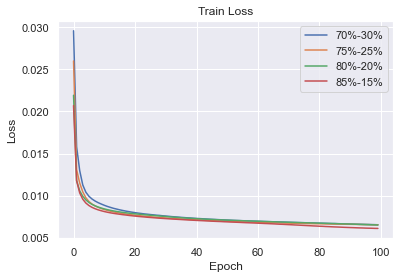

In [ ]:
plt.plot(history1.history['loss'], label='70%-30%')
plt.plot(history2.history['loss'], label='75%-25%')
plt.plot(history3.history['loss'], label='80%-20%')
plt.plot(history4.history['loss'], label='85%-15%')
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

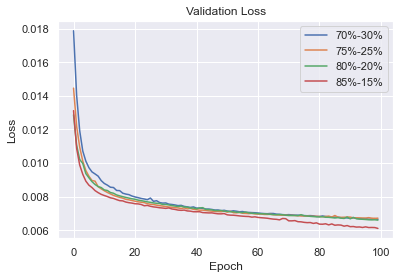

In [ ]:
plt.plot(history1.history['val_loss'], label='70%-30%')
plt.plot(history2.history['val_loss'], label='75%-25%')
plt.plot(history3.history['val_loss'], label='80%-20%')
plt.plot(history4.history['val_loss'], label='85%-15%')
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 4) Evaluating Model on Training Set

### 70%-30%

In [54]:
def show10results(y_pred, y_actual):
  print("Result for the 10 random samples:")
  selected = np.random.randint(0, len(y_actual), 10)
  for i in selected:
      print('actual = {:0.4f} pred ={:0.4f}'.format(y_actual[i], y_pred[i]))

In [ ]:
y_pred1 = mlp1.predict(X_train1)

In [ ]:
y_pred1 = y_pred1.reshape(-1)

In [ ]:
show10results(y_pred1, y_train1)

Result for the 10 random samples:
actual = 1.0198 pred =1.0715
actual = 0.8451 pred =0.8398
actual = 0.3312 pred =0.3943
actual = 0.4661 pred =0.5261
actual = 1.4232 pred =1.4177
actual = 0.6542 pred =0.6920
actual = 1.2488 pred =1.0825
actual = 0.9753 pred =0.9907
actual = 1.0475 pred =1.0715
actual = 1.1605 pred =1.1587


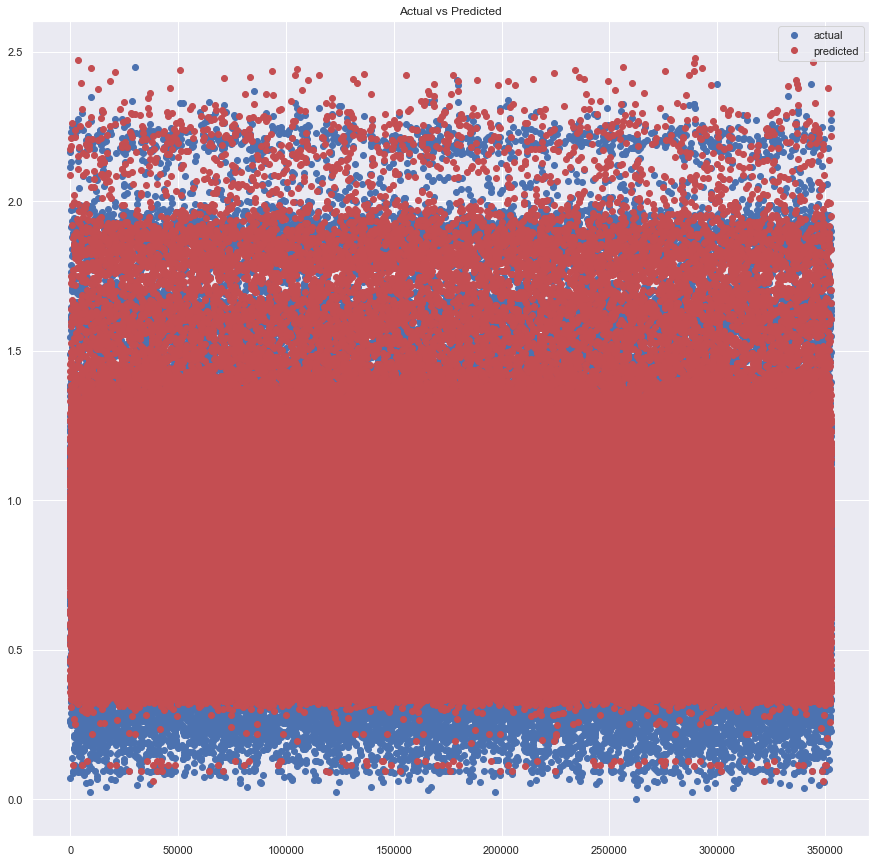

In [ ]:
plt.figure(figsize=(15,15))

plt.plot(y_train1, 'bo', label='actual')
plt.plot(y_pred1, 'ro', label='predicted')
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

In [ ]:
mse, rmse = mlp1.evaluate(X_train1, y_train1, verbose=0)
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Squared Error: {:.4f}'.format(rmse))

Mean Squared Error: 0.0066
Root Mean Squared Error: 0.0812


In [ ]:
MAE = MeanAbsoluteError()
MAE.update_state(y_pred1, y_train1)
print('Mean Absolute Error: {:.4f}'.format(MAE.result().numpy()))

Mean Absolute Error: 0.0468


### 75%-25%

In [63]:
y_pred2 = mlp2.predict(X_train2)

In [64]:
y_pred2 = y_pred2.reshape(-1)

In [65]:
show10results(y_pred2, y_train2)

Result for the 10 random samples:
actual = 0.6657 pred =0.7169
actual = 0.2591 pred =0.3843
actual = 0.8898 pred =0.8367
actual = 0.6667 pred =0.6974
actual = 2.0033 pred =1.9615
actual = 0.6737 pred =0.7446
actual = 0.7053 pred =0.7293
actual = 0.7028 pred =0.7687
actual = 0.8126 pred =0.7930
actual = 0.8281 pred =0.8303


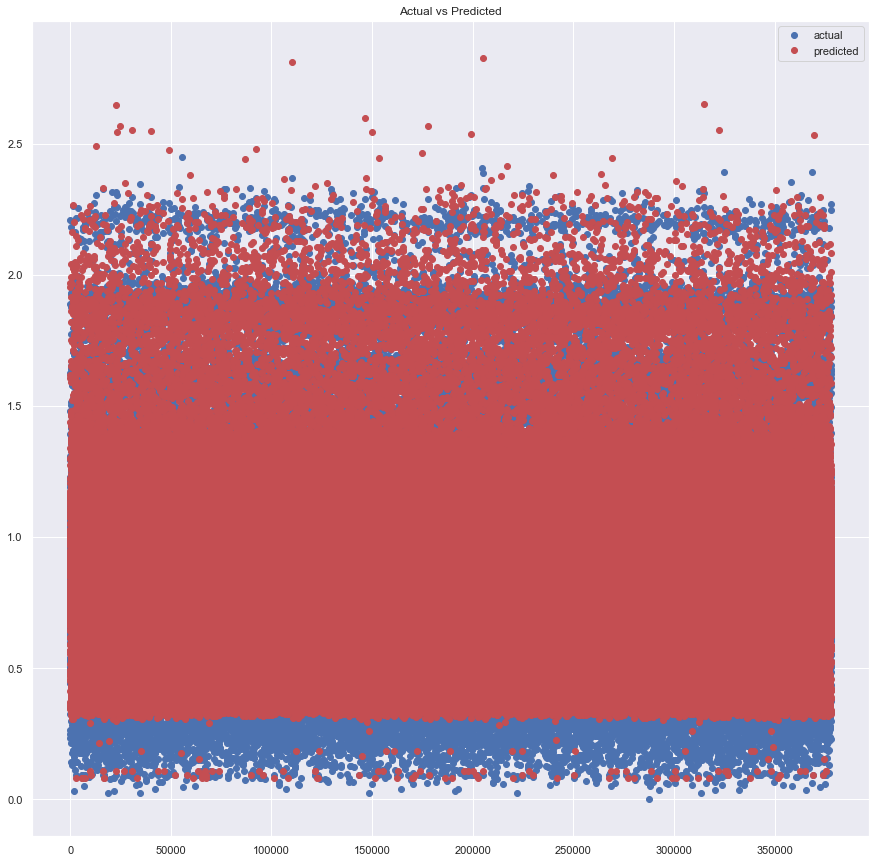

In [66]:
plt.figure(figsize=(15,15))

plt.plot(y_train2, 'bo', label='actual')
plt.plot(y_pred2, 'ro', label='predicted')
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

In [67]:
mse, rmse = mlp2.evaluate(X_train2, y_train2, verbose=0)
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Squared Error: {:.4f}'.format(rmse))

Mean Squared Error: 0.0066
Root Mean Squared Error: 0.0812


In [68]:
MAE = MeanAbsoluteError()
MAE.update_state(y_pred2, y_train2)
print('Mean Absolute Error: {:.4f}'.format(MAE.result().numpy()))

Mean Absolute Error: 0.0466


### 80%-20%

In [ ]:
y_pred3 = mlp3.predict(X_train3)

In [ ]:
y_pred3 = y_pred3.reshape(-1)

In [ ]:
show10results(y_pred3, y_train3)

Result for the 10 random samples:
actual = 1.0018 pred =1.0262
actual = 0.8360 pred =0.8650
actual = 1.0958 pred =1.1030
actual = 1.2815 pred =1.3278
actual = 0.5564 pred =0.5663
actual = 1.2014 pred =1.2105
actual = 0.8802 pred =0.8961
actual = 0.8519 pred =0.8960
actual = 0.8175 pred =0.8169
actual = 1.1859 pred =1.2493


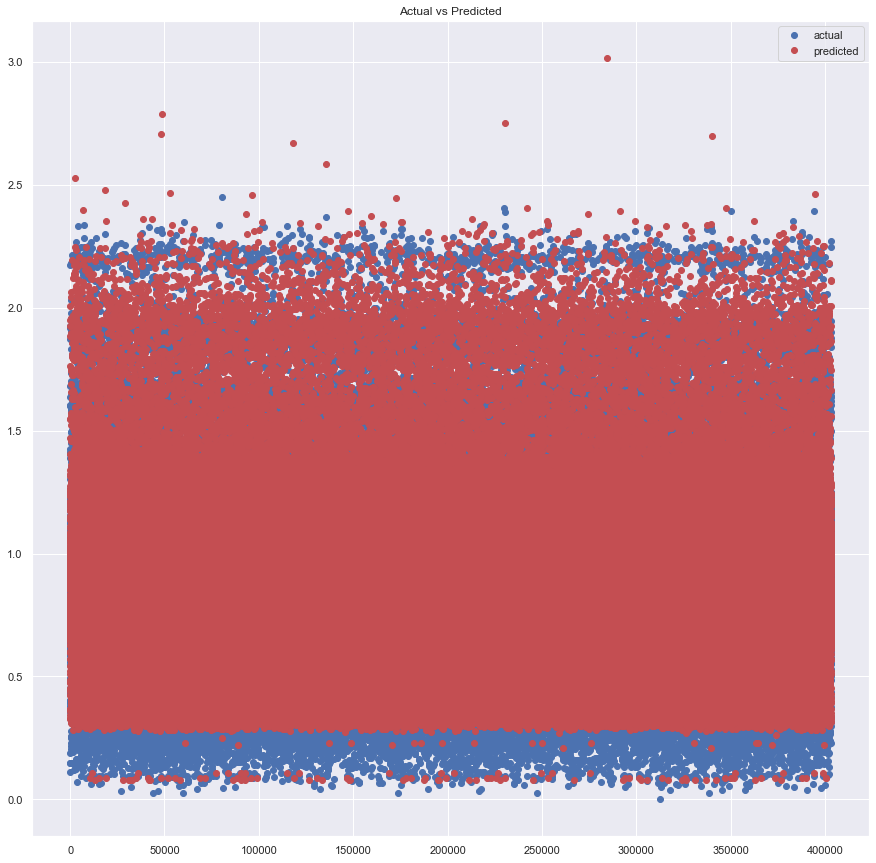

In [ ]:
plt.figure(figsize=(15,15))

plt.plot(y_train3, 'bo', label='actual')
plt.plot(y_pred3, 'ro', label='predicted')
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

In [ ]:
mse, rmse = mlp3.evaluate(X_train3, y_train3, verbose=0)
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Squared Error: {:.4f}'.format(rmse))

Mean Squared Error: 0.0065
Root Mean Squared Error: 0.0809


In [ ]:
MAE = MeanAbsoluteError()
MAE.update_state(y_pred3, y_train3)
print('Mean Absolute Error: {:.4f}'.format(MAE.result().numpy()))

Mean Absolute Error: 0.0469


### 85%-15%

In [ ]:
y_pred4 = mlp4.predict(X_train4)

In [ ]:
y_pred4 = y_pred4.reshape(-1)

In [ ]:
show10results(y_pred4, y_train4)

Result for the 10 random samples:
actual = 0.6311 pred =0.6063
actual = 0.6730 pred =0.7238
actual = 1.1621 pred =1.1846
actual = 0.8936 pred =0.8932
actual = 1.0468 pred =1.0258
actual = 1.9605 pred =1.7383
actual = 0.8334 pred =0.7893
actual = 1.0672 pred =1.0284
actual = 1.1766 pred =0.8039
actual = 0.7470 pred =0.8025


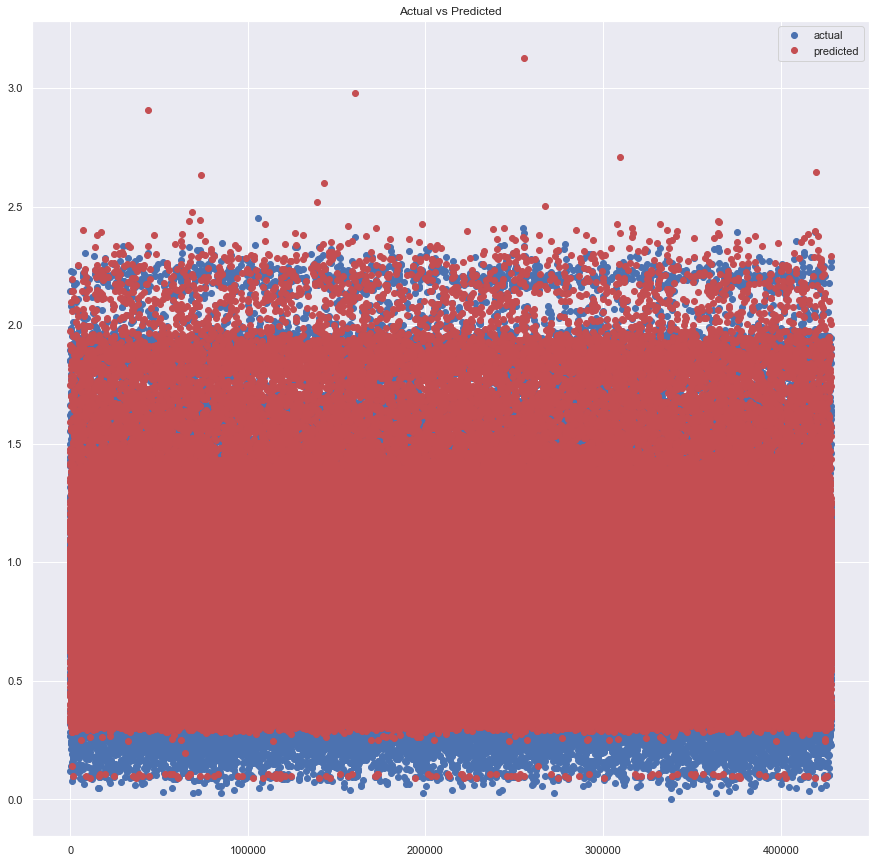

In [ ]:
plt.figure(figsize=(15,15))

plt.plot(y_train4, 'bo', label='actual')
plt.plot(y_pred4, 'ro', label='predicted')
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

In [ ]:
mse, rmse = mlp4.evaluate(X_train4, y_train4, verbose=0)
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Squared Error: {:.4f}'.format(rmse))

Mean Squared Error: 0.0061
Root Mean Squared Error: 0.0780


In [ ]:
MAE = MeanAbsoluteError()
MAE.update_state(y_pred4, y_train4)
print('Mean Absolute Error: {:.4f}'.format(MAE.result().numpy()))

Mean Absolute Error: 0.0451


## 5) Evaluating Model on Test Set

### 70%-30%

In [51]:
y_hat1 = mlp1.predict(X_test1)

In [52]:
y_hat1 = y_hat1.reshape(-1)

In [55]:
show10results(y_hat1, y_test1)

Result for the 10 random samples:
actual = 0.3975 pred =0.4265
actual = 0.8517 pred =0.8636
actual = 0.7599 pred =0.7791
actual = 0.9948 pred =0.9986
actual = 0.9933 pred =0.8194
actual = 0.7374 pred =0.7495
actual = 0.7609 pred =0.7900
actual = 0.8203 pred =0.7845
actual = 0.7562 pred =0.7881
actual = 1.1055 pred =1.1063


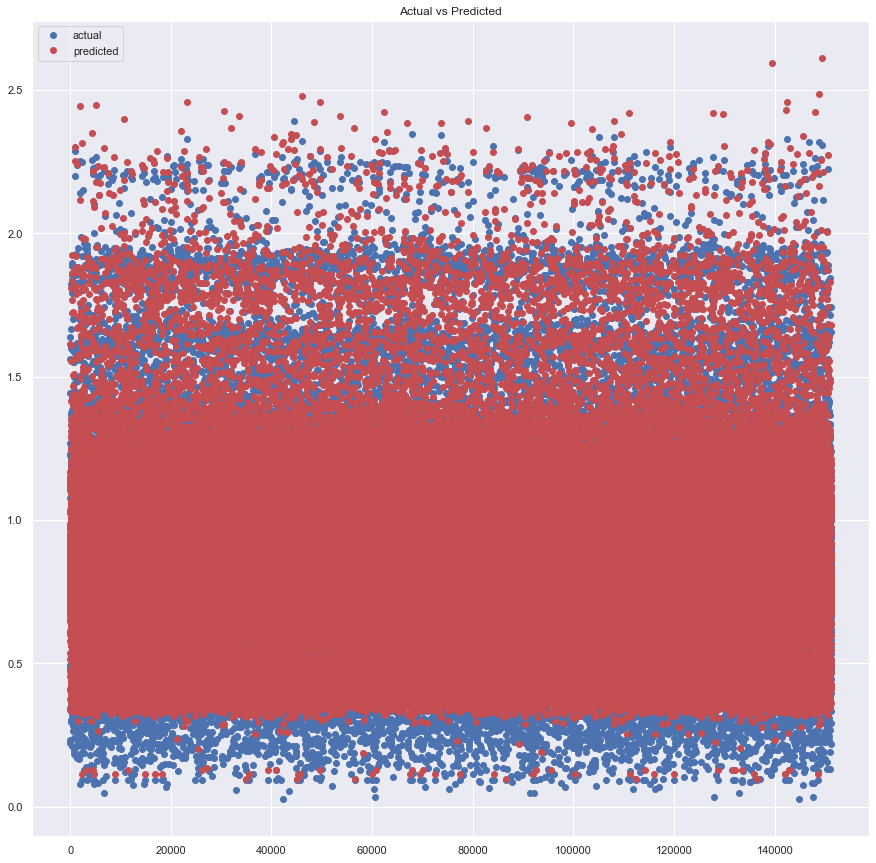

In [59]:
plt.figure(figsize=(15,15))

plt.plot(y_test1, 'bo', label='actual')
plt.plot(y_hat1, 'ro', label='predicted')
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

In [60]:
mse, rmse = mlp1.evaluate(X_test1, y_test1, verbose=0)
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Squared Error: {:.4f}'.format(rmse))

Mean Squared Error: 0.0068
Root Mean Squared Error: 0.0826


In [61]:
MAE = MeanAbsoluteError()
MAE.update_state(y_hat1, y_test1)
print('Mean Absolute Error: {:.4f}'.format(MAE.result().numpy()))

Mean Absolute Error: 0.0471


### 75%-25%

In [69]:
y_hat2 = mlp2.predict(X_test2)

In [70]:
y_hat2 = y_hat2.reshape(-1)

In [71]:
show10results(y_hat2, y_test2)

Result for the 10 random samples:
actual = 0.7640 pred =0.7867
actual = 0.8195 pred =0.8327
actual = 0.6524 pred =0.6975
actual = 0.7319 pred =0.7735
actual = 0.8740 pred =0.8698
actual = 1.0785 pred =1.1082
actual = 0.8462 pred =0.7781
actual = 0.4953 pred =0.4299
actual = 0.9675 pred =0.8102
actual = 0.8206 pred =0.8217


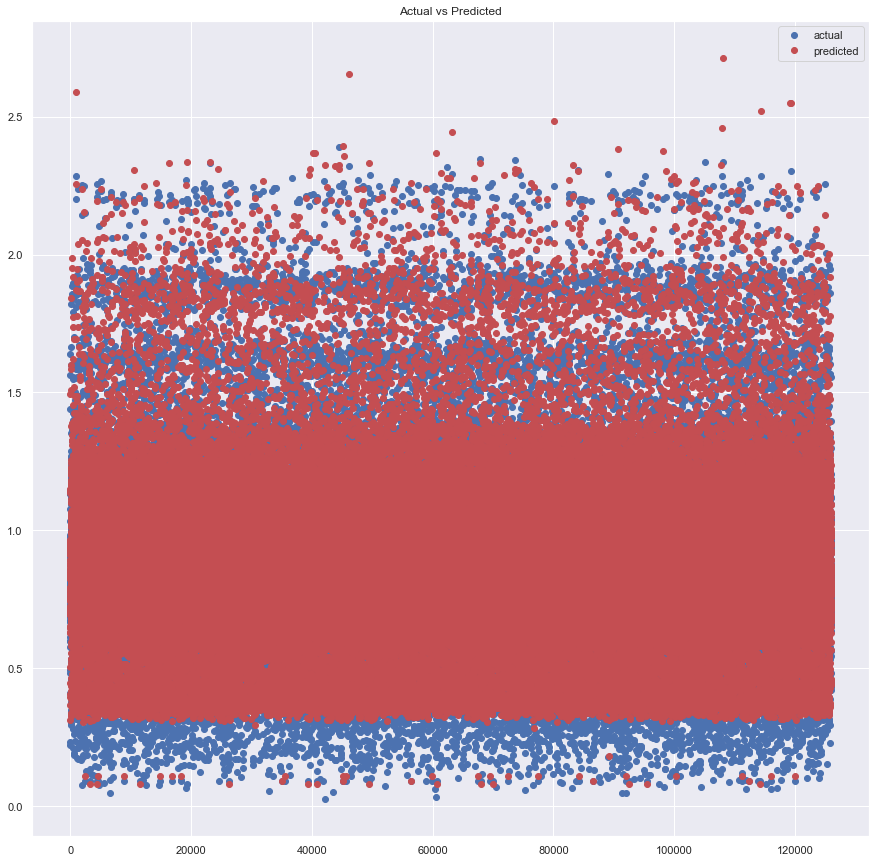

In [72]:
plt.figure(figsize=(15,15))

plt.plot(y_test2, 'bo', label='actual')
plt.plot(y_hat2, 'ro', label='predicted')
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

In [73]:
mse, rmse = mlp2.evaluate(X_test2, y_test2, verbose=0)
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Squared Error: {:.4f}'.format(rmse))

Mean Squared Error: 0.0068
Root Mean Squared Error: 0.0825


In [74]:
MAE = MeanAbsoluteError()
MAE.update_state(y_hat2, y_test2)
print('Mean Absolute Error: {:.4f}'.format(MAE.result().numpy()))

Mean Absolute Error: 0.0470


### 80%-20%

In [77]:
y_hat3 = mlp3.predict(X_test3)

In [78]:
y_hat3 = y_hat3.reshape(-1)

In [79]:
show10results(y_hat3, y_test3)

Result for the 10 random samples:
actual = 1.1387 pred =1.2103
actual = 0.6009 pred =0.6528
actual = 0.7704 pred =0.7972
actual = 0.8846 pred =0.9486
actual = 0.9794 pred =0.9992
actual = 0.7608 pred =0.7875
actual = 0.9653 pred =0.9937
actual = 0.9527 pred =0.9852
actual = 0.6353 pred =0.6372
actual = 0.6952 pred =0.6876


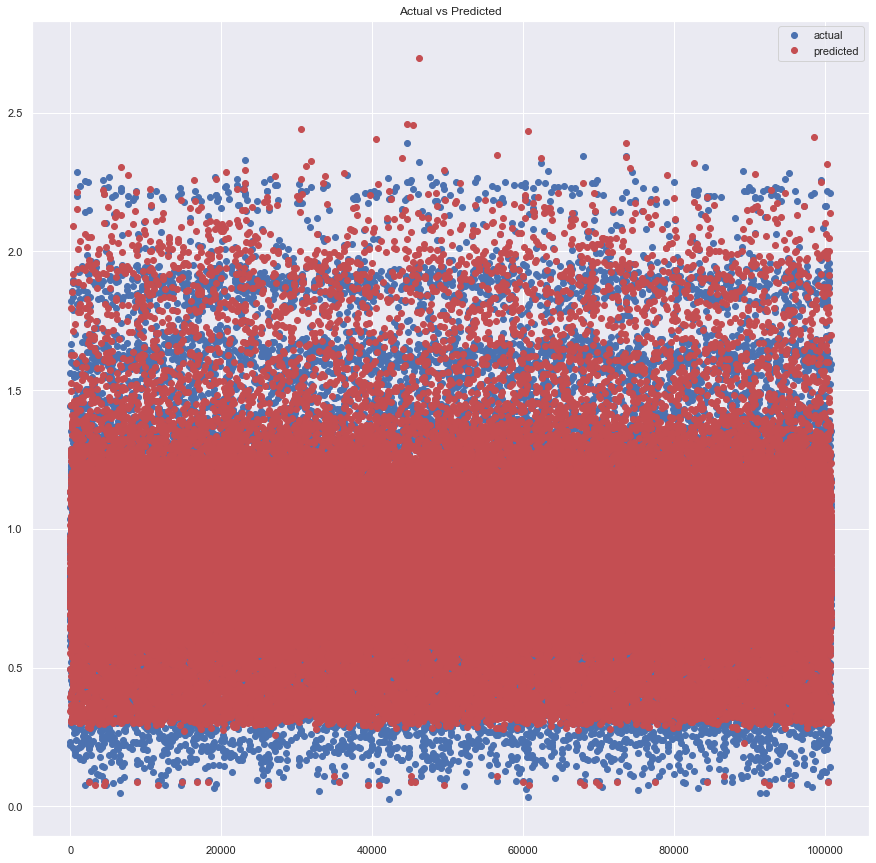

In [80]:
plt.figure(figsize=(15,15))

plt.plot(y_test3, 'bo', label='actual')
plt.plot(y_hat3, 'ro', label='predicted')
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

In [81]:
mse, rmse = mlp3.evaluate(X_test3, y_test3, verbose=0)
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Squared Error: {:.4f}'.format(rmse))

Mean Squared Error: 0.0066
Root Mean Squared Error: 0.0813


In [82]:
MAE = MeanAbsoluteError()
MAE.update_state(y_hat3, y_test3)
print('Mean Absolute Error: {:.4f}'.format(MAE.result().numpy()))

Mean Absolute Error: 0.0470


### 85%-15%

In [83]:
y_hat4 = mlp4.predict(X_test4)

In [84]:
y_hat4 = y_hat4.reshape(-1)

In [85]:
show10results(y_hat4, y_test4)

Result for the 10 random samples:
actual = 0.4094 pred =0.3430
actual = 1.0218 pred =1.0874
actual = 0.5645 pred =0.5466
actual = 0.8097 pred =0.7010
actual = 0.8533 pred =0.7958
actual = 0.7842 pred =0.7247
actual = 0.9501 pred =0.9716
actual = 0.7991 pred =0.8074
actual = 0.9318 pred =0.9932
actual = 0.8535 pred =0.9109


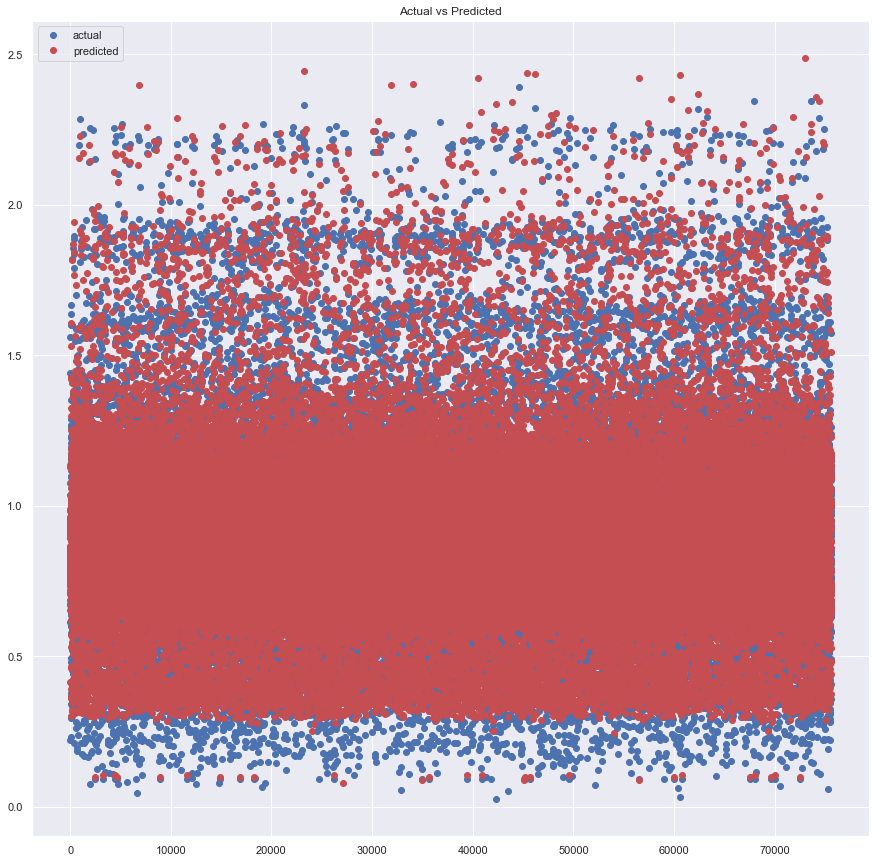

In [86]:
plt.figure(figsize=(15,15))

plt.plot(y_test4, 'bo', label='actual')
plt.plot(y_hat4, 'ro', label='predicted')
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

In [87]:
mse, rmse = mlp4.evaluate(X_test4, y_test4, verbose=0)
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Squared Error: {:.4f}'.format(rmse))

Mean Squared Error: 0.0062
Root Mean Squared Error: 0.0785


In [88]:
MAE = MeanAbsoluteError()
MAE.update_state(y_hat4, y_test4)
print('Mean Absolute Error: {:.4f}'.format(MAE.result().numpy()))

Mean Absolute Error: 0.0452


## 6) Table comparison

In [2]:
array=([[0.0066, 0.0812, 0.0468], [0.0068, 0.0826, 0.0471], [0.0066, 0.0812, 0.0466], [0.0068, 0.0825, 0.0470],
       [0.0065, 0.0809, 0.0469], [0.0066, 0.0813, 0.0470], [0.0061, 0.0780, 0.0451], [0.0062, 0.0785, 0.0452]])
result=pd.DataFrame(data=array, index=['train (Model1)', 'test (Model1)', 'train (Model2)', 'test (Model2)',
                                      'train (Model3)', 'test (Model3)', 'train (Model4)', 'test (Model4)'],
                    columns=['mse', 'rmse', 'mae'])
result

mse    rmse     mae
train (Model1)  0.0066  0.0812  0.0468
test (Model1)   0.0068  0.0826  0.0471
train (Model2)  0.0066  0.0812  0.0466
test (Model2)   0.0068  0.0825  0.0470
train (Model3)  0.0065  0.0809  0.0469
test (Model3)   0.0066  0.0813  0.0470
train (Model4)  0.0061  0.0780  0.0451
test (Model4)   0.0062  0.0785  0.0452

## 7) Fine tune model

### Fine tune number of neurons and layers

In [ ]:
dim_num_layer = Integer(low=1, high=5, name='num_layer')
dim_num_nodes_layer = Integer(low=3, high=30, name='num_nodes_layer')

dimensions = [dim_num_layer, dim_num_nodes_layer]

default_parameters = [3, 26]

In [ ]:
def create_model(num_layer, num_nodes_layer):
  mlp = Sequential()

  mlp.add(InputLayer(input_shape=(26, )))

  for i in range (num_layer):
    mlp.add(Dense(num_nodes_layer, activation="relu"))
  
  mlp.add(Dense(1, activation="relu"))

  opt = SGD(learning_rate=0.001, momentum=0.9)

  mlp.compile(loss="MeanSquaredError", metrics=["RootMeanSquaredError"], optimizer=opt)

  return mlp

In [ ]:
best_RMSE = float('inf')

In [ ]:
@use_named_args(dimensions=dimensions)
def fitness(num_layer, num_nodes_layer):

   #Print the hyperparameter
   print('num_layer:', num_layer)
   print('num_nodes_layer:', num_nodes_layer)
   print()

   #Create model
   mlp = create_model(num_layer=num_layer, num_nodes_layer=num_nodes_layer)

   model = mlp.fit(X_train4, y_train4, epochs=100, verbose=2, batch_size=32, shuffle=True, validation_split=0.18)

   RMSE = model.history['val_root_mean_squared_error'][-1]

   print()
   print("Root Mean Squared Error: {0:.4%}".format(RMSE))
   print()

   global best_RMSE

   if RMSE < best_RMSE:

     mlp.save('fine_tune_model')

     best_RMSE = RMSE

   del mlp

   K.clear_session()

   return RMSE

In [ ]:
%%time
search_result = gp_minimize(func=fitness, dimensions=dimensions, acq_func='EI', n_calls=25, x0=default_parameters)

num_layer: 3
num_nodes_layer: 26

Epoch 1/100
10976/10976 - 9s - loss: 0.0210 - root_mean_squared_error: 0.1450 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1146 - 9s/epoch - 848us/step
Epoch 2/100
10976/10976 - 8s - loss: 0.0116 - root_mean_squared_error: 0.1078 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1032 - 8s/epoch - 774us/step
Epoch 3/100
10976/10976 - 9s - loss: 0.0101 - root_mean_squared_error: 0.1006 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0985 - 9s/epoch - 828us/step
Epoch 4/100
10976/10976 - 9s - loss: 0.0095 - root_mean_squared_error: 0.0975 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0962 - 9s/epoch - 822us/step
Epoch 5/100
10976/10976 - 9s - loss: 0.0091 - root_mean_squared_error: 0.0956 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0946 - 9s/epoch - 808us/step
Epoch 6/100
10976/10976 - 9s - loss: 0.0089 - root_mean_squared_error: 0.0942 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932 - 9s/epoch - 789us/step
Epoch 7/100


10976/10976 - 9s - loss: 0.0067 - root_mean_squared_error: 0.0817 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0819 - 9s/epoch - 837us/step
Epoch 53/100
10976/10976 - 9s - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0823 - 9s/epoch - 835us/step
Epoch 54/100
10976/10976 - 10s - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0823 - 10s/epoch - 877us/step
Epoch 55/100
10976/10976 - 9s - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814 - 9s/epoch - 830us/step
Epoch 56/100
10976/10976 - 9s - loss: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0815 - 9s/epoch - 808us/step
Epoch 57/100
10976/10976 - 9s - loss: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0813 - 9s/epoch - 798us/step
Epoch 58/100
10976/10976 - 9s - loss: 0.0065 - root

Epoch 3/100
10976/10976 - 7s - loss: 0.0135 - root_mean_squared_error: 0.1160 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135 - 7s/epoch - 622us/step
Epoch 4/100
10976/10976 - 7s - loss: 0.0124 - root_mean_squared_error: 0.1112 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096 - 7s/epoch - 626us/step
Epoch 5/100
10976/10976 - 7s - loss: 0.0115 - root_mean_squared_error: 0.1073 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059 - 7s/epoch - 653us/step
Epoch 6/100
10976/10976 - 7s - loss: 0.0109 - root_mean_squared_error: 0.1043 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1032 - 7s/epoch - 639us/step
Epoch 7/100
10976/10976 - 7s - loss: 0.0104 - root_mean_squared_error: 0.1022 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012 - 7s/epoch - 646us/step
Epoch 8/100
10976/10976 - 7s - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1001 - 7s/epoch - 624us/step
Epoch 9/100
10976/10976 - 7s - loss: 0.0100 - 

Epoch 55/100
10976/10976 - 7s - loss: 0.0083 - root_mean_squared_error: 0.0914 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0908 - 7s/epoch - 608us/step
Epoch 56/100
10976/10976 - 7s - loss: 0.0083 - root_mean_squared_error: 0.0913 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909 - 7s/epoch - 620us/step
Epoch 57/100
10976/10976 - 7s - loss: 0.0083 - root_mean_squared_error: 0.0913 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907 - 7s/epoch - 618us/step
Epoch 58/100
10976/10976 - 7s - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0906 - 7s/epoch - 622us/step
Epoch 59/100
10976/10976 - 7s - loss: 0.0083 - root_mean_squared_error: 0.0911 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909 - 7s/epoch - 610us/step
Epoch 60/100
10976/10976 - 7s - loss: 0.0083 - root_mean_squared_error: 0.0911 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0906 - 7s/epoch - 609us/step
Epoch 61/100
10976/10976 - 7s - loss: 0.

Epoch 6/100
10976/10976 - 7s - loss: 0.0097 - root_mean_squared_error: 0.0985 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0976 - 7s/epoch - 639us/step
Epoch 7/100
10976/10976 - 7s - loss: 0.0094 - root_mean_squared_error: 0.0968 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0961 - 7s/epoch - 617us/step
Epoch 8/100
10976/10976 - 7s - loss: 0.0091 - root_mean_squared_error: 0.0955 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0950 - 7s/epoch - 628us/step
Epoch 9/100
10976/10976 - 7s - loss: 0.0089 - root_mean_squared_error: 0.0945 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0940 - 7s/epoch - 619us/step
Epoch 10/100
10976/10976 - 7s - loss: 0.0088 - root_mean_squared_error: 0.0937 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0935 - 7s/epoch - 622us/step
Epoch 11/100
10976/10976 - 7s - loss: 0.0087 - root_mean_squared_error: 0.0931 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927 - 7s/epoch - 632us/step
Epoch 12/100
10976/10976 - 7s - loss: 0.0086

Epoch 58/100
10976/10976 - 7s - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0838 - 7s/epoch - 629us/step
Epoch 59/100
10976/10976 - 7s - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837 - 7s/epoch - 626us/step
Epoch 60/100
10976/10976 - 9s - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837 - 9s/epoch - 810us/step
Epoch 61/100
10976/10976 - 8s - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0836 - 8s/epoch - 771us/step
Epoch 62/100
10976/10976 - 8s - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0835 - 8s/epoch - 697us/step
Epoch 63/100
10976/10976 - 7s - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0835 - 7s/epoch - 631us/step
Epoch 64/100
10976/10976 - 7s - loss: 0.

Epoch 9/100
10976/10976 - 7s - loss: 0.0091 - root_mean_squared_error: 0.0955 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0952 - 7s/epoch - 630us/step
Epoch 10/100
10976/10976 - 7s - loss: 0.0090 - root_mean_squared_error: 0.0947 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0944 - 7s/epoch - 625us/step
Epoch 11/100
10976/10976 - 7s - loss: 0.0088 - root_mean_squared_error: 0.0939 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0937 - 7s/epoch - 612us/step
Epoch 12/100
10976/10976 - 7s - loss: 0.0087 - root_mean_squared_error: 0.0933 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932 - 7s/epoch - 646us/step
Epoch 13/100
10976/10976 - 7s - loss: 0.0086 - root_mean_squared_error: 0.0928 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926 - 7s/epoch - 641us/step
Epoch 14/100
10976/10976 - 7s - loss: 0.0085 - root_mean_squared_error: 0.0923 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0923 - 7s/epoch - 640us/step
Epoch 15/100
10976/10976 - 7s - loss: 0.0

Epoch 61/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0857 - 7s/epoch - 620us/step
Epoch 62/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859 - 7s/epoch - 627us/step
Epoch 63/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0858 - 7s/epoch - 630us/step
Epoch 64/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0858 - 7s/epoch - 679us/step
Epoch 65/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856 - 7s/epoch - 641us/step
Epoch 66/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856 - 7s/epoch - 629us/step
Epoch 67/100
10976/10976 - 7s - loss: 0.

Epoch 12/100
10976/10976 - 7s - loss: 0.0080 - root_mean_squared_error: 0.0895 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894 - 7s/epoch - 650us/step
Epoch 13/100
10976/10976 - 7s - loss: 0.0079 - root_mean_squared_error: 0.0891 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0889 - 7s/epoch - 635us/step
Epoch 14/100
10976/10976 - 7s - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887 - 7s/epoch - 652us/step
Epoch 15/100
10976/10976 - 7s - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0881 - 7s/epoch - 650us/step
Epoch 16/100
10976/10976 - 7s - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0879 - 7s/epoch - 658us/step
Epoch 17/100
10976/10976 - 7s - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0875 - 7s/epoch - 652us/step
Epoch 18/100
10976/10976 - 7s - loss: 0.

Epoch 64/100
10976/10976 - 7s - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0810 - 7s/epoch - 651us/step
Epoch 65/100
10976/10976 - 7s - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808 - 7s/epoch - 647us/step
Epoch 66/100
10976/10976 - 7s - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808 - 7s/epoch - 675us/step
Epoch 67/100
10976/10976 - 7s - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0806 - 7s/epoch - 654us/step
Epoch 68/100
10976/10976 - 7s - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0805 - 7s/epoch - 680us/step
Epoch 69/100
10976/10976 - 7s - loss: 0.0065 - root_mean_squared_error: 0.0804 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0805 - 7s/epoch - 640us/step
Epoch 70/100
10976/10976 - 7s - loss: 0.

Epoch 15/100
10976/10976 - 8s - loss: 0.0078 - root_mean_squared_error: 0.0882 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0880 - 8s/epoch - 703us/step
Epoch 16/100
10976/10976 - 7s - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0878 - 7s/epoch - 680us/step
Epoch 17/100
10976/10976 - 8s - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874 - 8s/epoch - 773us/step
Epoch 18/100
10976/10976 - 8s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871 - 8s/epoch - 712us/step
Epoch 19/100
10976/10976 - 8s - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0869 - 8s/epoch - 714us/step
Epoch 20/100
10976/10976 - 9s - loss: 0.0076 - root_mean_squared_error: 0.0869 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867 - 9s/epoch - 803us/step
Epoch 21/100
10976/10976 - 8s - loss: 0.

Epoch 67/100
10976/10976 - 8s - loss: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0820 - 8s/epoch - 705us/step
Epoch 68/100
10976/10976 - 8s - loss: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0809 - 8s/epoch - 728us/step
Epoch 69/100
10976/10976 - 8s - loss: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0812 - 8s/epoch - 742us/step
Epoch 70/100
10976/10976 - 8s - loss: 0.0065 - root_mean_squared_error: 0.0809 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0812 - 8s/epoch - 711us/step
Epoch 71/100
10976/10976 - 8s - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0813 - 8s/epoch - 720us/step
Epoch 72/100
10976/10976 - 8s - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0807 - 8s/epoch - 751us/step
Epoch 73/100
10976/10976 - 8s - loss: 0.

Epoch 18/100
10976/10976 - 7s - loss: 0.0082 - root_mean_squared_error: 0.0905 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898 - 7s/epoch - 657us/step
Epoch 19/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895 - 7s/epoch - 658us/step
Epoch 20/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893 - 7s/epoch - 652us/step
Epoch 21/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0892 - 7s/epoch - 665us/step
Epoch 22/100
10976/10976 - 7s - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888 - 7s/epoch - 667us/step
Epoch 23/100
10976/10976 - 7s - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887 - 7s/epoch - 643us/step
Epoch 24/100
10976/10976 - 7s - loss: 0.

Epoch 70/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850 - 7s/epoch - 658us/step
Epoch 71/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0851 - 7s/epoch - 666us/step
Epoch 72/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852 - 7s/epoch - 643us/step
Epoch 73/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850 - 7s/epoch - 648us/step
Epoch 74/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0851 - 7s/epoch - 663us/step
Epoch 75/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850 - 7s/epoch - 655us/step
Epoch 76/100
10976/10976 - 7s - loss: 0.

Epoch 21/100
10976/10976 - 7s - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0914 - 7s/epoch - 676us/step
Epoch 22/100
10976/10976 - 7s - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0913 - 7s/epoch - 670us/step
Epoch 23/100
10976/10976 - 8s - loss: 0.0084 - root_mean_squared_error: 0.0916 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0910 - 8s/epoch - 718us/step
Epoch 24/100
10976/10976 - 7s - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0911 - 7s/epoch - 678us/step
Epoch 25/100
10976/10976 - 7s - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909 - 7s/epoch - 678us/step
Epoch 26/100
10976/10976 - 7s - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904 - 7s/epoch - 677us/step
Epoch 27/100
10976/10976 - 7s - loss: 0.

Epoch 73/100
10976/10976 - 7s - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0831 - 7s/epoch - 682us/step
Epoch 74/100
10976/10976 - 8s - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0830 - 8s/epoch - 687us/step
Epoch 75/100
10976/10976 - 7s - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0830 - 7s/epoch - 669us/step
Epoch 76/100
10976/10976 - 7s - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0830 - 7s/epoch - 675us/step
Epoch 77/100
10976/10976 - 7s - loss: 0.0069 - root_mean_squared_error: 0.0830 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0828 - 7s/epoch - 669us/step
Epoch 78/100
10976/10976 - 7s - loss: 0.0069 - root_mean_squared_error: 0.0830 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0827 - 7s/epoch - 671us/step
Epoch 79/100
10976/10976 - 7s - loss: 0.

Epoch 24/100
10976/10976 - 7s - loss: 0.0098 - root_mean_squared_error: 0.0992 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0989 - 7s/epoch - 659us/step
Epoch 25/100
10976/10976 - 7s - loss: 0.0098 - root_mean_squared_error: 0.0991 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0994 - 7s/epoch - 648us/step
Epoch 26/100
10976/10976 - 7s - loss: 0.0098 - root_mean_squared_error: 0.0989 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0993 - 7s/epoch - 659us/step
Epoch 27/100
10976/10976 - 7s - loss: 0.0097 - root_mean_squared_error: 0.0987 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0993 - 7s/epoch - 654us/step
Epoch 28/100
10976/10976 - 7s - loss: 0.0097 - root_mean_squared_error: 0.0984 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0983 - 7s/epoch - 651us/step
Epoch 29/100
10976/10976 - 7s - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0978 - 7s/epoch - 651us/step
Epoch 30/100
10976/10976 - 7s - loss: 0.

Epoch 76/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897 - 7s/epoch - 653us/step
Epoch 77/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894 - 7s/epoch - 647us/step
Epoch 78/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896 - 7s/epoch - 624us/step
Epoch 79/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893 - 7s/epoch - 649us/step
Epoch 80/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0892 - 7s/epoch - 639us/step
Epoch 81/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893 - 7s/epoch - 644us/step
Epoch 82/100
10976/10976 - 7s - loss: 0.

Epoch 27/100
10976/10976 - 7s - loss: 0.0079 - root_mean_squared_error: 0.0891 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0892 - 7s/epoch - 649us/step
Epoch 28/100
10976/10976 - 7s - loss: 0.0079 - root_mean_squared_error: 0.0889 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0889 - 7s/epoch - 647us/step
Epoch 29/100
10976/10976 - 7s - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888 - 7s/epoch - 647us/step
Epoch 30/100
10976/10976 - 7s - loss: 0.0078 - root_mean_squared_error: 0.0886 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894 - 7s/epoch - 665us/step
Epoch 31/100
10976/10976 - 7s - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884 - 7s/epoch - 667us/step
Epoch 32/100
10976/10976 - 7s - loss: 0.0078 - root_mean_squared_error: 0.0882 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0882 - 7s/epoch - 635us/step
Epoch 33/100
10976/10976 - 7s - loss: 0.

Epoch 79/100
10976/10976 - 7s - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0809 - 7s/epoch - 654us/step
Epoch 80/100
10976/10976 - 7s - loss: 0.0065 - root_mean_squared_error: 0.0804 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0806 - 7s/epoch - 665us/step
Epoch 81/100
10976/10976 - 7s - loss: 0.0065 - root_mean_squared_error: 0.0804 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0804 - 7s/epoch - 659us/step
Epoch 82/100
10976/10976 - 7s - loss: 0.0064 - root_mean_squared_error: 0.0803 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0803 - 7s/epoch - 652us/step
Epoch 83/100
10976/10976 - 7s - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0803 - 7s/epoch - 659us/step
Epoch 84/100
10976/10976 - 7s - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0806 - 7s/epoch - 658us/step
Epoch 85/100
10976/10976 - 7s - loss: 0.

Epoch 30/100
10976/10976 - 8s - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848 - 8s/epoch - 701us/step
Epoch 31/100
10976/10976 - 8s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0847 - 8s/epoch - 694us/step
Epoch 32/100
10976/10976 - 8s - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844 - 8s/epoch - 694us/step
Epoch 33/100
10976/10976 - 8s - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849 - 8s/epoch - 689us/step
Epoch 34/100
10976/10976 - 8s - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0841 - 8s/epoch - 686us/step
Epoch 35/100
10976/10976 - 8s - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0843 - 8s/epoch - 706us/step
Epoch 36/100
10976/10976 - 8s - loss: 0.

Epoch 82/100
10976/10976 - 8s - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818 - 8s/epoch - 694us/step
Epoch 83/100
10976/10976 - 8s - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0806 - 8s/epoch - 692us/step
Epoch 84/100
10976/10976 - 8s - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808 - 8s/epoch - 701us/step
Epoch 85/100
10976/10976 - 8s - loss: 0.0065 - root_mean_squared_error: 0.0804 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0806 - 8s/epoch - 711us/step
Epoch 86/100
10976/10976 - 8s - loss: 0.0065 - root_mean_squared_error: 0.0803 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0807 - 8s/epoch - 691us/step
Epoch 87/100
10976/10976 - 8s - loss: 0.0064 - root_mean_squared_error: 0.0803 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0805 - 8s/epoch - 699us/step
Epoch 88/100
10976/10976 - 8s - loss: 0.

Epoch 33/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896 - 7s/epoch - 618us/step
Epoch 34/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895 - 7s/epoch - 611us/step
Epoch 35/100
10976/10976 - 7s - loss: 0.0080 - root_mean_squared_error: 0.0897 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895 - 7s/epoch - 628us/step
Epoch 36/100
10976/10976 - 7s - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894 - 7s/epoch - 619us/step
Epoch 37/100
10976/10976 - 7s - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894 - 7s/epoch - 619us/step
Epoch 38/100
10976/10976 - 7s - loss: 0.0080 - root_mean_squared_error: 0.0895 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0892 - 7s/epoch - 619us/step
Epoch 39/100
10976/10976 - 7s - loss: 0.

Epoch 85/100
10976/10976 - 7s - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0841 - 7s/epoch - 632us/step
Epoch 86/100
10976/10976 - 7s - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837 - 7s/epoch - 623us/step
Epoch 87/100
10976/10976 - 7s - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0836 - 7s/epoch - 646us/step
Epoch 88/100
10976/10976 - 7s - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837 - 7s/epoch - 646us/step
Epoch 89/100
10976/10976 - 7s - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0836 - 7s/epoch - 655us/step
Epoch 90/100
10976/10976 - 7s - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0835 - 7s/epoch - 622us/step
Epoch 91/100
10976/10976 - 7s - loss: 0.

Epoch 36/100
10976/10976 - 8s - loss: 0.0067 - root_mean_squared_error: 0.0819 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0823 - 8s/epoch - 691us/step
Epoch 37/100
10976/10976 - 8s - loss: 0.0067 - root_mean_squared_error: 0.0817 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0820 - 8s/epoch - 754us/step
Epoch 38/100
10976/10976 - 8s - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818 - 8s/epoch - 742us/step
Epoch 39/100
10976/10976 - 8s - loss: 0.0066 - root_mean_squared_error: 0.0815 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0822 - 8s/epoch - 740us/step
Epoch 40/100
10976/10976 - 7s - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0817 - 7s/epoch - 680us/step
Epoch 41/100
10976/10976 - 8s - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0816 - 8s/epoch - 688us/step
Epoch 42/100
10976/10976 - 8s - loss: 0.

Epoch 88/100
10976/10976 - 8s - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0785 - 8s/epoch - 697us/step
Epoch 89/100
10976/10976 - 8s - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793 - 8s/epoch - 698us/step
Epoch 90/100
10976/10976 - 8s - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0785 - 8s/epoch - 697us/step
Epoch 91/100
10976/10976 - 8s - loss: 0.0061 - root_mean_squared_error: 0.0778 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0784 - 8s/epoch - 696us/step
Epoch 92/100
10976/10976 - 8s - loss: 0.0060 - root_mean_squared_error: 0.0778 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0791 - 8s/epoch - 700us/step
Epoch 93/100
10976/10976 - 8s - loss: 0.0060 - root_mean_squared_error: 0.0777 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0783 - 8s/epoch - 702us/step
Epoch 94/100
10976/10976 - 8s - loss: 0.

Epoch 39/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 715us/step
Epoch 40/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 751us/step
Epoch 41/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 734us/step
Epoch 42/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 688us/step
Epoch 43/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 719us/step
Epoch 44/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 694us/step
Epoch 45/100
10976/10976 - 8s - loss: 0.

Epoch 91/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 691us/step
Epoch 92/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 702us/step
Epoch 93/100
10976/10976 - 7s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 7s/epoch - 678us/step
Epoch 94/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 687us/step
Epoch 95/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 702us/step
Epoch 96/100
10976/10976 - 7s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 7s/epoch - 678us/step
Epoch 97/100
10976/10976 - 8s - loss: 0.

Epoch 42/100
10976/10976 - 7s - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1045 - 7s/epoch - 598us/step
Epoch 43/100
10976/10976 - 7s - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043 - 7s/epoch - 600us/step
Epoch 44/100
10976/10976 - 7s - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044 - 7s/epoch - 600us/step
Epoch 45/100
10976/10976 - 7s - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1045 - 7s/epoch - 629us/step
Epoch 46/100
10976/10976 - 7s - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042 - 7s/epoch - 606us/step
Epoch 47/100
10976/10976 - 6s - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043 - 6s/epoch - 591us/step
Epoch 48/100
10976/10976 - 6s - loss: 0.

Epoch 94/100
10976/10976 - 7s - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043 - 7s/epoch - 615us/step
Epoch 95/100
10976/10976 - 7s - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1042 - 7s/epoch - 596us/step
Epoch 96/100
10976/10976 - 7s - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042 - 7s/epoch - 601us/step
Epoch 97/100
10976/10976 - 6s - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042 - 6s/epoch - 590us/step
Epoch 98/100
10976/10976 - 7s - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042 - 7s/epoch - 613us/step
Epoch 99/100
10976/10976 - 7s - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1043 - 7s/epoch - 599us/step
Epoch 100/100
10976/10976 - 7s - loss: 0

Epoch 45/100
10976/10976 - 7s - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1032 - 7s/epoch - 646us/step
Epoch 46/100
10976/10976 - 7s - loss: 0.0105 - root_mean_squared_error: 0.1025 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1034 - 7s/epoch - 641us/step
Epoch 47/100
10976/10976 - 7s - loss: 0.0105 - root_mean_squared_error: 0.1026 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1035 - 7s/epoch - 639us/step
Epoch 48/100
10976/10976 - 7s - loss: 0.0105 - root_mean_squared_error: 0.1025 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1032 - 7s/epoch - 638us/step
Epoch 49/100
10976/10976 - 7s - loss: 0.0105 - root_mean_squared_error: 0.1025 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1034 - 7s/epoch - 649us/step
Epoch 50/100
10976/10976 - 7s - loss: 0.0105 - root_mean_squared_error: 0.1025 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031 - 7s/epoch - 653us/step
Epoch 51/100
10976/10976 - 7s - loss: 0.

Epoch 97/100
10976/10976 - 7s - loss: 0.0105 - root_mean_squared_error: 0.1022 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1029 - 7s/epoch - 644us/step
Epoch 98/100
10976/10976 - 7s - loss: 0.0105 - root_mean_squared_error: 0.1023 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1029 - 7s/epoch - 642us/step
Epoch 99/100
10976/10976 - 7s - loss: 0.0104 - root_mean_squared_error: 0.1022 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1029 - 7s/epoch - 647us/step
Epoch 100/100
10976/10976 - 8s - loss: 0.0105 - root_mean_squared_error: 0.1022 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1027 - 8s/epoch - 693us/step

Root Mean Squared Error: 10.2703%

num_layer: 2
num_nodes_layer: 30

Epoch 1/100
10976/10976 - 7s - loss: 0.0190 - root_mean_squared_error: 0.1379 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099 - 7s/epoch - 676us/step
Epoch 2/100
10976/10976 - 7s - loss: 0.0111 - root_mean_squared_error: 0.1056 - val_loss: 0.0105 - val_root_mean_squared_error: 0.

Epoch 48/100
10976/10976 - 7s - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0843 - 7s/epoch - 627us/step
Epoch 49/100
10976/10976 - 7s - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0846 - 7s/epoch - 616us/step
Epoch 50/100
10976/10976 - 7s - loss: 0.0071 - root_mean_squared_error: 0.0842 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0840 - 7s/epoch - 631us/step
Epoch 51/100
10976/10976 - 7s - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0841 - 7s/epoch - 628us/step
Epoch 52/100
10976/10976 - 7s - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0838 - 7s/epoch - 654us/step
Epoch 53/100
10976/10976 - 7s - loss: 0.0070 - root_mean_squared_error: 0.0840 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0840 - 7s/epoch - 646us/step
Epoch 54/100
10976/10976 - 7s - loss: 0.

Epoch 100/100
10976/10976 - 7s - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0807 - 7s/epoch - 624us/step

Root Mean Squared Error: 8.0707%

num_layer: 1
num_nodes_layer: 18

Epoch 1/100
10976/10976 - 7s - loss: 0.0394 - root_mean_squared_error: 0.1984 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1230 - 7s/epoch - 644us/step
Epoch 2/100
10976/10976 - 7s - loss: 0.0141 - root_mean_squared_error: 0.1188 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1160 - 7s/epoch - 602us/step
Epoch 3/100
10976/10976 - 7s - loss: 0.0129 - root_mean_squared_error: 0.1134 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1115 - 7s/epoch - 598us/step
Epoch 4/100
10976/10976 - 7s - loss: 0.0121 - root_mean_squared_error: 0.1099 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087 - 7s/epoch - 613us/step
Epoch 5/100
10976/10976 - 7s - loss: 0.0116 - root_mean_squared_error: 0.1075 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1065

Epoch 51/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899 - 7s/epoch - 631us/step
Epoch 52/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898 - 7s/epoch - 609us/step
Epoch 53/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0899 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0903 - 7s/epoch - 622us/step
Epoch 54/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0899 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0901 - 7s/epoch - 609us/step
Epoch 55/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897 - 7s/epoch - 614us/step
Epoch 56/100
10976/10976 - 7s - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902 - 7s/epoch - 606us/step
Epoch 57/100
10976/10976 - 7s - loss: 0.

Epoch 2/100
10976/10976 - 7s - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1296 - 7s/epoch - 645us/step
Epoch 3/100
10976/10976 - 7s - loss: 0.0165 - root_mean_squared_error: 0.1283 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1278 - 7s/epoch - 669us/step
Epoch 4/100
10976/10976 - 7s - loss: 0.0161 - root_mean_squared_error: 0.1270 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1272 - 7s/epoch - 672us/step
Epoch 5/100
10976/10976 - 7s - loss: 0.0159 - root_mean_squared_error: 0.1261 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1261 - 7s/epoch - 671us/step
Epoch 6/100
10976/10976 - 7s - loss: 0.0156 - root_mean_squared_error: 0.1251 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1250 - 7s/epoch - 672us/step
Epoch 7/100
10976/10976 - 7s - loss: 0.0154 - root_mean_squared_error: 0.1239 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1240 - 7s/epoch - 669us/step
Epoch 8/100
10976/10976 - 7s - loss: 0.0151 - 

Epoch 54/100
10976/10976 - 7s - loss: 0.0107 - root_mean_squared_error: 0.1034 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1036 - 7s/epoch - 680us/step
Epoch 55/100
10976/10976 - 7s - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038 - 7s/epoch - 677us/step
Epoch 56/100
10976/10976 - 7s - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038 - 7s/epoch - 659us/step
Epoch 57/100
10976/10976 - 8s - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038 - 8s/epoch - 688us/step
Epoch 58/100
10976/10976 - 7s - loss: 0.0106 - root_mean_squared_error: 0.1032 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040 - 7s/epoch - 679us/step
Epoch 59/100
10976/10976 - 8s - loss: 0.0107 - root_mean_squared_error: 0.1032 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046 - 8s/epoch - 754us/step
Epoch 60/100
10976/10976 - 8s - loss: 0.

Epoch 5/100
10976/10976 - 7s - loss: 0.0103 - root_mean_squared_error: 0.1016 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1007 - 7s/epoch - 638us/step
Epoch 6/100
10976/10976 - 7s - loss: 0.0099 - root_mean_squared_error: 0.0994 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0989 - 7s/epoch - 646us/step
Epoch 7/100
10976/10976 - 7s - loss: 0.0096 - root_mean_squared_error: 0.0979 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0976 - 7s/epoch - 639us/step
Epoch 8/100
10976/10976 - 7s - loss: 0.0093 - root_mean_squared_error: 0.0967 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0963 - 7s/epoch - 676us/step
Epoch 9/100
10976/10976 - 7s - loss: 0.0092 - root_mean_squared_error: 0.0957 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0954 - 7s/epoch - 677us/step
Epoch 10/100
10976/10976 - 7s - loss: 0.0090 - root_mean_squared_error: 0.0949 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0947 - 7s/epoch - 646us/step
Epoch 11/100
10976/10976 - 7s - loss: 0.0089 

Epoch 57/100
10976/10976 - 7s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0861 - 7s/epoch - 650us/step
Epoch 58/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0858 - 7s/epoch - 683us/step
Epoch 59/100
10976/10976 - 8s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856 - 8s/epoch - 700us/step
Epoch 60/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856 - 7s/epoch - 668us/step
Epoch 61/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0855 - 7s/epoch - 630us/step
Epoch 62/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0854 - 7s/epoch - 663us/step
Epoch 63/100
10976/10976 - 7s - loss: 0.

Epoch 8/100
10976/10976 - 8s - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0901 - 8s/epoch - 699us/step
Epoch 9/100
10976/10976 - 8s - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894 - 8s/epoch - 703us/step
Epoch 10/100
10976/10976 - 8s - loss: 0.0080 - root_mean_squared_error: 0.0895 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890 - 8s/epoch - 686us/step
Epoch 11/100
10976/10976 - 8s - loss: 0.0079 - root_mean_squared_error: 0.0889 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0883 - 8s/epoch - 695us/step
Epoch 12/100
10976/10976 - 7s - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0879 - 7s/epoch - 667us/step
Epoch 13/100
10976/10976 - 8s - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0875 - 8s/epoch - 697us/step
Epoch 14/100
10976/10976 - 7s - loss: 0.00

Epoch 60/100
10976/10976 - 8s - loss: 0.0063 - root_mean_squared_error: 0.0791 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0791 - 8s/epoch - 738us/step
Epoch 61/100
10976/10976 - 8s - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0791 - 8s/epoch - 744us/step
Epoch 62/100
10976/10976 - 9s - loss: 0.0062 - root_mean_squared_error: 0.0788 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0791 - 9s/epoch - 775us/step
Epoch 63/100
10976/10976 - 8s - loss: 0.0062 - root_mean_squared_error: 0.0787 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0788 - 8s/epoch - 721us/step
Epoch 64/100
10976/10976 - 8s - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0791 - 8s/epoch - 724us/step
Epoch 65/100
10976/10976 - 8s - loss: 0.0062 - root_mean_squared_error: 0.0785 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789 - 8s/epoch - 685us/step
Epoch 66/100
10976/10976 - 8s - loss: 0.

Epoch 11/100
10976/10976 - 7s - loss: 0.0090 - root_mean_squared_error: 0.0948 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0947 - 7s/epoch - 677us/step
Epoch 12/100
10976/10976 - 7s - loss: 0.0089 - root_mean_squared_error: 0.0944 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0939 - 7s/epoch - 680us/step
Epoch 13/100
10976/10976 - 7s - loss: 0.0088 - root_mean_squared_error: 0.0940 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0935 - 7s/epoch - 669us/step
Epoch 14/100
10976/10976 - 8s - loss: 0.0088 - root_mean_squared_error: 0.0935 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932 - 8s/epoch - 689us/step
Epoch 15/100
10976/10976 - 7s - loss: 0.0087 - root_mean_squared_error: 0.0931 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932 - 7s/epoch - 670us/step
Epoch 16/100
10976/10976 - 7s - loss: 0.0086 - root_mean_squared_error: 0.0928 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927 - 7s/epoch - 669us/step
Epoch 17/100
10976/10976 - 8s - loss: 0.

Epoch 63/100
10976/10976 - 7s - loss: 0.0074 - root_mean_squared_error: 0.0858 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860 - 7s/epoch - 680us/step
Epoch 64/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0857 - 7s/epoch - 677us/step
Epoch 65/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0857 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856 - 7s/epoch - 682us/step
Epoch 66/100
10976/10976 - 8s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0857 - 8s/epoch - 689us/step
Epoch 67/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0854 - 7s/epoch - 675us/step
Epoch 68/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860 - 7s/epoch - 673us/step
Epoch 69/100
10976/10976 - 7s - loss: 0.

C:\Users\User\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


10976/10976 - 8s - loss: 0.0317 - root_mean_squared_error: 0.1781 - val_loss: 0.0190 - val_root_mean_squared_error: 0.1377 - 8s/epoch - 762us/step
Epoch 2/100
10976/10976 - 7s - loss: 0.0155 - root_mean_squared_error: 0.1245 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1158 - 7s/epoch - 677us/step
Epoch 3/100
10976/10976 - 7s - loss: 0.0124 - root_mean_squared_error: 0.1115 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1094 - 7s/epoch - 680us/step
Epoch 4/100
10976/10976 - 8s - loss: 0.0114 - root_mean_squared_error: 0.1066 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1054 - 8s/epoch - 693us/step
Epoch 5/100
10976/10976 - 7s - loss: 0.0108 - root_mean_squared_error: 0.1038 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1034 - 7s/epoch - 676us/step
Epoch 6/100
10976/10976 - 7s - loss: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1014 - 7s/epoch - 681us/step
Epoch 7/100
10976/10976 - 7s - loss: 0.0101 - root_mean_sq

Epoch 53/100
10976/10976 - 7s - loss: 0.0079 - root_mean_squared_error: 0.0890 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888 - 7s/epoch - 683us/step
Epoch 54/100
10976/10976 - 7s - loss: 0.0079 - root_mean_squared_error: 0.0889 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887 - 7s/epoch - 677us/step
Epoch 55/100
10976/10976 - 7s - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0886 - 7s/epoch - 668us/step
Epoch 56/100
10976/10976 - 7s - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0886 - 7s/epoch - 681us/step
Epoch 57/100
10976/10976 - 8s - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888 - 8s/epoch - 697us/step
Epoch 58/100
10976/10976 - 7s - loss: 0.0079 - root_mean_squared_error: 0.0886 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891 - 7s/epoch - 651us/step
Epoch 59/100
10976/10976 - 7s - loss: 0.

Epoch 4/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 690us/step
Epoch 5/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 693us/step
Epoch 6/100
10976/10976 - 7s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 7s/epoch - 681us/step
Epoch 7/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 688us/step
Epoch 8/100
10976/10976 - 7s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 7s/epoch - 677us/step
Epoch 9/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 684us/step
Epoch 10/100
10976/10976 - 8s - loss: 0.8243 -

Epoch 56/100
10976/10976 - 7s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 7s/epoch - 677us/step
Epoch 57/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 686us/step
Epoch 58/100
10976/10976 - 7s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 7s/epoch - 678us/step
Epoch 59/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 697us/step
Epoch 60/100
10976/10976 - 8s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 8s/epoch - 685us/step
Epoch 61/100
10976/10976 - 7s - loss: 0.8243 - root_mean_squared_error: 0.9079 - val_loss: 0.8226 - val_root_mean_squared_error: 0.9070 - 7s/epoch - 681us/step
Epoch 62/100
10976/10976 - 7s - loss: 0.

Epoch 7/100
10976/10976 - 7s - loss: 0.0093 - root_mean_squared_error: 0.0962 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0964 - 7s/epoch - 665us/step
Epoch 8/100
10976/10976 - 8s - loss: 0.0090 - root_mean_squared_error: 0.0950 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0952 - 8s/epoch - 689us/step
Epoch 9/100
10976/10976 - 7s - loss: 0.0088 - root_mean_squared_error: 0.0940 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0937 - 7s/epoch - 668us/step
Epoch 10/100
10976/10976 - 7s - loss: 0.0087 - root_mean_squared_error: 0.0931 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927 - 7s/epoch - 670us/step
Epoch 11/100
10976/10976 - 7s - loss: 0.0085 - root_mean_squared_error: 0.0924 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0921 - 7s/epoch - 659us/step
Epoch 12/100
10976/10976 - 7s - loss: 0.0084 - root_mean_squared_error: 0.0917 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915 - 7s/epoch - 663us/step
Epoch 13/100
10976/10976 - 7s - loss: 0.008

Epoch 59/100
10976/10976 - 7s - loss: 0.0070 - root_mean_squared_error: 0.0836 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0838 - 7s/epoch - 655us/step
Epoch 60/100
10976/10976 - 7s - loss: 0.0070 - root_mean_squared_error: 0.0835 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837 - 7s/epoch - 646us/step
Epoch 61/100
10976/10976 - 7s - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837 - 7s/epoch - 621us/step
Epoch 62/100
10976/10976 - 7s - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0832 - 7s/epoch - 625us/step
Epoch 63/100
10976/10976 - 7s - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839 - 7s/epoch - 642us/step
Epoch 64/100
10976/10976 - 8s - loss: 0.0069 - root_mean_squared_error: 0.0831 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0833 - 8s/epoch - 695us/step
Epoch 65/100
10976/10976 - 8s - loss: 0.

In [ ]:
search_result.x

[4, 30]

In [ ]:
search_result.fun

0.07606241106987

In [ ]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(0.07606241106987, [4, 30]),
 (0.07800199836492538, [5, 30]),
 (0.07833017408847809, [3, 26]),
 (0.07849579304456711, [3, 28]),
 (0.07866448909044266, [2, 26]),
 (0.0790112242102623, [4, 26]),
 (0.0790443941950798, [2, 15]),
 (0.07971067726612091, [4, 19]),
 (0.0807073786854744, [2, 30]),
 (0.08141690492630005, [2, 18]),
 (0.08153565973043442, [4, 9]),
 (0.082667775452137, [1, 30]),
 (0.08323699235916138, [3, 15]),
 (0.0839158296585083, [4, 8]),
 (0.08411760628223419, [2, 17]),
 (0.08443327993154526, [2, 15]),
 (0.08679850399494171, [4, 8]),
 (0.08827215433120728, [2, 6]),
 (0.08914612233638763, [2, 7]),
 (0.08918717503547668, [1, 18]),
 (0.10270284861326218, [3, 3]),
 (0.10329972952604294, [4, 3]),
 (0.10419037193059921, [1, 3]),
 (0.906992495059967, [4, 7]),
 (0.906992495059967, [5, 3])]

In [ ]:
mlp = load_model('fine_tune_model')

In [ ]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                810       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3,631
Trainable params: 3,631
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_pred = mlp.predict(X_train4)

In [ ]:
y_pred = y_pred.reshape(-1)

In [ ]:
show10results(y_pred, y_train4)

Result for the 10 random samples:
actual = 0.9408 pred =0.9719
actual = 0.8578 pred =0.8498
actual = 0.9715 pred =0.9384
actual = 0.8368 pred =0.8427
actual = 0.6740 pred =0.7019
actual = 1.1312 pred =1.1148
actual = 0.6732 pred =0.7257
actual = 0.9056 pred =0.9932
actual = 0.6124 pred =0.5713
actual = 0.8998 pred =0.9479


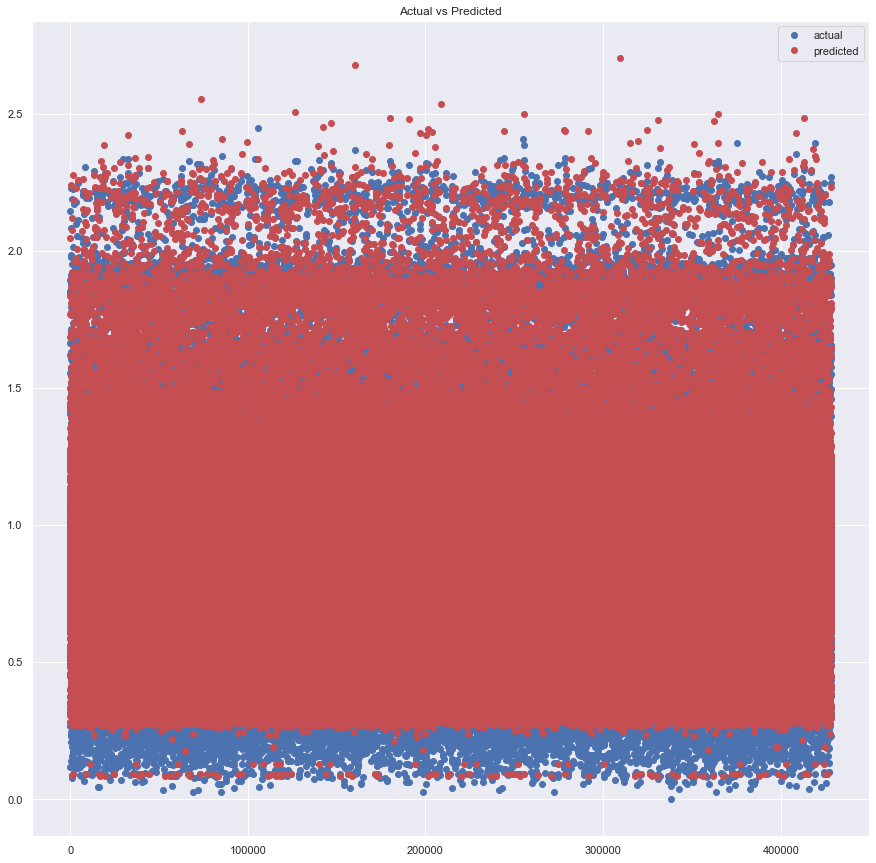

In [ ]:
plt.figure(figsize=(15,15))

plt.plot(y_train4, 'bo', label='actual')
plt.plot(y_pred, 'ro', label='predicted')
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

In [ ]:
mse, rmse = mlp.evaluate(X_train4, y_train4, verbose=0)
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Squared Error: {:.4f}'.format(rmse))

Mean Squared Error: 0.0057
Root Mean Squared Error: 0.0755


In [ ]:
MAE = MeanAbsoluteError()
MAE.update_state(y_pred, y_train4)
print('Mean Absolute Error: {:.4f}'.format(MAE.result().numpy()))

Mean Absolute Error: 0.0441


In [90]:
y_hat = mlp.predict(X_test4)

In [91]:
y_hat = y_hat.reshape(-1)

In [92]:
show10results(y_hat, y_test4)

Result for the 10 random samples:
actual = 0.9262 pred =0.7788
actual = 0.9068 pred =0.9509
actual = 0.8053 pred =0.8498
actual = 0.8154 pred =0.7979
actual = 0.7937 pred =0.8310
actual = 0.6623 pred =0.6393
actual = 1.1712 pred =1.1897
actual = 0.8320 pred =0.8404
actual = 0.7278 pred =0.7748
actual = 0.8344 pred =0.9126


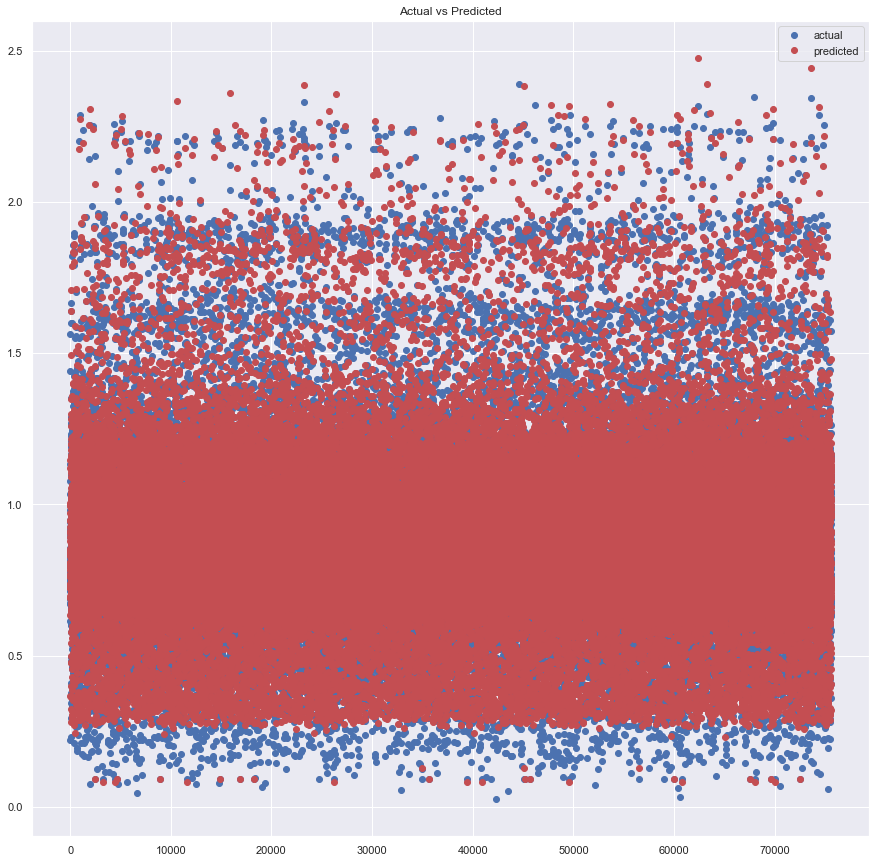

In [95]:
plt.figure(figsize=(15,15))

plt.plot(y_test4, 'bo', label='actual')
plt.plot(y_hat, 'ro', label='predicted')
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

In [96]:
mse, rmse = mlp.evaluate(X_test4, y_test4, verbose=0)
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Squared Error: {:.4f}'.format(rmse))

Mean Squared Error: 0.0058
Root Mean Squared Error: 0.0765


In [97]:
MAE = MeanAbsoluteError()
MAE.update_state(y_hat, y_test4)
print('Mean Absolute Error: {:.4f}'.format(MAE.result().numpy()))

Mean Absolute Error: 0.0444


### Fine tune batch size and epochs

In [ ]:
def evaluate_model(X_train, y_train, batch_size, epochs):
  # Train model
  mlp = Sequential()

  mlp.add(InputLayer(input_shape=(26, )))

  for i in range (4):
    mlp.add(Dense(30, activation="relu"))
  
  mlp.add(Dense(1, activation="relu"))

  opt = SGD(learning_rate=0.001, momentum=0.9)
  callback = EarlyStopping(monitor='val_loss', mode="min", patience=5, verbose=1)

  mlp.compile(loss="MeanSquaredError", metrics=["RootMeanSquaredError"], optimizer=opt)
    
  mlp.fit(x=X_train, y=y_train, epochs=epochs, verbose=2, batch_size=batch_size, callbacks=[callback], shuffle=True, 
                   validation_split=0.18)
  
  # Evaluate model
  _, rmse = mlp.evaluate(X_train, y_train)

  return rmse

In [ ]:
hyperparameters = {'batch_size': [32, 64, 128, 256],
                   'epochs': [10, 20, 50, 100, 120]
}

for i in list(ParameterGrid(hyperparameters)):
    print(i)

{'batch_size': 32, 'epochs': 10}
{'batch_size': 32, 'epochs': 20}
{'batch_size': 32, 'epochs': 50}
{'batch_size': 32, 'epochs': 100}
{'batch_size': 32, 'epochs': 120}
{'batch_size': 64, 'epochs': 10}
{'batch_size': 64, 'epochs': 20}
{'batch_size': 64, 'epochs': 50}
{'batch_size': 64, 'epochs': 100}
{'batch_size': 64, 'epochs': 120}
{'batch_size': 128, 'epochs': 10}
{'batch_size': 128, 'epochs': 20}
{'batch_size': 128, 'epochs': 50}
{'batch_size': 128, 'epochs': 100}
{'batch_size': 128, 'epochs': 120}
{'batch_size': 256, 'epochs': 10}
{'batch_size': 256, 'epochs': 20}
{'batch_size': 256, 'epochs': 50}
{'batch_size': 256, 'epochs': 100}
{'batch_size': 256, 'epochs': 120}


In [ ]:
gridSearch_results_df = pd.DataFrame(columns=['batch_size', 'epochs', 'RMSE score']) 

for i in list(ParameterGrid(hyperparameters)):
    batch_size = i.get('batch_size')
    epochs = i.get('epochs')
    score = evaluate_model(X_train4, y_train4, batch_size, epochs)

    series_values = pd.Series({'batch_size': batch_size, 'epochs': epochs, 'RMSE score': score}) 
    gridSearch_results_df = gridSearch_results_df.append(series_values, ignore_index=True)

Epoch 1/10
10976/10976 - 8s - loss: 0.0194 - root_mean_squared_error: 0.1392 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114 - 8s/epoch - 723us/step
Epoch 2/10
10976/10976 - 7s - loss: 0.0111 - root_mean_squared_error: 0.1055 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1018 - 7s/epoch - 668us/step
Epoch 3/10
10976/10976 - 7s - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979 - 7s/epoch - 659us/step
Epoch 4/10
10976/10976 - 7s - loss: 0.0093 - root_mean_squared_error: 0.0966 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0961 - 7s/epoch - 676us/step
Epoch 5/10
10976/10976 - 8s - loss: 0.0090 - root_mean_squared_error: 0.0947 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0940 - 8s/epoch - 686us/step
Epoch 6/10
10976/10976 - 8s - loss: 0.0087 - root_mean_squared_error: 0.0934 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0929 - 8s/epoch - 691us/step
Epoch 7/10
10976/10976 - 7s - loss: 0.0085 - root_me

Epoch 22/50
10976/10976 - 7s - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852 - 7s/epoch - 675us/step
Epoch 23/50
10976/10976 - 7s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856 - 7s/epoch - 665us/step
Epoch 24/50
10976/10976 - 8s - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849 - 8s/epoch - 707us/step
Epoch 25/50
10976/10976 - 7s - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844 - 7s/epoch - 678us/step
Epoch 26/50
10976/10976 - 7s - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0843 - 7s/epoch - 658us/step
Epoch 27/50
10976/10976 - 7s - loss: 0.0070 - root_mean_squared_error: 0.0838 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0841 - 7s/epoch - 663us/step
Epoch 28/50
10976/10976 - 7s - loss: 0.0070 - 

Epoch 23/100
10976/10976 - 7s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0857 - 7s/epoch - 671us/step
Epoch 24/100
10976/10976 - 9s - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852 - 9s/epoch - 847us/step
Epoch 25/100
10976/10976 - 8s - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856 - 8s/epoch - 759us/step
Epoch 26/100
10976/10976 - 8s - loss: 0.0072 - root_mean_squared_error: 0.0850 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848 - 8s/epoch - 715us/step
Epoch 27/100
10976/10976 - 8s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849 - 8s/epoch - 711us/step
Epoch 28/100
10976/10976 - 8s - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845 - 8s/epoch - 709us/step
Epoch 29/100
10976/10976 - 8s - loss: 0.

Epoch 75/100
10976/10976 - 7s - loss: 0.0063 - root_mean_squared_error: 0.0791 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0795 - 7s/epoch - 678us/step
Epoch 76/100
10976/10976 - 8s - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793 - 8s/epoch - 701us/step
Epoch 77/100
10976/10976 - 8s - loss: 0.0062 - root_mean_squared_error: 0.0789 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0791 - 8s/epoch - 684us/step
Epoch 78/100
10976/10976 - 7s - loss: 0.0062 - root_mean_squared_error: 0.0788 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789 - 7s/epoch - 679us/step
Epoch 79/100
10976/10976 - 7s - loss: 0.0062 - root_mean_squared_error: 0.0787 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0791 - 7s/epoch - 669us/step
Epoch 80/100
10976/10976 - 7s - loss: 0.0062 - root_mean_squared_error: 0.0787 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0786 - 7s/epoch - 672us/step
Epoch 81/100
10976/10976 - 7s - loss: 0.

Epoch 26/120
10976/10976 - 7s - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0846 - 7s/epoch - 667us/step
Epoch 27/120
10976/10976 - 7s - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0843 - 7s/epoch - 664us/step
Epoch 28/120
10976/10976 - 7s - loss: 0.0071 - root_mean_squared_error: 0.0842 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0842 - 7s/epoch - 665us/step
Epoch 29/120
10976/10976 - 7s - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0840 - 7s/epoch - 654us/step
Epoch 30/120
10976/10976 - 8s - loss: 0.0070 - root_mean_squared_error: 0.0839 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0838 - 8s/epoch - 709us/step
Epoch 31/120
10976/10976 - 8s - loss: 0.0070 - root_mean_squared_error: 0.0837 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837 - 8s/epoch - 730us/step
Epoch 32/120
10976/10976 - 8s - loss: 0.

Epoch 78/120
10976/10976 - 7s - loss: 0.0063 - root_mean_squared_error: 0.0791 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0802 - 7s/epoch - 672us/step
Epoch 79/120
10976/10976 - 7s - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0795 - 7s/epoch - 665us/step
Epoch 80/120
10976/10976 - 8s - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0795 - 8s/epoch - 685us/step
Epoch 81/120
10976/10976 - 7s - loss: 0.0062 - root_mean_squared_error: 0.0789 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793 - 7s/epoch - 683us/step
Epoch 82/120
10976/10976 - 9s - loss: 0.0062 - root_mean_squared_error: 0.0788 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0794 - 9s/epoch - 814us/step
Epoch 83/120
10976/10976 - 13s - loss: 0.0062 - root_mean_squared_error: 0.0788 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0795 - 13s/epoch - 1ms/step
Epoch 84/120
10976/10976 - 17s - loss: 0

Epoch 9/10
5488/5488 - 4s - loss: 0.0086 - root_mean_squared_error: 0.0929 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927 - 4s/epoch - 695us/step
Epoch 10/10
5488/5488 - 4s - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0917 - 4s/epoch - 700us/step
13386/13386 [==============================] - 8s 613us/step - loss: 0.0084 - root_mean_squared_error: 0.0917
Epoch 1/20
5488/5488 - 4s - loss: 0.0494 - root_mean_squared_error: 0.2222 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205 - 4s/epoch - 790us/step
Epoch 2/20
5488/5488 - 4s - loss: 0.0129 - root_mean_squared_error: 0.1135 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1081 - 4s/epoch - 786us/step
Epoch 3/20
5488/5488 - 4s - loss: 0.0112 - root_mean_squared_error: 0.1056 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1032 - 4s/epoch - 740us/step
Epoch 4/20
5488/5488 - 4s - loss: 0.0104 - root_mean_squared_error: 0.1018 - val_loss: 0.0100 - val_root_mean

Epoch 30/50
5488/5488 - 4s - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871 - 4s/epoch - 704us/step
Epoch 31/50
5488/5488 - 4s - loss: 0.0076 - root_mean_squared_error: 0.0870 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0870 - 4s/epoch - 683us/step
Epoch 32/50
5488/5488 - 4s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0870 - 4s/epoch - 705us/step
Epoch 33/50
5488/5488 - 4s - loss: 0.0075 - root_mean_squared_error: 0.0866 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0866 - 4s/epoch - 816us/step
Epoch 34/50
5488/5488 - 4s - loss: 0.0075 - root_mean_squared_error: 0.0865 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0863 - 4s/epoch - 781us/step
Epoch 35/50
5488/5488 - 4s - loss: 0.0075 - root_mean_squared_error: 0.0863 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865 - 4s/epoch - 685us/step
Epoch 36/50
5488/5488 - 4s - loss: 0.0074 - root_mean_squa

Epoch 32/100
5488/5488 - 4s - loss: 0.0076 - root_mean_squared_error: 0.0872 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871 - 4s/epoch - 687us/step
Epoch 33/100
5488/5488 - 4s - loss: 0.0076 - root_mean_squared_error: 0.0871 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874 - 4s/epoch - 706us/step
Epoch 34/100
5488/5488 - 4s - loss: 0.0076 - root_mean_squared_error: 0.0869 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0868 - 4s/epoch - 696us/step
Epoch 35/100
5488/5488 - 4s - loss: 0.0075 - root_mean_squared_error: 0.0868 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0869 - 4s/epoch - 699us/step
Epoch 36/100
5488/5488 - 4s - loss: 0.0075 - root_mean_squared_error: 0.0867 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0866 - 4s/epoch - 687us/step
Epoch 37/100
5488/5488 - 4s - loss: 0.0075 - root_mean_squared_error: 0.0865 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865 - 4s/epoch - 689us/step
Epoch 38/100
5488/5488 - 4s - loss: 0.0075 - root_me

Epoch 84/100
5488/5488 - 4s - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0828 - 4s/epoch - 747us/step
Epoch 85/100
5488/5488 - 4s - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0827 - 4s/epoch - 686us/step
Epoch 86/100
5488/5488 - 4s - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0827 - 4s/epoch - 669us/step
Epoch 87/100
5488/5488 - 4s - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0828 - 4s/epoch - 676us/step
Epoch 88/100
5488/5488 - 4s - loss: 0.0068 - root_mean_squared_error: 0.0825 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0826 - 4s/epoch - 673us/step
Epoch 89/100
5488/5488 - 4s - loss: 0.0068 - root_mean_squared_error: 0.0824 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0832 - 4s/epoch - 670us/step
Epoch 90/100
5488/5488 - 4s - loss: 0.0068 - root_me

Epoch 36/120
5488/5488 - 4s - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0854 - 4s/epoch - 745us/step
Epoch 37/120
5488/5488 - 4s - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0853 - 4s/epoch - 694us/step
Epoch 38/120
5488/5488 - 4s - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852 - 4s/epoch - 689us/step
Epoch 39/120
5488/5488 - 4s - loss: 0.0073 - root_mean_squared_error: 0.0852 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850 - 4s/epoch - 715us/step
Epoch 40/120
5488/5488 - 4s - loss: 0.0072 - root_mean_squared_error: 0.0851 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0855 - 4s/epoch - 699us/step
Epoch 41/120
5488/5488 - 4s - loss: 0.0072 - root_mean_squared_error: 0.0850 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848 - 4s/epoch - 687us/step
Epoch 42/120
5488/5488 - 4s - loss: 0.0072 - root_me

Epoch 88/120
5488/5488 - 4s - loss: 0.0066 - root_mean_squared_error: 0.0814 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814 - 4s/epoch - 692us/step
Epoch 89/120
5488/5488 - 4s - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814 - 4s/epoch - 698us/step
Epoch 90/120
5488/5488 - 4s - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814 - 4s/epoch - 723us/step
Epoch 91/120
5488/5488 - 4s - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814 - 4s/epoch - 690us/step
Epoch 92/120
5488/5488 - 4s - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0816 - 4s/epoch - 737us/step
Epoch 93/120
5488/5488 - 4s - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0813 - 4s/epoch - 687us/step
Epoch 94/120
5488/5488 - 4s - loss: 0.0066 - root_me

Epoch 9/20
2744/2744 - 2s - loss: 0.0100 - root_mean_squared_error: 0.0999 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0994 - 2s/epoch - 739us/step
Epoch 10/20
2744/2744 - 2s - loss: 0.0098 - root_mean_squared_error: 0.0989 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0984 - 2s/epoch - 746us/step
Epoch 11/20
2744/2744 - 2s - loss: 0.0096 - root_mean_squared_error: 0.0980 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0976 - 2s/epoch - 737us/step
Epoch 12/20
2744/2744 - 2s - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0968 - 2s/epoch - 734us/step
Epoch 13/20
2744/2744 - 2s - loss: 0.0093 - root_mean_squared_error: 0.0964 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0961 - 2s/epoch - 730us/step
Epoch 14/20
2744/2744 - 2s - loss: 0.0092 - root_mean_squared_error: 0.0958 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0955 - 2s/epoch - 735us/step
Epoch 15/20
2744/2744 - 2s - loss: 0.0091 - root_mean_squar

Epoch 41/50
2744/2744 - 2s - loss: 0.0079 - root_mean_squared_error: 0.0891 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890 - 2s/epoch - 750us/step
Epoch 42/50
2744/2744 - 2s - loss: 0.0079 - root_mean_squared_error: 0.0890 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888 - 2s/epoch - 736us/step
Epoch 43/50
2744/2744 - 2s - loss: 0.0079 - root_mean_squared_error: 0.0889 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888 - 2s/epoch - 738us/step
Epoch 44/50
2744/2744 - 2s - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0886 - 2s/epoch - 733us/step
Epoch 45/50
2744/2744 - 2s - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0886 - 2s/epoch - 732us/step
Epoch 46/50
2744/2744 - 2s - loss: 0.0078 - root_mean_squared_error: 0.0886 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884 - 2s/epoch - 791us/step
Epoch 47/50
2744/2744 - 2s - loss: 0.0078 - root_mean_squa

Epoch 43/100
2744/2744 - 2s - loss: 0.0080 - root_mean_squared_error: 0.0892 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890 - 2s/epoch - 757us/step
Epoch 44/100
2744/2744 - 2s - loss: 0.0079 - root_mean_squared_error: 0.0891 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890 - 2s/epoch - 826us/step
Epoch 45/100
2744/2744 - 2s - loss: 0.0079 - root_mean_squared_error: 0.0890 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888 - 2s/epoch - 777us/step
Epoch 46/100
2744/2744 - 2s - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888 - 2s/epoch - 756us/step
Epoch 47/100
2744/2744 - 2s - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0885 - 2s/epoch - 755us/step
Epoch 48/100
2744/2744 - 2s - loss: 0.0078 - root_mean_squared_error: 0.0886 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0885 - 2s/epoch - 752us/step
Epoch 49/100
2744/2744 - 2s - loss: 0.0078 - root_me

Epoch 95/100
2744/2744 - 2s - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850 - 2s/epoch - 775us/step
Epoch 96/100
2744/2744 - 2s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849 - 2s/epoch - 748us/step
Epoch 97/100
2744/2744 - 2s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848 - 2s/epoch - 748us/step
Epoch 98/100
2744/2744 - 2s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848 - 2s/epoch - 744us/step
Epoch 99/100
2744/2744 - 2s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848 - 2s/epoch - 747us/step
Epoch 100/100
2744/2744 - 2s - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848 - 2s/epoch - 751us/step
13386/13386 [==============================] - 8s 6

Epoch 47/120
2744/2744 - 2s - loss: 0.0078 - root_mean_squared_error: 0.0885 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0889 - 2s/epoch - 742us/step
Epoch 48/120
2744/2744 - 2s - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888 - 2s/epoch - 741us/step
Epoch 49/120
2744/2744 - 2s - loss: 0.0078 - root_mean_squared_error: 0.0882 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0887 - 2s/epoch - 755us/step
Epoch 50/120
2744/2744 - 2s - loss: 0.0078 - root_mean_squared_error: 0.0881 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0886 - 2s/epoch - 745us/step
Epoch 51/120
2744/2744 - 2s - loss: 0.0078 - root_mean_squared_error: 0.0880 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0885 - 2s/epoch - 739us/step
Epoch 52/120
2744/2744 - 2s - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884 - 2s/epoch - 743us/step
Epoch 53/120
2744/2744 - 2s - loss: 0.0077 - root_me

Epoch 99/120
2744/2744 - 2s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0851 - 2s/epoch - 746us/step
Epoch 100/120
2744/2744 - 2s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0851 - 2s/epoch - 771us/step
Epoch 101/120
2744/2744 - 2s - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850 - 2s/epoch - 740us/step
Epoch 102/120
2744/2744 - 2s - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852 - 2s/epoch - 740us/step
Epoch 103/120
2744/2744 - 2s - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849 - 2s/epoch - 741us/step
Epoch 104/120
2744/2744 - 2s - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0848 - 2s/epoch - 741us/step
Epoch 105/120
2744/2744 - 2s - loss: 0.0071 - r

Epoch 20/20
1372/1372 - 1s - loss: 0.0096 - root_mean_squared_error: 0.0978 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0976 - 1s/epoch - 1ms/step
13386/13386 [==============================] - 9s 703us/step - loss: 0.0095 - root_mean_squared_error: 0.0976
Epoch 1/50
1372/1372 - 2s - loss: 0.0411 - root_mean_squared_error: 0.2027 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1515 - 2s/epoch - 1ms/step
Epoch 2/50
1372/1372 - 1s - loss: 0.0201 - root_mean_squared_error: 0.1419 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1343 - 1s/epoch - 867us/step
Epoch 3/50
1372/1372 - 1s - loss: 0.0170 - root_mean_squared_error: 0.1302 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1264 - 1s/epoch - 846us/step
Epoch 4/50
1372/1372 - 1s - loss: 0.0154 - root_mean_squared_error: 0.1240 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1215 - 1s/epoch - 848us/step
Epoch 5/50
1372/1372 - 1s - loss: 0.0144 - root_mean_squared_error: 0.1199 - val_loss: 0.0139 - val_root_mean_squ

Epoch 53/100
1372/1372 - 1s - loss: 0.0085 - root_mean_squared_error: 0.0924 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0923 - 1s/epoch - 917us/step
Epoch 54/100
1372/1372 - 1s - loss: 0.0085 - root_mean_squared_error: 0.0922 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0922 - 1s/epoch - 927us/step
Epoch 55/100
1372/1372 - 1s - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0921 - 1s/epoch - 926us/step
Epoch 56/100
1372/1372 - 1s - loss: 0.0085 - root_mean_squared_error: 0.0920 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0919 - 1s/epoch - 921us/step
Epoch 57/100
1372/1372 - 1s - loss: 0.0084 - root_mean_squared_error: 0.0919 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0918 - 1s/epoch - 919us/step
Epoch 58/100
1372/1372 - 1s - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0917 - 1s/epoch - 980us/step
Epoch 59/100
1372/1372 - 1s - loss: 0.0084 - root_me

Epoch 5/120
1372/1372 - 1s - loss: 0.0143 - root_mean_squared_error: 0.1195 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1176 - 1s/epoch - 901us/step
Epoch 6/120
1372/1372 - 1s - loss: 0.0135 - root_mean_squared_error: 0.1162 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1146 - 1s/epoch - 875us/step
Epoch 7/120
1372/1372 - 1s - loss: 0.0129 - root_mean_squared_error: 0.1135 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123 - 1s/epoch - 902us/step
Epoch 8/120
1372/1372 - 1s - loss: 0.0124 - root_mean_squared_error: 0.1113 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102 - 1s/epoch - 888us/step
Epoch 9/120
1372/1372 - 1s - loss: 0.0120 - root_mean_squared_error: 0.1094 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1084 - 1s/epoch - 869us/step
Epoch 10/120
1372/1372 - 1s - loss: 0.0116 - root_mean_squared_error: 0.1076 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068 - 1s/epoch - 882us/step
Epoch 11/120
1372/1372 - 1s - loss: 0.0113 - root_mean_sq

Epoch 57/120
1372/1372 - 1s - loss: 0.0082 - root_mean_squared_error: 0.0907 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0908 - 1s/epoch - 878us/step
Epoch 58/120
1372/1372 - 1s - loss: 0.0082 - root_mean_squared_error: 0.0906 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907 - 1s/epoch - 898us/step
Epoch 59/120
1372/1372 - 1s - loss: 0.0082 - root_mean_squared_error: 0.0905 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0906 - 1s/epoch - 896us/step
Epoch 60/120
1372/1372 - 1s - loss: 0.0082 - root_mean_squared_error: 0.0904 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0905 - 1s/epoch - 878us/step
Epoch 61/120
1372/1372 - 1s - loss: 0.0082 - root_mean_squared_error: 0.0903 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0905 - 1s/epoch - 885us/step
Epoch 62/120
1372/1372 - 1s - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0903 - 1s/epoch - 883us/step
Epoch 63/120
1372/1372 - 1s - loss: 0.0081 - root_me

Epoch 109/120
1372/1372 - 1s - loss: 0.0077 - root_mean_squared_error: 0.0875 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0877 - 1s/epoch - 878us/step
Epoch 110/120
1372/1372 - 1s - loss: 0.0077 - root_mean_squared_error: 0.0875 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0876 - 1s/epoch - 876us/step
Epoch 111/120
1372/1372 - 1s - loss: 0.0076 - root_mean_squared_error: 0.0875 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0876 - 1s/epoch - 893us/step
Epoch 112/120
1372/1372 - 1s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0875 - 1s/epoch - 884us/step
Epoch 113/120
1372/1372 - 1s - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0875 - 1s/epoch - 868us/step
Epoch 114/120
1372/1372 - 1s - loss: 0.0076 - root_mean_squared_error: 0.0873 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874 - 1s/epoch - 871us/step
Epoch 115/120
1372/1372 - 1s - loss: 0.0076 - 

In [ ]:
gridSearch_results_df

batch_size  epochs  RMSE score
0         32.0    10.0    0.089726
1         32.0    20.0    0.086305
2         32.0    50.0    0.080636
3         32.0   100.0    0.076805
4         32.0   120.0    0.076496
5         64.0    10.0    0.091668
6         64.0    20.0    0.089576
7         64.0    50.0    0.084301
8         64.0   100.0    0.081656
9         64.0   120.0    0.080156
10       128.0    10.0    0.098167
11       128.0    20.0    0.092872
12       128.0    50.0    0.088044
13       128.0   100.0    0.084637
14       128.0   120.0    0.083786
15       256.0    10.0    0.108189
16       256.0    20.0    0.097615
17       256.0    50.0    0.092089
18       256.0   100.0    0.088367
19       256.0   120.0    0.087076

### Fine tune optimizer and learning rate

In [ ]:
def evaluate_model(X_train, y_train, optimizer, learning_rate):
  
  # select optimizer
  opt= {'Adam': Adam(learning_rate=learning_rate), 'Adagrad': Adagrad(learning_rate=learning_rate),
        'SGD': SGD(learning_rate=learning_rate, momentum=0.9), 'RMSprop': RMSprop(learning_rate=learning_rate)}
  Optimizer = opt[optimizer]

  # Train model
  mlp = Sequential()

  mlp.add(InputLayer(input_shape=(26, )))

  for i in range (4):
    mlp.add(Dense(30, activation="relu"))
  
  mlp.add(Dense(1, activation="relu"))
    
  callback = EarlyStopping(monitor='val_loss', mode="min", patience=5, verbose=1)

  mlp.compile(loss="MeanSquaredError", metrics=["RootMeanSquaredError"], optimizer=Optimizer)
    
  mlp.fit(x=X_train, y=y_train, epochs=120, verbose=2, batch_size=32, callbacks=[callback], shuffle=True, validation_split=0.18)

  # Evaluate model
  _, rmse = mlp.evaluate(X_train, y_train)

  return rmse

In [ ]:
hyperparameters = {'optimizer': ['Adam', 'Adagrad', 'SGD', 'RMSprop'],
                   'learning_rate': [0.01, 0.001]
}

for i in list(ParameterGrid(hyperparameters)):
    print(i)

{'learning_rate': 0.01, 'optimizer': 'Adam'}
{'learning_rate': 0.01, 'optimizer': 'Adagrad'}
{'learning_rate': 0.01, 'optimizer': 'SGD'}
{'learning_rate': 0.01, 'optimizer': 'RMSprop'}
{'learning_rate': 0.001, 'optimizer': 'Adam'}
{'learning_rate': 0.001, 'optimizer': 'Adagrad'}
{'learning_rate': 0.001, 'optimizer': 'SGD'}
{'learning_rate': 0.001, 'optimizer': 'RMSprop'}


In [ ]:
gridSearch_results_df = pd.DataFrame(columns=['optimizer', 'learning_rate', 'RMSE score']) 

for i in list(ParameterGrid(hyperparameters)):
    optimizer = i.get('optimizer')
    learning_rate = i.get('learning_rate')
    score = evaluate_model(X_train4, y_train4, optimizer, learning_rate)

    series_values = pd.Series({'optimizer': optimizer, 'learning_rate': learning_rate, 'RMSE score': score}) 
    gridSearch_results_df = gridSearch_results_df.append(series_values, ignore_index=True)

Epoch 1/120
10976/10976 - 9s - loss: 0.0088 - root_mean_squared_error: 0.0938 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0868 - 9s/epoch - 779us/step
Epoch 2/120
10976/10976 - 8s - loss: 0.0071 - root_mean_squared_error: 0.0842 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0811 - 8s/epoch - 728us/step
Epoch 3/120
10976/10976 - 8s - loss: 0.0067 - root_mean_squared_error: 0.0817 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779 - 8s/epoch - 762us/step
Epoch 4/120
10976/10976 - 8s - loss: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0801 - 8s/epoch - 749us/step
Epoch 5/120
10976/10976 - 8s - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0784 - 8s/epoch - 751us/step
Epoch 6/120
10976/10976 - 8s - loss: 0.0063 - root_mean_squared_error: 0.0796 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779 - 8s/epoch - 756us/step
Epoch 7/120
10976/10976 - 8s - loss: 0.0063 - 

Epoch 36/120
10976/10976 - 7s - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808 - 7s/epoch - 661us/step
Epoch 37/120
10976/10976 - 7s - loss: 0.0065 - root_mean_squared_error: 0.0803 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0805 - 7s/epoch - 668us/step
Epoch 38/120
10976/10976 - 8s - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0806 - 8s/epoch - 709us/step
Epoch 39/120
10976/10976 - 9s - loss: 0.0064 - root_mean_squared_error: 0.0801 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0802 - 9s/epoch - 794us/step
Epoch 40/120
10976/10976 - 7s - loss: 0.0064 - root_mean_squared_error: 0.0800 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0802 - 7s/epoch - 670us/step
Epoch 41/120
10976/10976 - 8s - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0800 - 8s/epoch - 695us/step
Epoch 42/120
10976/10976 - 7s - loss: 0.

Epoch 88/120
10976/10976 - 7s - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0760 - 7s/epoch - 678us/step
Epoch 89/120
10976/10976 - 7s - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0759 - 7s/epoch - 660us/step
Epoch 90/120
10976/10976 - 7s - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0759 - 7s/epoch - 654us/step
Epoch 91/120
10976/10976 - 8s - loss: 0.0057 - root_mean_squared_error: 0.0752 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0758 - 8s/epoch - 720us/step
Epoch 92/120
10976/10976 - 8s - loss: 0.0057 - root_mean_squared_error: 0.0752 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0758 - 8s/epoch - 693us/step
Epoch 93/120
10976/10976 - 7s - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0757 - 7s/epoch - 653us/step
Epoch 94/120
10976/10976 - 7s - loss: 0.

Epoch 19/120
10976/10976 - 7s - loss: 0.0057 - root_mean_squared_error: 0.0758 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764 - 7s/epoch - 661us/step
Epoch 20/120
10976/10976 - 7s - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0774 - 7s/epoch - 682us/step
Epoch 21/120
10976/10976 - 7s - loss: 0.0056 - root_mean_squared_error: 0.0750 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0754 - 7s/epoch - 676us/step
Epoch 22/120
10976/10976 - 7s - loss: 0.0056 - root_mean_squared_error: 0.0746 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0744 - 7s/epoch - 674us/step
Epoch 23/120
10976/10976 - 7s - loss: 0.0055 - root_mean_squared_error: 0.0741 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0742 - 7s/epoch - 662us/step
Epoch 24/120
10976/10976 - 7s - loss: 0.0054 - root_mean_squared_error: 0.0736 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0765 - 7s/epoch - 667us/step
Epoch 25/120
10976/10976 - 7s - loss: 0.

Epoch 27/120
10976/10976 - 7s - loss: 0.0104 - root_mean_squared_error: 0.1022 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016 - 7s/epoch - 676us/step
Epoch 28/120
10976/10976 - 7s - loss: 0.0104 - root_mean_squared_error: 0.1018 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012 - 7s/epoch - 670us/step
Epoch 29/120
10976/10976 - 8s - loss: 0.0103 - root_mean_squared_error: 0.1014 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1009 - 8s/epoch - 697us/step
Epoch 30/120
10976/10976 - 7s - loss: 0.0102 - root_mean_squared_error: 0.1011 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1006 - 7s/epoch - 675us/step
Epoch 31/120
10976/10976 - 8s - loss: 0.0101 - root_mean_squared_error: 0.1007 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1002 - 8s/epoch - 703us/step
Epoch 32/120
10976/10976 - 8s - loss: 0.0101 - root_mean_squared_error: 0.1004 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0999 - 8s/epoch - 711us/step
Epoch 33/120
10976/10976 - 8s - loss: 0.

Epoch 79/120
10976/10976 - 7s - loss: 0.0086 - root_mean_squared_error: 0.0927 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926 - 7s/epoch - 669us/step
Epoch 80/120
10976/10976 - 7s - loss: 0.0086 - root_mean_squared_error: 0.0926 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0925 - 7s/epoch - 662us/step
Epoch 81/120
10976/10976 - 7s - loss: 0.0086 - root_mean_squared_error: 0.0925 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0924 - 7s/epoch - 663us/step
Epoch 82/120
10976/10976 - 7s - loss: 0.0085 - root_mean_squared_error: 0.0924 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0923 - 7s/epoch - 677us/step
Epoch 83/120
10976/10976 - 7s - loss: 0.0085 - root_mean_squared_error: 0.0923 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0923 - 7s/epoch - 682us/step
Epoch 84/120
10976/10976 - 7s - loss: 0.0085 - root_mean_squared_error: 0.0923 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0922 - 7s/epoch - 668us/step
Epoch 85/120
10976/10976 - 7s - loss: 0.

Epoch 10/120
10976/10976 - 8s - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899 - 8s/epoch - 698us/step
Epoch 11/120
10976/10976 - 7s - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891 - 7s/epoch - 674us/step
Epoch 12/120
10976/10976 - 8s - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0886 - 8s/epoch - 685us/step
Epoch 13/120
10976/10976 - 7s - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0886 - 7s/epoch - 683us/step
Epoch 14/120
10976/10976 - 8s - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0878 - 8s/epoch - 711us/step
Epoch 15/120
10976/10976 - 8s - loss: 0.0077 - root_mean_squared_error: 0.0877 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874 - 8s/epoch - 685us/step
Epoch 16/120
10976/10976 - 8s - loss: 0.

Epoch 62/120
10976/10976 - 7s - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0807 - 7s/epoch - 667us/step
Epoch 63/120
10976/10976 - 7s - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0807 - 7s/epoch - 659us/step
Epoch 64/120
10976/10976 - 7s - loss: 0.0065 - root_mean_squared_error: 0.0805 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0806 - 7s/epoch - 671us/step
Epoch 65/120
10976/10976 - 7s - loss: 0.0065 - root_mean_squared_error: 0.0804 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0804 - 7s/epoch - 657us/step
Epoch 66/120
10976/10976 - 7s - loss: 0.0064 - root_mean_squared_error: 0.0803 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0810 - 7s/epoch - 659us/step
Epoch 67/120
10976/10976 - 7s - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0805 - 7s/epoch - 679us/step
Epoch 68/120
10976/10976 - 7s - loss: 0.

Epoch 114/120
10976/10976 - 7s - loss: 0.0059 - root_mean_squared_error: 0.0765 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0769 - 7s/epoch - 668us/step
Epoch 115/120
10976/10976 - 7s - loss: 0.0059 - root_mean_squared_error: 0.0765 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0769 - 7s/epoch - 679us/step
Epoch 116/120
10976/10976 - 8s - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0772 - 8s/epoch - 702us/step
Epoch 117/120
10976/10976 - 8s - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0767 - 8s/epoch - 768us/step
Epoch 118/120
10976/10976 - 8s - loss: 0.0058 - root_mean_squared_error: 0.0763 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0767 - 8s/epoch - 718us/step
Epoch 119/120
10976/10976 - 8s - loss: 0.0058 - root_mean_squared_error: 0.0763 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0767 - 8s/epoch - 685us/step
Epoch 120/120
10976/10976 - 7s - l

In [ ]:
gridSearch_results_df

optimizer  learning_rate  RMSE score
0      Adam          0.010    0.076739
1   Adagrad          0.010    0.073920
2       SGD          0.010    0.067726
3   RMSprop          0.010    0.095698
4      Adam          0.001    0.065806
5   Adagrad          0.001    0.090122
6       SGD          0.001    0.077652
7   RMSprop          0.001    0.070775

###  Fine tune activation function

In [ ]:
def evaluate_model(X_train, y_train, activation_function):
  
  # select activation_function
  act= {'ELU': ELU(), 'LeakyReLU': LeakyReLU(), 'PReLU': PReLU(), 'ReLU': ReLU()}
  activationFunction = act[activation_function]

  # Train model
  mlp = Sequential()

  mlp.add(InputLayer(input_shape=(26)))

  for i in range (4):
    mlp.add(Dense(30))
    mlp.add(activationFunction)
  
  mlp.add(Dense(1))  
  mlp.add(activationFunction)

  opt = Adam(learning_rate=0.001)  

  mlp.compile(loss="MeanSquaredError", metrics=["RootMeanSquaredError"], optimizer=opt)

  mlp.fit(x=X_train, y=y_train, epochs=120, verbose=2, batch_size=32, 
          callbacks=[EarlyStopping(monitor='val_loss', mode="min", patience=5, verbose=1)], shuffle=True, validation_split=0.18)

  # Evaluate model
  _, rmse = mlp.evaluate(X_train, y_train)

  return rmse

In [ ]:
hyperparameters = {'activation_function': ['ELU', 'LeakyReLU', 'PReLU', 'ReLU']}

for i in list(ParameterGrid(hyperparameters)):
    print(i)

{'activation_function': 'ELU'}
{'activation_function': 'LeakyReLU'}
{'activation_function': 'PReLU'}
{'activation_function': 'ReLU'}


In [ ]:
gridSearch_results_df = pd.DataFrame(columns=['activation_function', 'RMSE score']) 

for i in list(ParameterGrid(hyperparameters)):
    activation_function = i.get('activation_function')
    score = evaluate_model(X_train4, y_train4, activation_function)

    series_values = pd.Series({'activation_function': activation_function, 'RMSE score': score}) 
    gridSearch_results_df = gridSearch_results_df.append(series_values, ignore_index=True)

Epoch 1/120
10976/10976 - 9s - loss: 0.0107 - root_mean_squared_error: 0.1035 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0857 - 9s/epoch - 807us/step
Epoch 2/120
10976/10976 - 8s - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0815 - 8s/epoch - 736us/step
Epoch 3/120
10976/10976 - 8s - loss: 0.0065 - root_mean_squared_error: 0.0803 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0784 - 8s/epoch - 759us/step
Epoch 4/120
10976/10976 - 8s - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0759 - 8s/epoch - 731us/step
Epoch 5/120
10976/10976 - 8s - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0730 - 8s/epoch - 746us/step
Epoch 6/120
10976/10976 - 9s - loss: 0.0052 - root_mean_squared_error: 0.0721 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0703 - 9s/epoch - 784us/step
Epoch 7/120
10976/10976 - 9s - loss: 0.0051 - 

Epoch 3/120
10976/10976 - 9s - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0776 - 9s/epoch - 836us/step
Epoch 4/120
10976/10976 - 9s - loss: 0.0056 - root_mean_squared_error: 0.0746 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734 - 9s/epoch - 836us/step
Epoch 5/120
10976/10976 - 9s - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0713 - 9s/epoch - 834us/step
Epoch 6/120
10976/10976 - 9s - loss: 0.0051 - root_mean_squared_error: 0.0714 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0728 - 9s/epoch - 830us/step
Epoch 7/120
10976/10976 - 9s - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0695 - 9s/epoch - 832us/step
Epoch 8/120
10976/10976 - 9s - loss: 0.0049 - root_mean_squared_error: 0.0698 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0691 - 9s/epoch - 837us/step
Epoch 9/120
10976/10976 - 9s - loss: 0.0047 - 

Epoch 16/120
10976/10976 - 8s - loss: 0.0044 - root_mean_squared_error: 0.0666 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0675 - 8s/epoch - 756us/step
Epoch 17/120
10976/10976 - 8s - loss: 0.0044 - root_mean_squared_error: 0.0666 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0664 - 8s/epoch - 702us/step
Epoch 18/120
10976/10976 - 8s - loss: 0.0043 - root_mean_squared_error: 0.0658 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0673 - 8s/epoch - 771us/step
Epoch 19/120
10976/10976 - 8s - loss: 0.0043 - root_mean_squared_error: 0.0657 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0670 - 8s/epoch - 757us/step
Epoch 20/120
10976/10976 - 8s - loss: 0.0043 - root_mean_squared_error: 0.0654 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0661 - 8s/epoch - 753us/step
Epoch 21/120
10976/10976 - 8s - loss: 0.0043 - root_mean_squared_error: 0.0654 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0667 - 8s/epoch - 760us/step
Epoch 22/120
10976/10976 - 9s - loss: 0.

In [ ]:
gridSearch_results_df

activation_function  RMSE score
0                 ELU    0.061127
1           LeakyReLU    0.070935
2               PReLU    0.061712
3                ReLU    0.063706

### Fine tune weight and bias initializer

In [ ]:
def evaluate_model(X_train, y_train, weight_initializer, bias_initializer):
  
  # select weight and bias initializer
  kernel_initializer= {'glorot_uniform': GlorotUniform(), 'glorot_normal': GlorotNormal(), 'he_uniform': HeUniform(), 
                       'he_normal': HeNormal(), 'random_uniform': RandomUniform(), 'random_normal': RandomNormal()}
  biasinitializer= {'constant': Constant(value=0.05), 'zeros': Zeros(), 'ones': Ones()}
  kernelInitializer = kernel_initializer[weight_initializer]
  biasInitializer =  biasinitializer[bias_initializer]

  # Train model
  mlp = Sequential()

  mlp.add(InputLayer(input_shape=(26)))

  for i in range (4):
    mlp.add(Dense(30, activation=ELU(), kernel_initializer=kernelInitializer, bias_initializer=biasInitializer))
  
  mlp.add(Dense(1, activation=ELU(), kernel_initializer=kernelInitializer, bias_initializer=biasInitializer))

  opt = Adam(learning_rate=0.001)

  mlp.compile(loss="MeanSquaredError", metrics=["RootMeanSquaredError"], optimizer=opt)
    
  mlp.fit(x=X_train, y=y_train, epochs=120, verbose=2, batch_size=32, 
          callbacks=[EarlyStopping(monitor='val_loss', mode="min", patience=5, verbose=1)], shuffle=True, validation_split=0.18)

  # Evaluate model
  _, rmse = mlp.evaluate(X_train, y_train)

  return rmse

In [ ]:
hyperparameters = {'weight_initializer': ['glorot_uniform', 'glorot_normal', 'he_uniform', 'he_normal','random_uniform', 
                   'random_normal'],
                  'bias_initializer': ['constant', 'zeros','ones']
}

for i in list(ParameterGrid(hyperparameters)):
    print(i)

{'bias_initializer': 'constant', 'weight_initializer': 'glorot_uniform'}
{'bias_initializer': 'constant', 'weight_initializer': 'glorot_normal'}
{'bias_initializer': 'constant', 'weight_initializer': 'he_uniform'}
{'bias_initializer': 'constant', 'weight_initializer': 'he_normal'}
{'bias_initializer': 'constant', 'weight_initializer': 'random_uniform'}
{'bias_initializer': 'constant', 'weight_initializer': 'random_normal'}
{'bias_initializer': 'zeros', 'weight_initializer': 'glorot_uniform'}
{'bias_initializer': 'zeros', 'weight_initializer': 'glorot_normal'}
{'bias_initializer': 'zeros', 'weight_initializer': 'he_uniform'}
{'bias_initializer': 'zeros', 'weight_initializer': 'he_normal'}
{'bias_initializer': 'zeros', 'weight_initializer': 'random_uniform'}
{'bias_initializer': 'zeros', 'weight_initializer': 'random_normal'}
{'bias_initializer': 'ones', 'weight_initializer': 'glorot_uniform'}
{'bias_initializer': 'ones', 'weight_initializer': 'glorot_normal'}
{'bias_initializer': 'ones'

In [ ]:
gridSearch_results_df = pd.DataFrame(columns=['weight_initializer', 'bias_initializer', 'RMSE score']) 

for i in list(ParameterGrid(hyperparameters)):
    weight_initializer = i.get('weight_initializer')
    bias_initializer = i.get('bias_initializer')
    score = evaluate_model(X_train4, y_train4, weight_initializer, bias_initializer)

    series_values = pd.Series({'weight_initializer': weight_initializer, 'bias_initializer': bias_initializer,
                               'RMSE score': score}) 
    gridSearch_results_df = gridSearch_results_df.append(series_values, ignore_index=True)

Epoch 1/120
10976/10976 - 9s - loss: 0.0105 - root_mean_squared_error: 0.1024 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896 - 9s/epoch - 813us/step
Epoch 2/120
10976/10976 - 9s - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0793 - 9s/epoch - 777us/step
Epoch 3/120
10976/10976 - 8s - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0800 - 8s/epoch - 756us/step
Epoch 4/120
10976/10976 - 8s - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0784 - 8s/epoch - 752us/step
Epoch 5/120
10976/10976 - 8s - loss: 0.0054 - root_mean_squared_error: 0.0732 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0731 - 8s/epoch - 756us/step
Epoch 6/120
10976/10976 - 8s - loss: 0.0052 - root_mean_squared_error: 0.0718 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0718 - 8s/epoch - 761us/step
Epoch 7/120
10976/10976 - 8s - loss: 0.0050 - 

Epoch 15/120
10976/10976 - 8s - loss: 0.0042 - root_mean_squared_error: 0.0646 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0649 - 8s/epoch - 724us/step
Epoch 16/120
10976/10976 - 8s - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0650 - 8s/epoch - 729us/step
Epoch 17/120
10976/10976 - 8s - loss: 0.0041 - root_mean_squared_error: 0.0639 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0648 - 8s/epoch - 744us/step
Epoch 18/120
10976/10976 - 8s - loss: 0.0040 - root_mean_squared_error: 0.0635 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640 - 8s/epoch - 760us/step
Epoch 19/120
10976/10976 - 8s - loss: 0.0040 - root_mean_squared_error: 0.0632 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0658 - 8s/epoch - 735us/step
Epoch 20/120
10976/10976 - 8s - loss: 0.0040 - root_mean_squared_error: 0.0630 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0647 - 8s/epoch - 735us/step
Epoch 21/120
10976/10976 - 8s - loss: 0.

Epoch 2/120
10976/10976 - 8s - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798 - 8s/epoch - 741us/step
Epoch 3/120
10976/10976 - 8s - loss: 0.0063 - root_mean_squared_error: 0.0797 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0781 - 8s/epoch - 745us/step
Epoch 4/120
10976/10976 - 8s - loss: 0.0058 - root_mean_squared_error: 0.0759 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0746 - 8s/epoch - 745us/step
Epoch 5/120
10976/10976 - 8s - loss: 0.0054 - root_mean_squared_error: 0.0736 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0717 - 8s/epoch - 759us/step
Epoch 6/120
10976/10976 - 8s - loss: 0.0052 - root_mean_squared_error: 0.0723 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0718 - 8s/epoch - 741us/step
Epoch 7/120
10976/10976 - 8s - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0713 - 8s/epoch - 749us/step
Epoch 8/120
10976/10976 - 8s - loss: 0.0050 - 

Epoch 36/120
10976/10976 - 9s - loss: 0.0040 - root_mean_squared_error: 0.0635 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0650 - 9s/epoch - 778us/step
Epoch 37/120
10976/10976 - 8s - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637 - 8s/epoch - 751us/step
Epoch 38/120
10976/10976 - 8s - loss: 0.0040 - root_mean_squared_error: 0.0631 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0652 - 8s/epoch - 740us/step
Epoch 39/120
10976/10976 - 8s - loss: 0.0040 - root_mean_squared_error: 0.0631 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637 - 8s/epoch - 728us/step
Epoch 40/120
10976/10976 - 8s - loss: 0.0039 - root_mean_squared_error: 0.0627 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0649 - 8s/epoch - 752us/step
Epoch 41/120
10976/10976 - 8s - loss: 0.0039 - root_mean_squared_error: 0.0626 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0818 - 8s/epoch - 756us/step
Epoch 42/120
10976/10976 - 9s - loss: 0.

Epoch 4/120
10976/10976 - 8s - loss: 0.0056 - root_mean_squared_error: 0.0746 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0720 - 8s/epoch - 758us/step
Epoch 5/120
10976/10976 - 8s - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0704 - 8s/epoch - 757us/step
Epoch 6/120
10976/10976 - 8s - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0712 - 8s/epoch - 755us/step
Epoch 7/120
10976/10976 - 8s - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0711 - 8s/epoch - 764us/step
Epoch 8/120
10976/10976 - 9s - loss: 0.0048 - root_mean_squared_error: 0.0692 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0695 - 9s/epoch - 777us/step
Epoch 9/120
10976/10976 - 8s - loss: 0.0047 - root_mean_squared_error: 0.0683 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0681 - 8s/epoch - 766us/step
Epoch 10/120
10976/10976 - 8s - loss: 0.0046 -

Epoch 19/120
10976/10976 - 8s - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0653 - 8s/epoch - 749us/step
Epoch 20/120
10976/10976 - 8s - loss: 0.0040 - root_mean_squared_error: 0.0632 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0652 - 8s/epoch - 750us/step
Epoch 20: early stopping
13386/13386 [==============================] - 9s 667us/step - loss: 0.0040 - root_mean_squared_error: 0.0635
Epoch 1/120
10976/10976 - 8s - loss: 0.0163 - root_mean_squared_error: 0.1276 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0885 - 8s/epoch - 772us/step
Epoch 2/120
10976/10976 - 8s - loss: 0.0075 - root_mean_squared_error: 0.0864 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0809 - 8s/epoch - 708us/step
Epoch 3/120
10976/10976 - 8s - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0787 - 8s/epoch - 731us/step
Epoch 4/120
10976/10976 - 8s - loss: 0.0059 - root_mean_squared_erro

Epoch 27/120
10976/10976 - 8s - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0643 - 8s/epoch - 754us/step
Epoch 28/120
10976/10976 - 8s - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0682 - 8s/epoch - 751us/step
Epoch 28: early stopping
13386/13386 [==============================] - 9s 651us/step - loss: 0.0045 - root_mean_squared_error: 0.0669
Epoch 1/120
10976/10976 - 9s - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0940 - 9s/epoch - 787us/step
Epoch 2/120
10976/10976 - 8s - loss: 0.0086 - root_mean_squared_error: 0.0929 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0913 - 8s/epoch - 737us/step
Epoch 3/120
10976/10976 - 8s - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850 - 8s/epoch - 735us/step
Epoch 4/120
10976/10976 - 8s - loss: 0.0070 - root_mean_squared_erro

Epoch 50/120
10976/10976 - 8s - loss: 0.0035 - root_mean_squared_error: 0.0590 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0605 - 8s/epoch - 763us/step
Epoch 51/120
10976/10976 - 8s - loss: 0.0035 - root_mean_squared_error: 0.0589 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0606 - 8s/epoch - 725us/step
Epoch 52/120
10976/10976 - 8s - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0624 - 8s/epoch - 757us/step
Epoch 53/120
10976/10976 - 8s - loss: 0.0035 - root_mean_squared_error: 0.0587 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0603 - 8s/epoch - 765us/step
Epoch 54/120
10976/10976 - 8s - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611 - 8s/epoch - 730us/step
Epoch 55/120
10976/10976 - 8s - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0607 - 8s/epoch - 760us/step
Epoch 56/120
10976/10976 - 8s - loss: 0.

Epoch 38/120
10976/10976 - 8s - loss: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0620 - 8s/epoch - 757us/step
Epoch 39/120
10976/10976 - 8s - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611 - 8s/epoch - 756us/step
Epoch 40/120
10976/10976 - 8s - loss: 0.0036 - root_mean_squared_error: 0.0599 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0613 - 8s/epoch - 760us/step
Epoch 41/120
10976/10976 - 8s - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617 - 8s/epoch - 732us/step
Epoch 42/120
10976/10976 - 8s - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0625 - 8s/epoch - 765us/step
Epoch 42: early stopping
13386/13386 [==============================] - 9s 679us/step - loss: 0.0036 - root_mean_squared_error: 0.0602
Epoch 1/120
10976/10976 - 8s - loss: 0.0162 - root_mean_squared_e

Epoch 12/120
10976/10976 - 8s - loss: 0.0048 - root_mean_squared_error: 0.0691 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0691 - 8s/epoch - 743us/step
Epoch 13/120
10976/10976 - 8s - loss: 0.0047 - root_mean_squared_error: 0.0686 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0692 - 8s/epoch - 763us/step
Epoch 14/120
10976/10976 - 8s - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0693 - 8s/epoch - 759us/step
Epoch 15/120
10976/10976 - 8s - loss: 0.0046 - root_mean_squared_error: 0.0676 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0707 - 8s/epoch - 745us/step
Epoch 16/120
10976/10976 - 8s - loss: 0.0045 - root_mean_squared_error: 0.0671 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0677 - 8s/epoch - 751us/step
Epoch 17/120
10976/10976 - 8s - loss: 0.0045 - root_mean_squared_error: 0.0669 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0671 - 8s/epoch - 745us/step
Epoch 18/120
10976/10976 - 8s - loss: 0.

Epoch 5/120
10976/10976 - 8s - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0747 - 8s/epoch - 750us/step
Epoch 6/120
10976/10976 - 8s - loss: 0.0055 - root_mean_squared_error: 0.0742 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0726 - 8s/epoch - 717us/step
Epoch 7/120
10976/10976 - 8s - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727 - 8s/epoch - 727us/step
Epoch 8/120
10976/10976 - 8s - loss: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0752 - 8s/epoch - 727us/step
Epoch 9/120
10976/10976 - 8s - loss: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0735 - 8s/epoch - 705us/step
Epoch 10/120
10976/10976 - 8s - loss: 0.0049 - root_mean_squared_error: 0.0702 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0709 - 8s/epoch - 745us/step
Epoch 11/120
10976/10976 - 8s - loss: 0.0049 

Epoch 9/120
10976/10976 - 8s - loss: 0.0051 - root_mean_squared_error: 0.0717 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0703 - 8s/epoch - 751us/step
Epoch 10/120
10976/10976 - 8s - loss: 0.0050 - root_mean_squared_error: 0.0709 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0702 - 8s/epoch - 759us/step
Epoch 11/120
10976/10976 - 8s - loss: 0.0049 - root_mean_squared_error: 0.0702 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0702 - 8s/epoch - 763us/step
Epoch 12/120
10976/10976 - 8s - loss: 0.0048 - root_mean_squared_error: 0.0696 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0701 - 8s/epoch - 757us/step
Epoch 13/120
10976/10976 - 8s - loss: 0.0048 - root_mean_squared_error: 0.0692 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0688 - 8s/epoch - 759us/step
Epoch 14/120
10976/10976 - 8s - loss: 0.0047 - root_mean_squared_error: 0.0688 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0687 - 8s/epoch - 767us/step
Epoch 15/120
10976/10976 - 8s - loss: 0.0

Epoch 38/120
10976/10976 - 9s - loss: 0.0041 - root_mean_squared_error: 0.0637 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0653 - 9s/epoch - 801us/step
Epoch 39/120
10976/10976 - 9s - loss: 0.0040 - root_mean_squared_error: 0.0635 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654 - 9s/epoch - 784us/step
Epoch 40/120
10976/10976 - 8s - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0651 - 8s/epoch - 744us/step
Epoch 40: early stopping
13386/13386 [==============================] - 9s 668us/step - loss: 0.0040 - root_mean_squared_error: 0.0634
Epoch 1/120
10976/10976 - 9s - loss: 0.0111 - root_mean_squared_error: 0.1052 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0921 - 9s/epoch - 786us/step
Epoch 2/120
10976/10976 - 8s - loss: 0.0077 - root_mean_squared_error: 0.0879 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845 - 8s/epoch - 722us/step
Epoch 3/120
10976/10976 - 8s - loss: 0.0067 - root_mean_squared_err

In [ ]:
gridSearch_results_df

weight_initializer bias_initializer  RMSE score
0      glorot_uniform         constant    0.061550
1       glorot_normal         constant    0.059524
2          he_uniform         constant    0.063558
3           he_normal         constant    0.067246
4      random_uniform         constant    0.062494
5       random_normal         constant    0.062256
6      glorot_uniform            zeros    0.060803
7       glorot_normal            zeros    0.063549
8          he_uniform            zeros    0.061996
9           he_normal            zeros    0.066944
10     random_uniform            zeros    0.058777
11      random_normal            zeros    0.060155
12     glorot_uniform             ones    0.061959
13      glorot_normal             ones    0.059536
14         he_uniform             ones    0.063562
15          he_normal             ones    0.066247
16     random_uniform             ones    0.063420
17      random_normal             ones    0.061048

### Overcome overfitting

### Fine tune weight  regularizer

In [ ]:
def evaluate_model(X_train, y_train, X_test, y_test, weight_regularizer, alpha):

  # select weight and bias regularizer
  weightregularizer={'L1': L1(alpha), 'L2': L2(alpha), 'l1_l2': l1_l2(alpha)}
  kernel_regularizer = weightregularizer[weight_regularizer]
    
  # Train model
  mlp = Sequential()

  mlp.add(InputLayer(input_shape=(26)))

  for i in range (4):
    mlp.add(Dense(30, activation=ELU(), kernel_initializer=RandomUniform(), bias_initializer=Zeros(),
                 kernel_regularizer=kernel_regularizer))
  
  mlp.add(Dense(1, activation=ELU(), kernel_initializer=RandomUniform(), bias_initializer=Zeros(),
               kernel_regularizer=kernel_regularizer))

  opt = Adam(learning_rate=0.001)

  mlp.compile(loss="MeanSquaredError", metrics=["RootMeanSquaredError"], optimizer=opt)
    
  mlp.fit(x=X_train, y=y_train, epochs=120, verbose=2, batch_size=32, 
          callbacks=[EarlyStopping(monitor='val_loss', mode="min", patience=5, verbose=1)], shuffle=True, validation_split=0.18)

  # Evaluate model on test set
  _, test_rmse = mlp.evaluate(X_test, y_test)

  return test_rmse

In [ ]:
hyperparameters = {'weight_regularizer': ['L1', 'L2', 'l1_l2'],         
                  'weight_alpha': [ 0.01, 0.02]
}

for i in list(ParameterGrid(hyperparameters)):
    print(i)

{'weight_alpha': 0.01, 'weight_regularizer': 'L1'}
{'weight_alpha': 0.01, 'weight_regularizer': 'L2'}
{'weight_alpha': 0.01, 'weight_regularizer': 'l1_l2'}
{'weight_alpha': 0.02, 'weight_regularizer': 'L1'}
{'weight_alpha': 0.02, 'weight_regularizer': 'L2'}
{'weight_alpha': 0.02, 'weight_regularizer': 'l1_l2'}


In [ ]:
gridSearch_results_df = pd.DataFrame(columns=['weight_regularizer', 'weight_alpha', 'RMSE test score']) 

for i in list(ParameterGrid(hyperparameters)):
    weight_regularizer = i.get('weight_regularizer')
    alpha = i.get('weight_alpha')
    test = evaluate_model(X_train4, y_train4, X_test4, y_test4, weight_regularizer, alpha)

    series_values = pd.Series({'weight_regularizer': weight_regularizer, 'weight_alpha': alpha, 'RMSE test score': test}) 
    gridSearch_results_df = gridSearch_results_df.append(series_values, ignore_index=True)

Epoch 1/120
10976/10976 - 9s - loss: 0.0889 - root_mean_squared_error: 0.2750 - val_loss: 0.0752 - val_root_mean_squared_error: 0.2664 - 9s/epoch - 841us/step
Epoch 2/120
10976/10976 - 8s - loss: 0.0751 - root_mean_squared_error: 0.2663 - val_loss: 0.0750 - val_root_mean_squared_error: 0.2662 - 8s/epoch - 740us/step
Epoch 3/120
10976/10976 - 9s - loss: 0.0750 - root_mean_squared_error: 0.2662 - val_loss: 0.0751 - val_root_mean_squared_error: 0.2663 - 9s/epoch - 777us/step
Epoch 4/120
10976/10976 - 8s - loss: 0.0750 - root_mean_squared_error: 0.2662 - val_loss: 0.0749 - val_root_mean_squared_error: 0.2662 - 8s/epoch - 768us/step
Epoch 5/120
10976/10976 - 8s - loss: 0.0750 - root_mean_squared_error: 0.2662 - val_loss: 0.0750 - val_root_mean_squared_error: 0.2663 - 8s/epoch - 751us/step
Epoch 6/120
10976/10976 - 8s - loss: 0.0750 - root_mean_squared_error: 0.2662 - val_loss: 0.0749 - val_root_mean_squared_error: 0.2663 - 8s/epoch - 757us/step
Epoch 7/120
10976/10976 - 9s - loss: 0.0750 - 

Epoch 12/120
10976/10976 - 10s - loss: 0.0708 - root_mean_squared_error: 0.1492 - val_loss: 0.0709 - val_root_mean_squared_error: 0.1483 - 10s/epoch - 875us/step
Epoch 13/120
10976/10976 - 10s - loss: 0.0708 - root_mean_squared_error: 0.1491 - val_loss: 0.0706 - val_root_mean_squared_error: 0.1507 - 10s/epoch - 883us/step
Epoch 14/120
10976/10976 - 10s - loss: 0.0708 - root_mean_squared_error: 0.1491 - val_loss: 0.0714 - val_root_mean_squared_error: 0.1444 - 10s/epoch - 901us/step
Epoch 15/120
10976/10976 - 10s - loss: 0.0708 - root_mean_squared_error: 0.1490 - val_loss: 0.0707 - val_root_mean_squared_error: 0.1498 - 10s/epoch - 870us/step
Epoch 16/120
10976/10976 - 10s - loss: 0.0708 - root_mean_squared_error: 0.1490 - val_loss: 0.0714 - val_root_mean_squared_error: 0.1489 - 10s/epoch - 906us/step
Epoch 17/120
10976/10976 - 11s - loss: 0.0708 - root_mean_squared_error: 0.1490 - val_loss: 0.0706 - val_root_mean_squared_error: 0.1480 - 11s/epoch - 966us/step
Epoch 18/120
10976/10976 - 9

In [ ]:
gridSearch_results_df 

weight_regularizer  weight_alpha  RMSE test score
0                 L1          0.01         0.265458
1                 L2          0.01         0.137547
2              l1_l2          0.01         0.265466
3                 L1          0.02         0.265567
4                 L2          0.02         0.146157
5              l1_l2          0.02         0.265696

### Fine tune dropout layer

In [ ]:
def evaluate_model(X_train, y_train, X_test, y_test, rate):
    
  # Train model
  mlp = Sequential()

  mlp.add(InputLayer(input_shape=(26)))

  for i in range (4):
    mlp.add(Dense(30, activation=ELU(), kernel_initializer=RandomUniform(), bias_initializer=Zeros()))
    mlp.add(Dropout(rate))
  
  mlp.add(Dense(1, activation=ELU(), kernel_initializer=RandomUniform(), bias_initializer=Zeros()))

  opt = Adam(learning_rate=0.001)

  mlp.compile(loss="MeanSquaredError", metrics=["RootMeanSquaredError"], optimizer=opt)
    
  mlp.fit(x=X_train, y=y_train, epochs=120, verbose=2, batch_size=32, 
          callbacks=[EarlyStopping(monitor='val_loss', mode="min", patience=5, verbose=1)], shuffle=True, validation_split=0.18)

  # Evaluate model on test set
  _, test_rmse = mlp.evaluate(X_test, y_test)

  return test_rmse

In [ ]:
hyperparameters = {'rate': [0.0, 0.1, 0.2]}

for i in list(ParameterGrid(hyperparameters)):
    print(i)

{'rate': 0.0}
{'rate': 0.1}
{'rate': 0.2}


In [ ]:
gridSearch_results_df = pd.DataFrame(columns=['rate', 'RMSE test score']) 

for i in list(ParameterGrid(hyperparameters)):
    rate = i.get('rate')
    test = evaluate_model(X_train4, y_train4, X_test4, y_test4, rate)

    series_values = pd.Series({'rate': rate, 'RMSE test score': test}) 
    gridSearch_results_df = gridSearch_results_df.append(series_values, ignore_index=True)

Epoch 1/120
10976/10976 - 9s - loss: 0.0144 - root_mean_squared_error: 0.1200 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0969 - 9s/epoch - 848us/step
Epoch 2/120
10976/10976 - 8s - loss: 0.0087 - root_mean_squared_error: 0.0934 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0919 - 8s/epoch - 734us/step
Epoch 3/120
10976/10976 - 8s - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0829 - 8s/epoch - 760us/step
Epoch 4/120
10976/10976 - 8s - loss: 0.0067 - root_mean_squared_error: 0.0820 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0799 - 8s/epoch - 746us/step
Epoch 5/120
10976/10976 - 8s - loss: 0.0062 - root_mean_squared_error: 0.0789 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0781 - 8s/epoch - 729us/step
Epoch 6/120
10976/10976 - 8s - loss: 0.0059 - root_mean_squared_error: 0.0769 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0761 - 8s/epoch - 747us/step
Epoch 7/120
10976/10976 - 8s - loss: 0.0056 - 

Epoch 7/120
10976/10976 - 10s - loss: 0.0086 - root_mean_squared_error: 0.0929 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844 - 10s/epoch - 921us/step
Epoch 8/120
10976/10976 - 10s - loss: 0.0085 - root_mean_squared_error: 0.0922 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0821 - 10s/epoch - 914us/step
Epoch 9/120
10976/10976 - 10s - loss: 0.0084 - root_mean_squared_error: 0.0915 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0829 - 10s/epoch - 898us/step
Epoch 10/120
10976/10976 - 10s - loss: 0.0082 - root_mean_squared_error: 0.0907 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0807 - 10s/epoch - 924us/step
Epoch 11/120
10976/10976 - 10s - loss: 0.0082 - root_mean_squared_error: 0.0903 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814 - 10s/epoch - 896us/step
Epoch 12/120
10976/10976 - 10s - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837 - 10s/epoch - 931us/step
Epoch 13/120
10976/10976 - 10s 

Epoch 14/120
10976/10976 - 10s - loss: 0.0098 - root_mean_squared_error: 0.0988 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839 - 10s/epoch - 884us/step
Epoch 15/120
10976/10976 - 10s - loss: 0.0097 - root_mean_squared_error: 0.0983 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0827 - 10s/epoch - 881us/step
Epoch 16/120
10976/10976 - 10s - loss: 0.0096 - root_mean_squared_error: 0.0979 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0855 - 10s/epoch - 884us/step
Epoch 17/120
10976/10976 - 10s - loss: 0.0096 - root_mean_squared_error: 0.0977 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837 - 10s/epoch - 877us/step
Epoch 18/120
10976/10976 - 10s - loss: 0.0095 - root_mean_squared_error: 0.0974 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0823 - 10s/epoch - 897us/step
Epoch 19/120
10976/10976 - 10s - loss: 0.0094 - root_mean_squared_error: 0.0972 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0931 - 10s/epoch - 906us/step
Epoch 20/120
10976/10976 - 1

In [ ]:
gridSearch_results_df 

rate  RMSE test score
0   0.0         0.060368
1   0.1         0.074419
2   0.2         0.081683

## 8) Develop fine tune model and save

### Train model

In [50]:
def create_model():
    
    mlp = Sequential()

    #Input Layer
    mlp.add(InputLayer(input_shape=(26, )))

    #1st hidden layer
    mlp.add(Dense(30, activation=ELU(), kernel_initializer=RandomUniform(), bias_initializer=Zeros(), name='dense1'))

    #2nd hidden layer
    mlp.add(Dense(30, activation=ELU(), kernel_initializer=RandomUniform(), bias_initializer=Zeros(), name='dense2'))

    #3rd hidden layer
    mlp.add(Dense(30, activation=ELU(), kernel_initializer=RandomUniform(), bias_initializer=Zeros(), name='dense3'))
    
    #4th hidden layer
    mlp.add(Dense(30, activation=ELU(), kernel_initializer=RandomUniform(), bias_initializer=Zeros(), name='dense4'))

    #Output layer
    mlp.add(Dense(1, activation=ReLU(), kernel_initializer=RandomUniform(), bias_initializer=Zeros(), name='output'))
    
    mlp.compile(loss="MeanSquaredError", metrics=["RootMeanSquaredError"], optimizer=Adam(learning_rate=0.001))
    
    return mlp

final_model = create_model()
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 30)                810       
                                                                 
 dense2 (Dense)              (None, 30)                930       
                                                                 
 dense3 (Dense)              (None, 30)                930       
                                                                 
 dense4 (Dense)              (None, 30)                930       
                                                                 
 output (Dense)              (None, 1)                 31        
                                                                 
Total params: 3,631
Trainable params: 3,631
Non-trainable params: 0
_________________________________________________________________


In [68]:
history=final_model.fit(x=X_train4, y=y_train4, epochs=120, verbose=2, batch_size=32, 
                        callbacks=[EarlyStopping(monitor='val_loss', mode="min", patience=5, verbose=1)],
                        shuffle=True, validation_split=0.18)

Epoch 1/120
10976/10976 - 9s - loss: 0.0144 - root_mean_squared_error: 0.1198 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0967 - 9s/epoch - 821us/step
Epoch 2/120
10976/10976 - 8s - loss: 0.0086 - root_mean_squared_error: 0.0926 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0885 - 8s/epoch - 765us/step
Epoch 3/120
10976/10976 - 8s - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0832 - 8s/epoch - 740us/step
Epoch 4/120
10976/10976 - 8s - loss: 0.0066 - root_mean_squared_error: 0.0811 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0784 - 8s/epoch - 760us/step
Epoch 5/120
10976/10976 - 8s - loss: 0.0059 - root_mean_squared_error: 0.0770 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0739 - 8s/epoch - 769us/step
Epoch 6/120
10976/10976 - 9s - loss: 0.0056 - root_mean_squared_error: 0.0746 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734 - 9s/epoch - 796us/step
Epoch 7/120
10976/10976 - 9s - loss: 0.0053 - 

Epoch 53/120
10976/10976 - 8s - loss: 0.0035 - root_mean_squared_error: 0.0590 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0597 - 8s/epoch - 753us/step
Epoch 54/120
10976/10976 - 8s - loss: 0.0035 - root_mean_squared_error: 0.0589 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598 - 8s/epoch - 753us/step
Epoch 55/120
10976/10976 - 8s - loss: 0.0035 - root_mean_squared_error: 0.0590 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598 - 8s/epoch - 739us/step
Epoch 56/120
10976/10976 - 8s - loss: 0.0034 - root_mean_squared_error: 0.0587 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0607 - 8s/epoch - 729us/step
Epoch 57/120
10976/10976 - 8s - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601 - 8s/epoch - 747us/step
Epoch 58/120
10976/10976 - 8s - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0600 - 8s/epoch - 745us/step
Epoch 58: early stopping


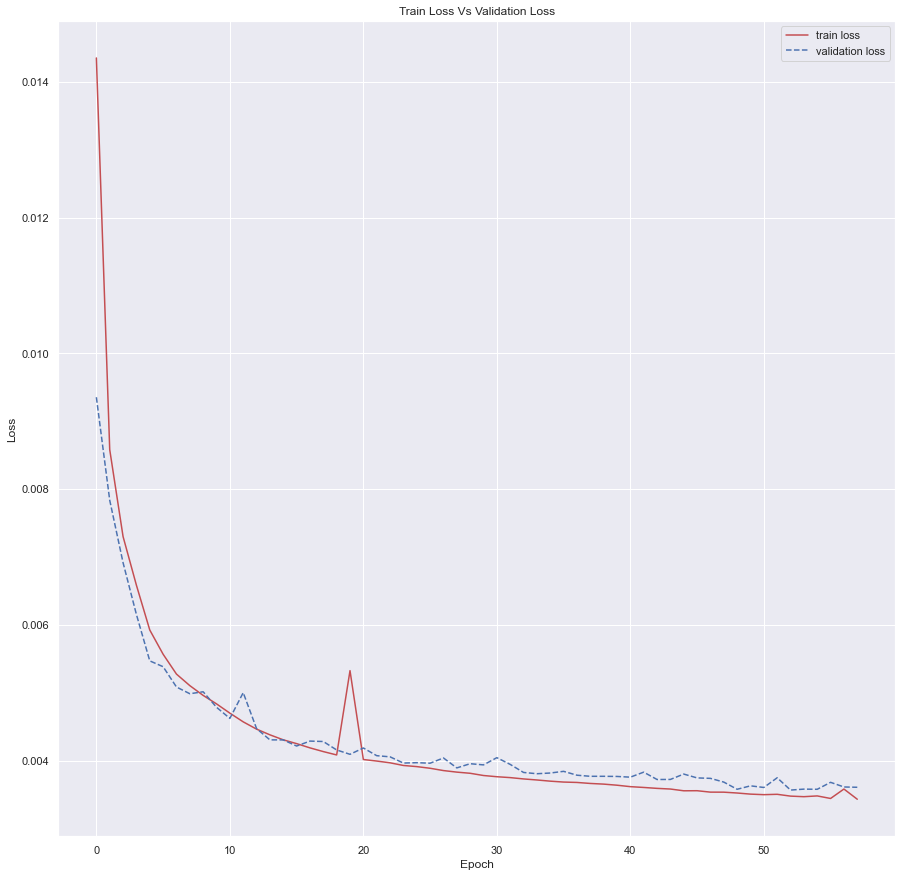

In [69]:
plt.figure(figsize=(15,15))
plt.plot(history.history['loss'], 'r-', label='train loss')
plt.plot(history.history['val_loss'], 'b--', label='validation loss')
plt.title("Train Loss Vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Evaluate model's performance on training set

In [70]:
y_pred = final_model.predict(X_train4)

In [71]:
y_pred = y_pred.reshape(-1)

In [72]:
show10results(y_pred, y_train4)

Result for the 10 random samples:
actual = 0.8797 pred =0.8464
actual = 0.6602 pred =0.6938
actual = 0.8386 pred =0.8681
actual = 0.8063 pred =0.8362
actual = 1.9098 pred =1.8731
actual = 0.6916 pred =0.7372
actual = 0.7248 pred =0.6909
actual = 1.4666 pred =1.5942
actual = 0.6395 pred =0.6631
actual = 0.8011 pred =0.8394


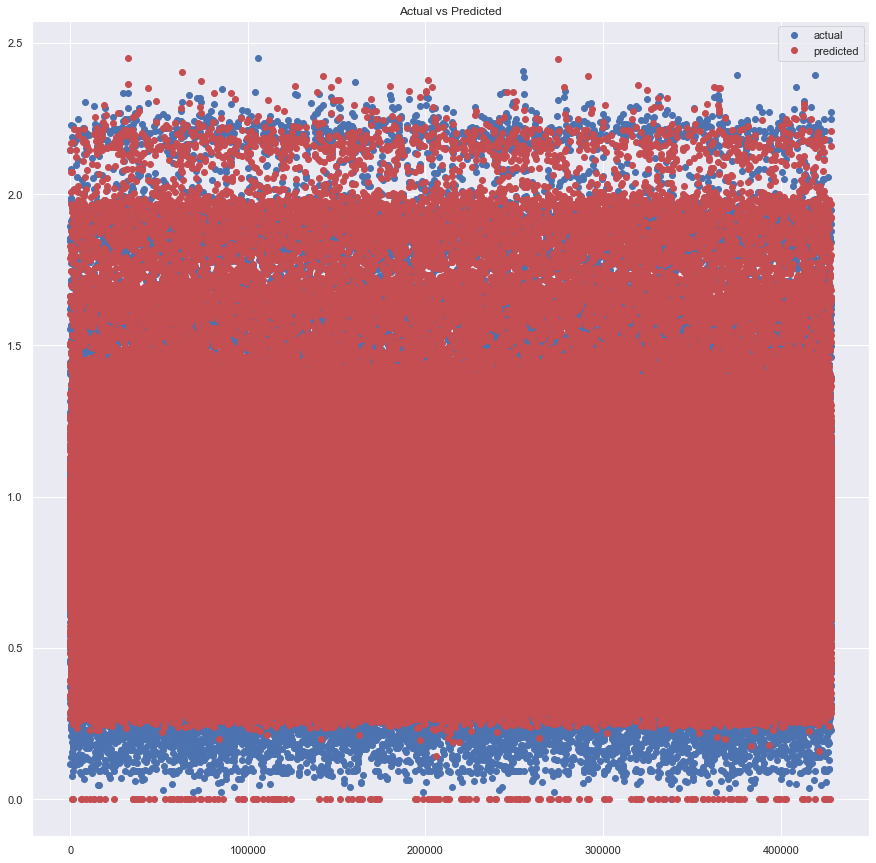

In [73]:
plt.figure(figsize=(15,15))

plt.plot(y_train4, 'bo', label='actual')
plt.plot(y_pred, 'ro', label='predicted')
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

In [74]:
mse, rmse = final_model.evaluate(X_train4, y_train4, verbose=0)
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Squared Error: {:.4f}'.format(rmse))

Mean Squared Error: 0.0034
Root Mean Squared Error: 0.0584


In [75]:
MAE = MeanAbsoluteError()
MAE.update_state(y_pred, y_train4)
print('Mean Absolute Error: {:.4f}'.format(MAE.result().numpy()))

Mean Absolute Error: 0.0370


### Evaluate model's performance on test set

In [53]:
y_hat = final_model.predict(X_test4)

In [54]:
y_hat = y_hat.reshape(-1)

In [55]:
show10results(y_hat, y_test4)

Result for the 10 random samples:
actual = 0.9347 pred =0.9641
actual = 0.7162 pred =0.7588
actual = 0.7844 pred =0.7580
actual = 0.9600 pred =1.0046
actual = 1.2240 pred =1.2544
actual = 0.7772 pred =0.7783
actual = 0.4615 pred =0.5197
actual = 1.0186 pred =1.0490
actual = 0.9706 pred =1.0122
actual = 0.6614 pred =0.6755


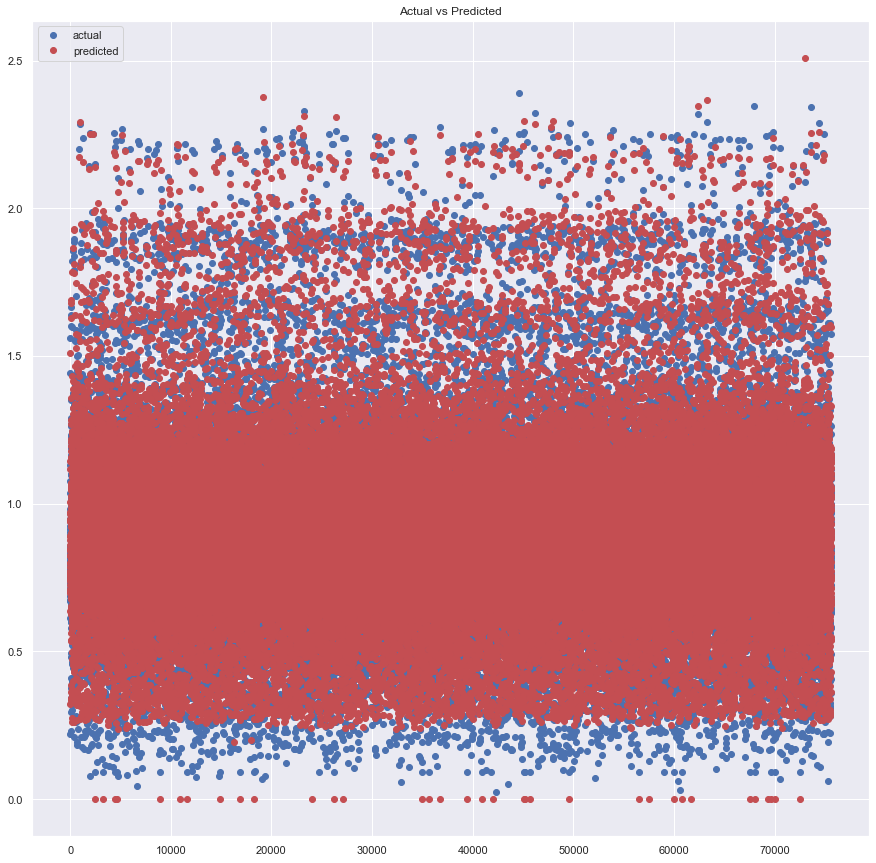

In [61]:
plt.figure(figsize=(15,15))

plt.plot(y_test4, 'bo', label='actual')
plt.plot(y_hat, 'ro', label='predicted')
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

In [57]:
mse, rmse = final_model.evaluate(X_test4, y_test4, verbose=0)
print('Mean Squared Error: {:.4f}'.format(mse))
print('Root Mean Squared Error: {:.4f}'.format(rmse))

Mean Squared Error: 0.0036
Root Mean Squared Error: 0.0598


In [58]:
MAE = MeanAbsoluteError()
MAE.update_state(y_hat, y_test4)
print('Mean Absolute Error: {:.4f}'.format(MAE.result().numpy()))

Mean Absolute Error: 0.0375


## 8) Save model

In [82]:
final_model.save('bestmodel')

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


In [111]:
#Save training mean and standard deviation for GUI
joblib.dump(scaler4, 'std_scaler', compress=True)

['std_scaler']